In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

2025-01-10 11:35:58.830152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736508958.848847 3273066 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736508958.854690 3273066 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import monai
print(dir(monai.networks.nets))
print(monai.__version__)

/mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-10 11:36:24.291855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736508984.311734 3273052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736508984.317973 3273052 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MedNeXt', 'MedNeXtB', 'MedNeXtL', 'MedNeXtLarge', 'MedNeXtM', 'MedNeXtMedium', 'MedNeXtS', 'MedNeXtSmall', 'MedNext', 'MedNextB',

## Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")
training_dir_noise = os.path.join(root_dir, "masks_training_noise")
testing_dir_noise = os.path.join(root_dir, "masks_testing_noise")
training_dir_sphere = os.path.join(root_dir, "masks_training_sphere")
testing_dir_sphere = os.path.join(root_dir, "masks_testing_sphere")
training_dir_sphere_2 = os.path.join(root_dir, "masks_training_sphere_2")
testing_dir_sphere_2 = os.path.join(root_dir, "masks_testing_sphere_2")
training_dir_sphere_3 = os.path.join(root_dir, "masks_training_dilation")
testing_dir_sphere_3 = os.path.join(root_dir, "masks_testing_dilation")
training_dir_elongated = os.path.join(root_dir, "masks_training_noise_2")
testing_dir_elongated = os.path.join(root_dir, "masks_testing_noise_2")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"
assert os.path.exists(training_dir_noise), f"El directorio {training_dir_noise} no existe"
assert os.path.exists(testing_dir_noise), f"El directorio {testing_dir_noise} no existe"
assert os.path.exists(training_dir_sphere), f"El directorio {training_dir_sphere} no existe"
assert os.path.exists(testing_dir_sphere), f"El directorio {testing_dir_sphere} no existe"
assert os.path.exists(training_dir_sphere_2), f"El directorio {training_dir_sphere_2} no existe"
assert os.path.exists(testing_dir_sphere_2), f"El directorio {testing_dir_sphere_2} no existe"
assert os.path.exists(training_dir_sphere_3), f"El directorio {training_dir_sphere_3} no existe"
assert os.path.exists(testing_dir_sphere_3), f"El directorio {testing_dir_sphere_3} no existe"
assert os.path.exists(training_dir_elongated), f"El directorio {training_dir_elongated} no existe"
assert os.path.exists(testing_dir_elongated), f"El directorio {testing_dir_elongated} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)
training_files_noise = list_nifti_files(training_dir_noise)
testing_files_noise = list_nifti_files(testing_dir_noise)
training_files_sphere = list_nifti_files(training_dir_sphere)
testing_files_sphere = list_nifti_files(testing_dir_sphere)
training_files_sphere_2 = list_nifti_files(training_dir_sphere_2)
testing_files_sphere_2 = list_nifti_files(testing_dir_sphere_2)
training_files_sphere_3 = list_nifti_files(training_dir_sphere_3)
testing_files_sphere_3 = list_nifti_files(testing_dir_sphere_3)
training_files_elongated = list_nifti_files(training_dir_elongated)
testing_files_elongated = list_nifti_files(testing_dir_elongated)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_noise}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_dir_noise}")
print(f"Se encontraron {len(training_files_sphere)} archivos en {training_files_sphere}")
print(f"Se encontraron {len(testing_files_sphere)} archivos en {testing_dir_sphere}")
print(f"Se encontraron {len(training_files_sphere_2)} archivos en {training_files_sphere_2}")
print(f"Se encontraron {len(testing_files_sphere_2)} archivos en {testing_dir_sphere_2}")
print(f"Se encontraron {len(training_files_sphere_3)} archivos en {training_files_sphere_3}")
print(f"Se encontraron {len(testing_files_sphere_3)} archivos en {testing_dir_sphere_3}")
print(f"Se encontraron {len(training_files_elongated)} archivos en {training_files_elongated}")
print(f"Se encontraron {len(testing_files_elongated)} archivos en {testing_files_elongated}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing
Se encontraron 200 archivos en ['/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/d

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


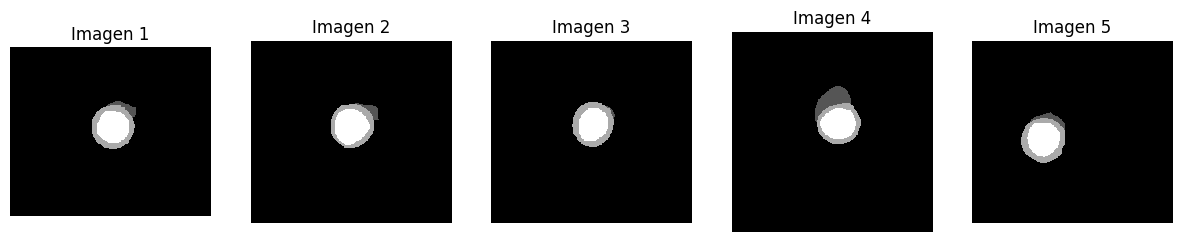

In [6]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


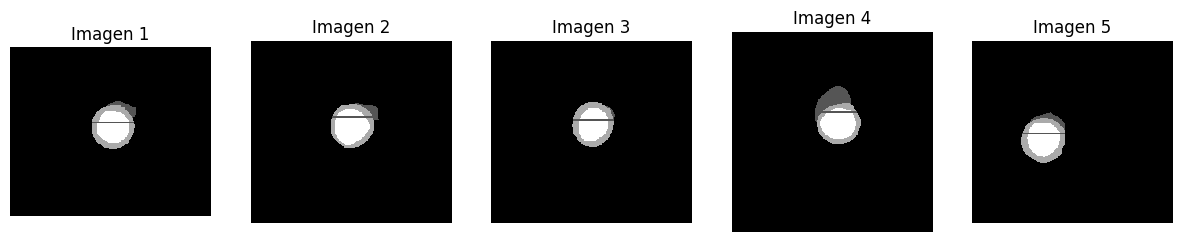

In [7]:
images_noise = [nib.load(file).get_fdata() for file in training_files_noise[:5]] 
fig, axs = plt.subplots(1, len(images_noise), figsize=(15, 5))

for i, img in enumerate(images_noise):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


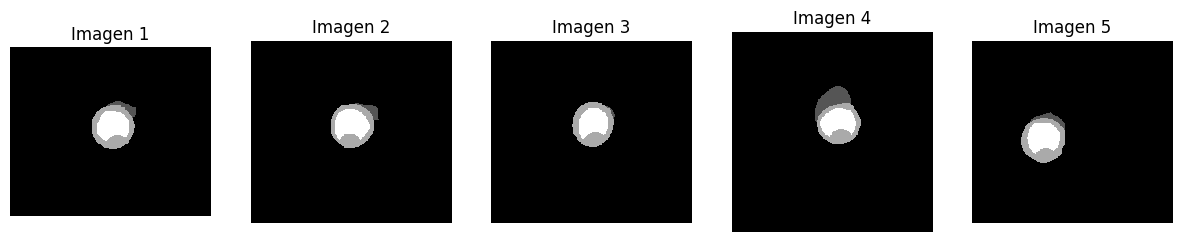

In [8]:
images_sphere = [nib.load(file).get_fdata() for file in training_files_sphere[:5]] 
fig, axs = plt.subplots(1, len(images_sphere), figsize=(15, 5))

for i, img in enumerate(images_sphere):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 216, 10)
(222, 224, 10)


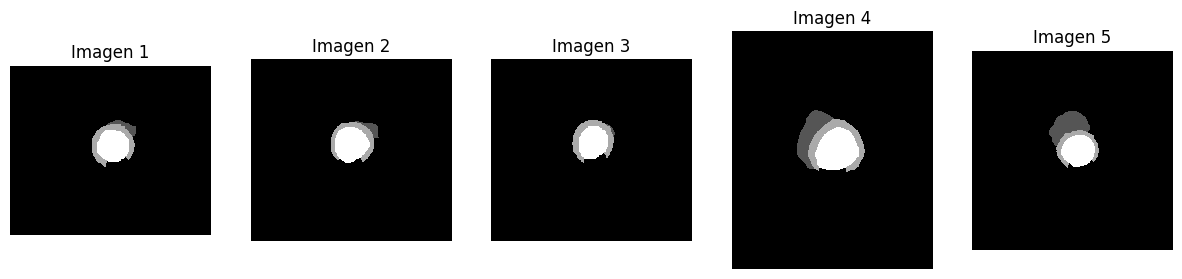

In [9]:
images_sphere_2 = [nib.load(file).get_fdata() for file in training_files_sphere_2[:5]] 
fig, axs = plt.subplots(1, len(images_sphere_2), figsize=(15, 5))

for i, img in enumerate(images_sphere_2):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 216, 10)
(222, 224, 10)


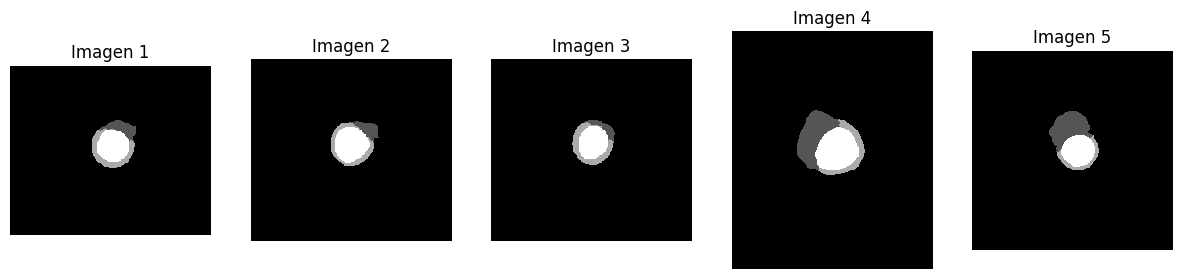

In [10]:
images_sphere_3 = [nib.load(file).get_fdata() for file in training_files_sphere_3[:5]] 
fig, axs = plt.subplots(1, len(images_sphere_3), figsize=(15, 5))

for i, img in enumerate(images_sphere_3):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [11]:
all_files = training_files + testing_files
all_files_noise = training_files_noise + testing_files_noise
all_files_sphere = training_files_sphere + testing_files_sphere
all_files_sphere_2 = training_files_sphere_2 + testing_files_sphere_2
all_files_sphere_3 = training_files_sphere_3 + testing_files_sphere_3

images = [nib.load(file).get_fdata() for file in all_files]
images_noise = [nib.load(file).get_fdata() for file in all_files_noise]
images_sphere = [nib.load(file).get_fdata() for file in all_files_sphere]
image_shapes = [img.shape for img in images]
image_shapes_noise = [img.shape for img in images_noise]
image_shapes_sphere = [img.shape for img in images_sphere]
image_shapes_sphere_2 = [img.shape for img in images_sphere_2]
image_shapes_sphere_3 = [img.shape for img in images_sphere_3]
print(image_shapes)
print(image_shapes_noise)
print(image_shapes_sphere)
print(image_shapes_sphere_2)
print(image_shapes_sphere_3)
average_shape = np.mean(image_shapes, axis=0).astype(int)
average_shape_noise = np.mean(image_shapes_noise, axis=0).astype(int)
average_shape_sphere = np.mean(image_shapes_sphere, axis=0).astype(int)
average_shape_sphere_2 = np.mean(image_shapes_sphere_2, axis=0).astype(int)
average_shape_sphere_3 = np.mean(image_shapes_sphere_3, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
print(f"Tamaño promedio de las imágenes con ruido: {average_shape_noise}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere_2}")
print(f"Tamaño promedio de las imágenes con esferas: {average_shape_sphere_3}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)
min_shape_noise = np.min(image_shapes_noise, axis=0)
max_shape_noise = np.max(image_shapes_noise, axis=0)
min_shape_sphere = np.min(image_shapes_sphere, axis=0)
max_shape_sphere = np.max(image_shapes_sphere, axis=0)
min_shape_sphere_2 = np.min(image_shapes_sphere_2, axis=0)
max_shape_sphere_2 = np.max(image_shapes_sphere_2, axis=0)
min_shape_sphere_3 = np.min(image_shapes_sphere_3, axis=0)
max_shape_sphere_3 = np.max(image_shapes_sphere_3, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")
print(f"Tamaño mínimo: {min_shape_noise}")
print(f"Tamaño máximo: {max_shape_noise}")
print(f"Tamaño mínimo: {min_shape_sphere}")
print(f"Tamaño máximo: {max_shape_sphere}")
print(f"Tamaño mínimo: {min_shape_sphere_2}")
print(f"Tamaño máximo: {max_shape_sphere_2}")
print(f"Tamaño mínimo: {min_shape_sphere_3}")
print(f"Tamaño máximo: {max_shape_sphere_3}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [12]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [13]:
from monai.data import NibabelReader
from monai.transforms import CastToTyped

In [14]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y escala la intensidad de la imagen

resize_dim = (12, 128, 128)

all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="LPS"),
    # transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
    transforms.Resized(keys=["image"], spatial_size=resize_dim, mode=('nearest-exact')), 
]

In [15]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [16]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_noise)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [17]:
train_data_dicts_sphere = [{"image": file} for file in training_files_sphere][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [18]:
train_data_dicts_sphere_2 = [{"image": file} for file in training_files_sphere_2][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere_2)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [19]:
train_data_dicts_sphere_3 = [{"image": file} for file in training_files_sphere_3][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_sphere_3)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [20]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_elongated)[0]['image'].shape

torch.Size([4, 12, 128, 128])

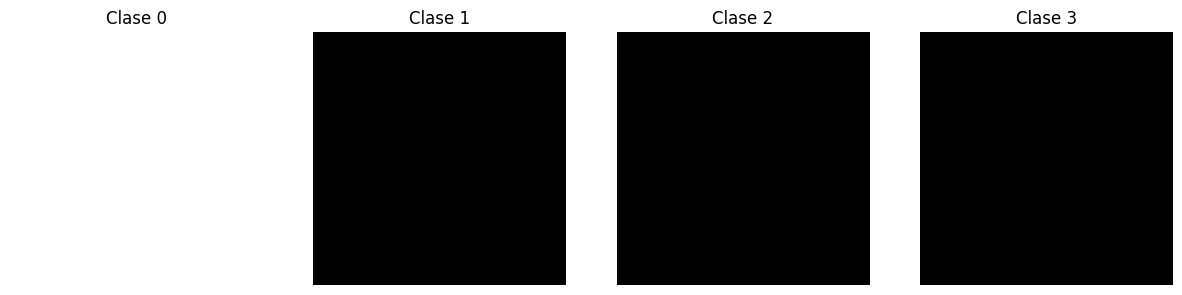

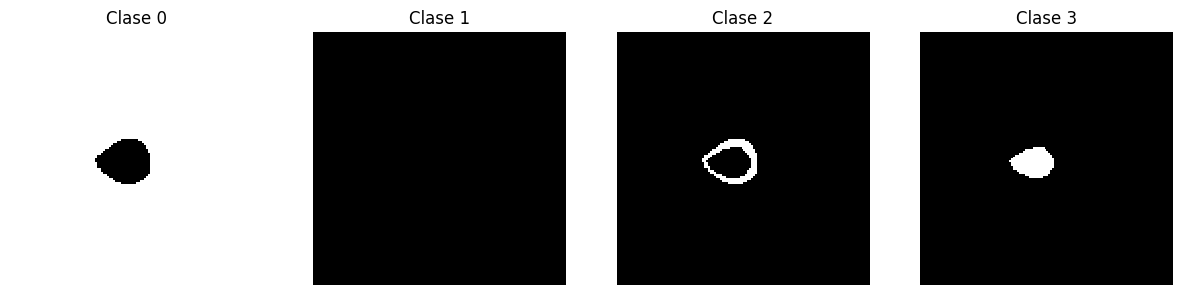

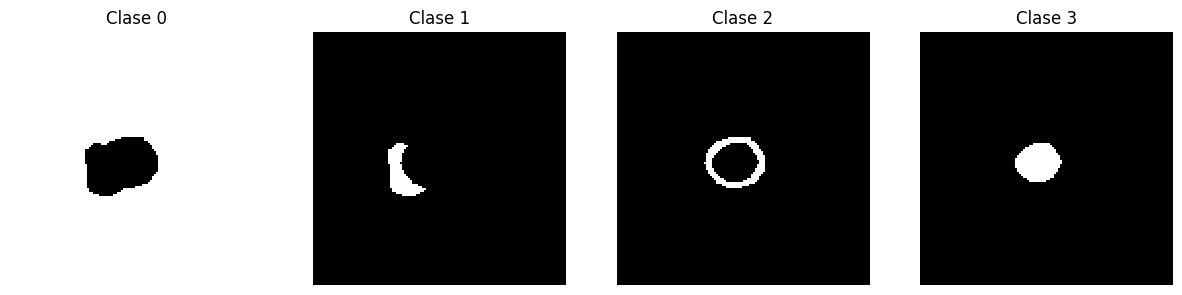

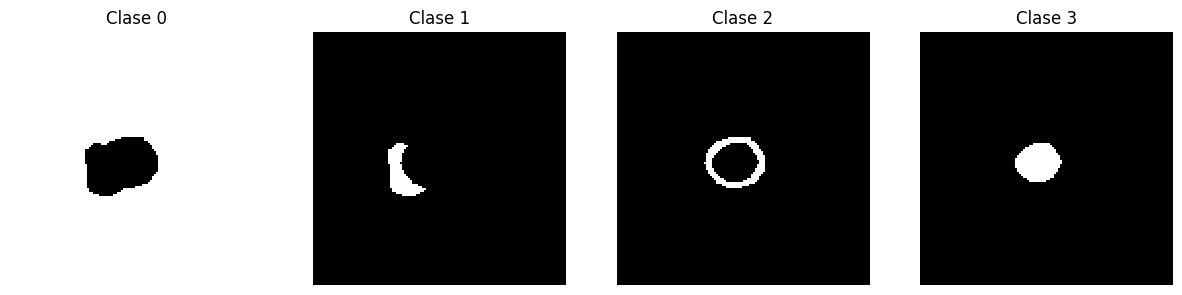

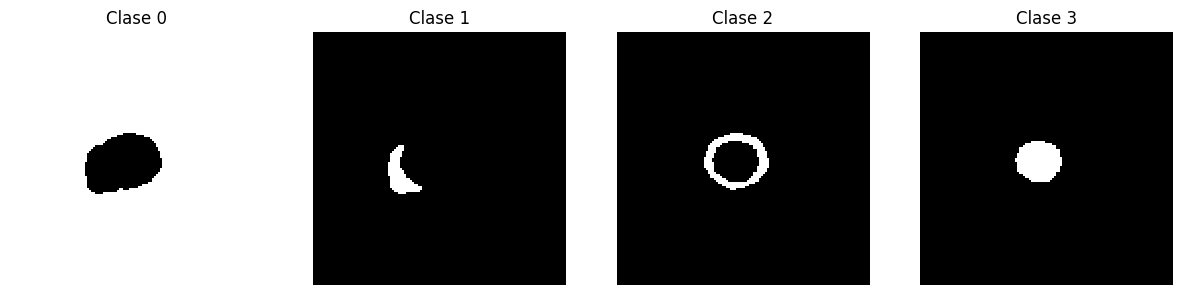

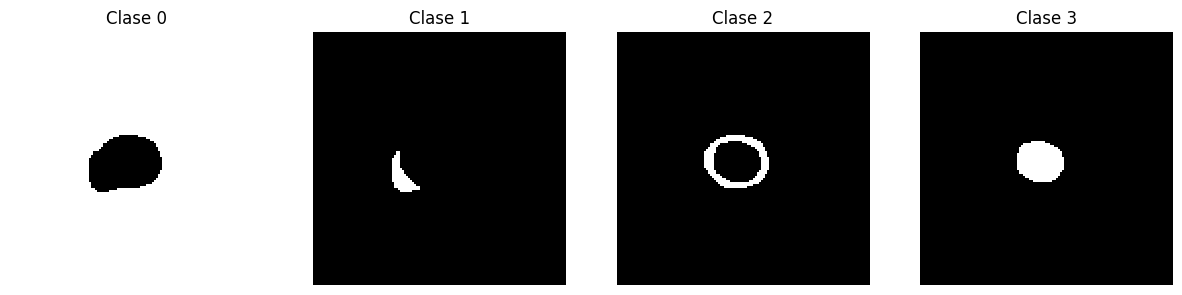

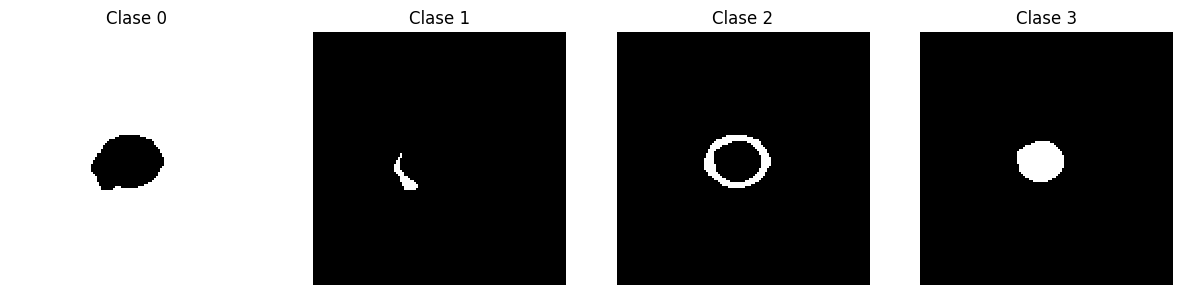

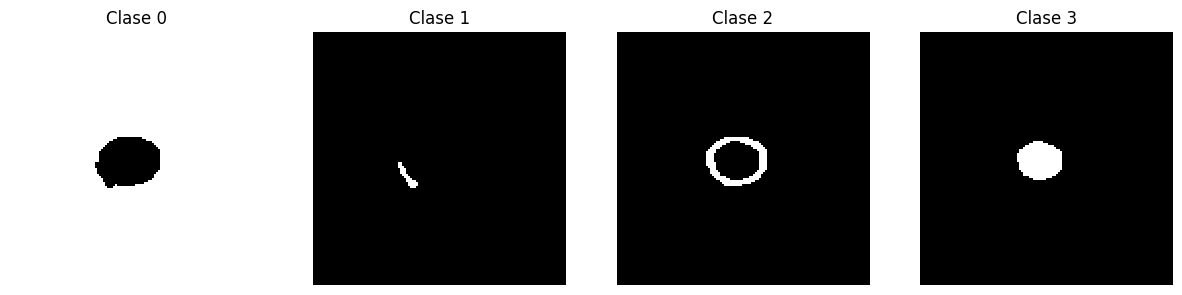

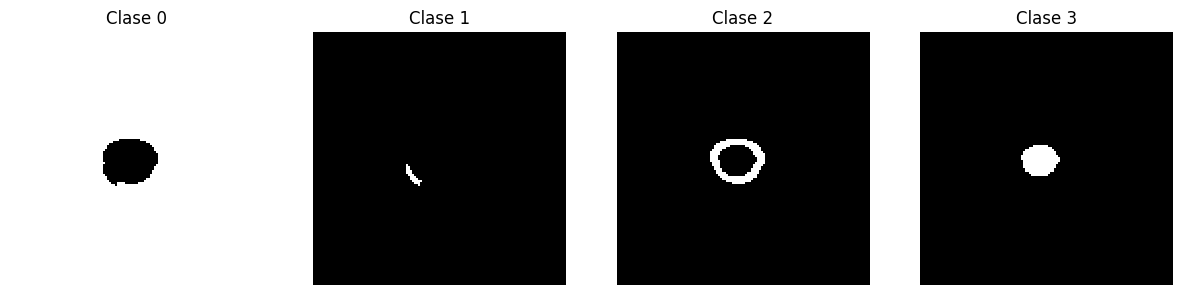

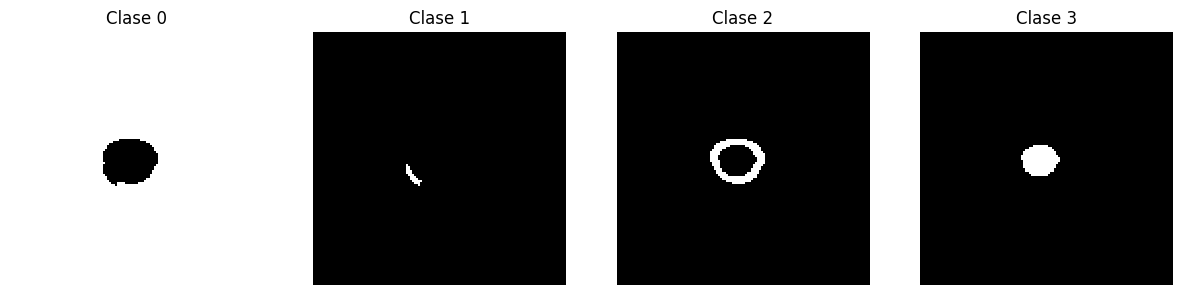

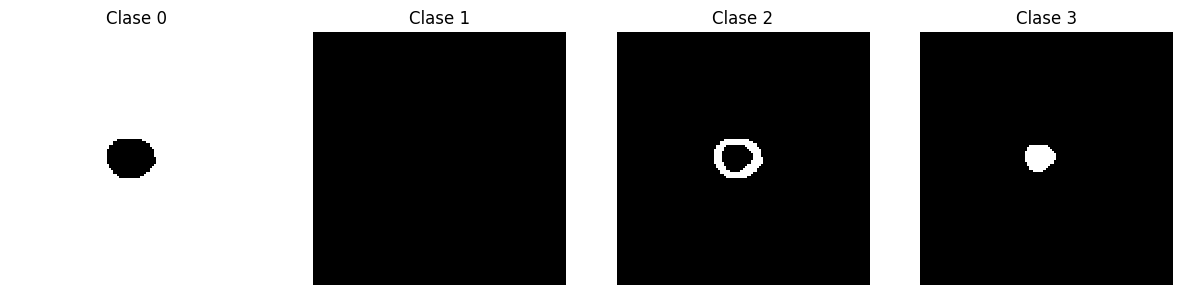

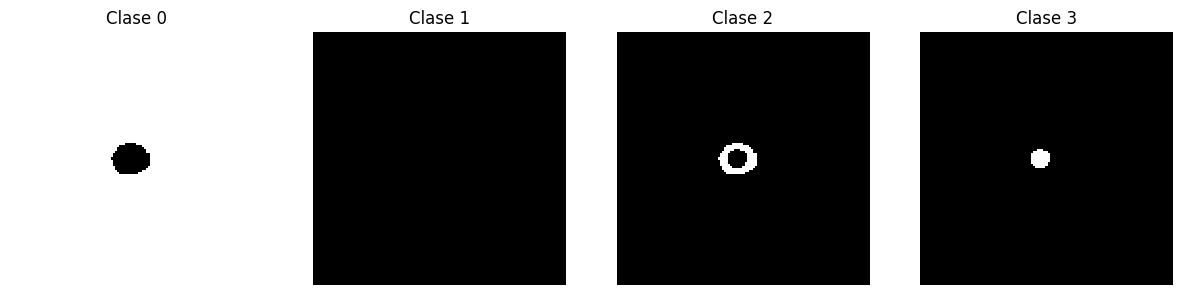

In [21]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

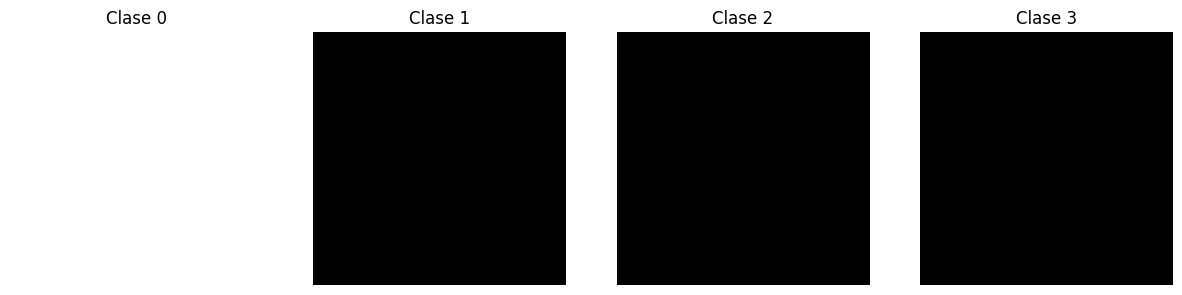

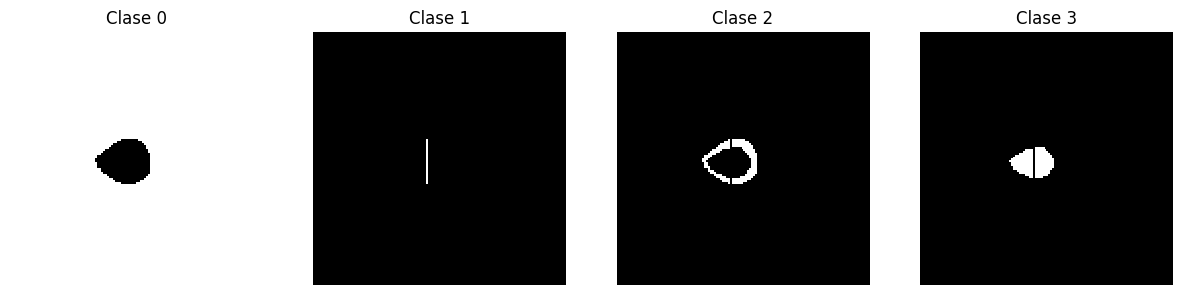

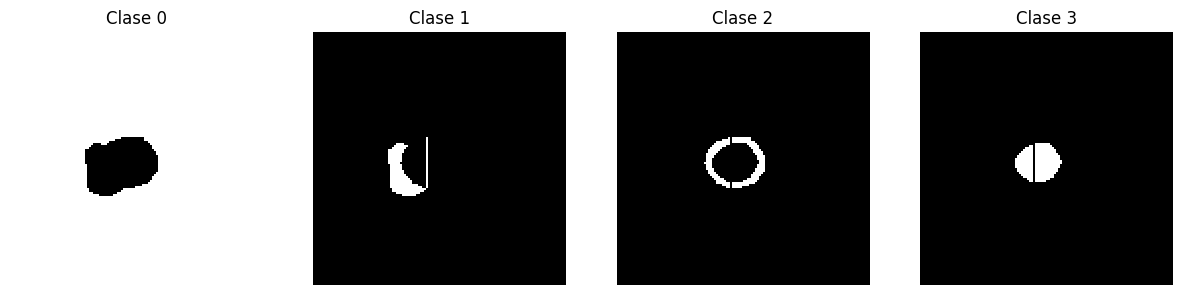

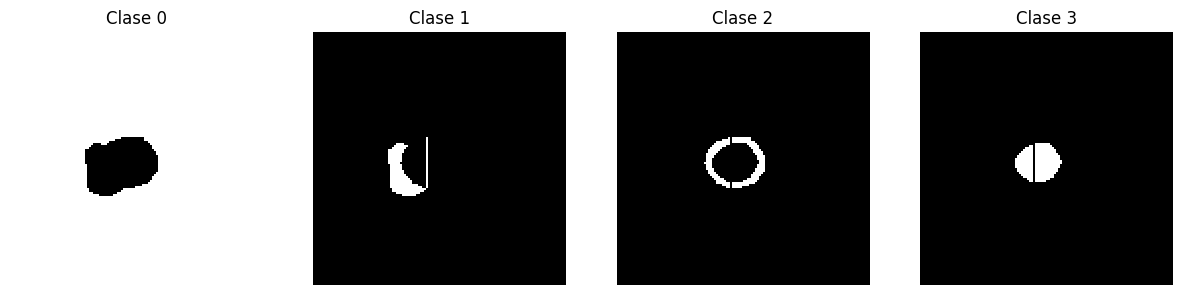

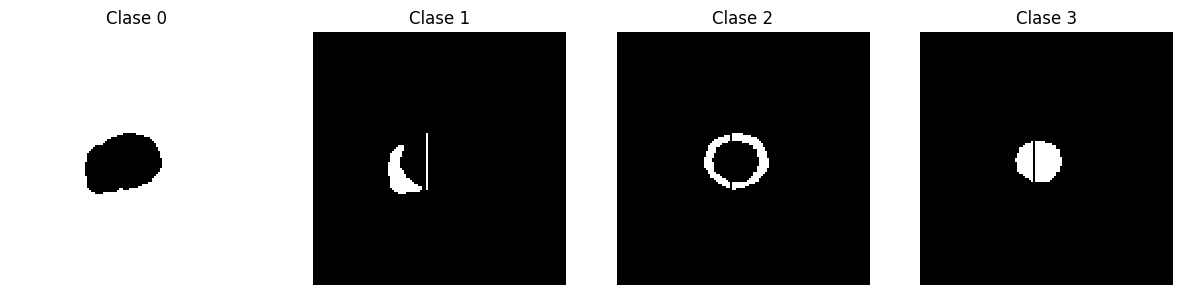

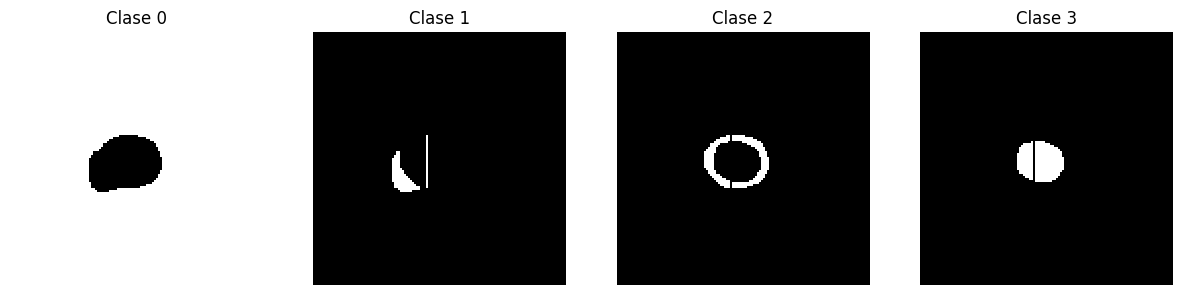

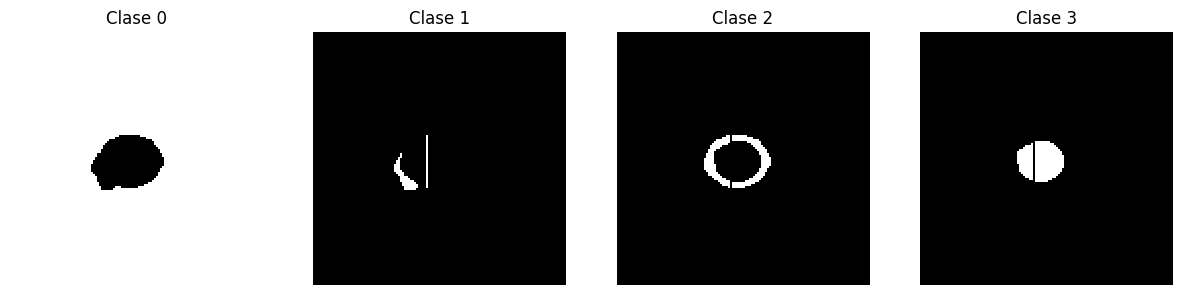

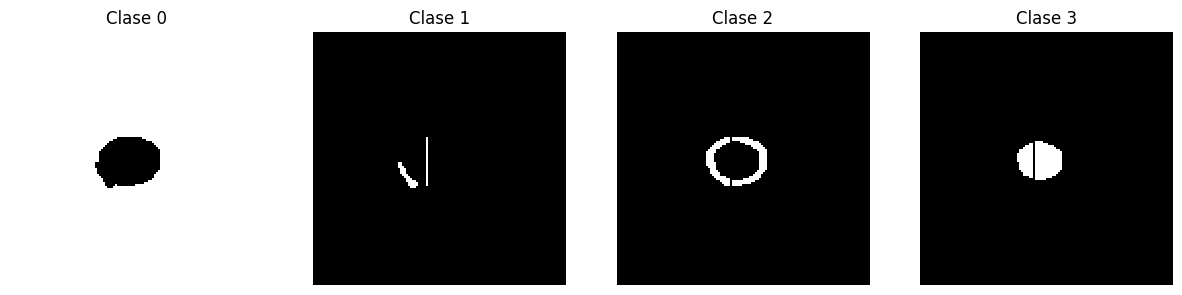

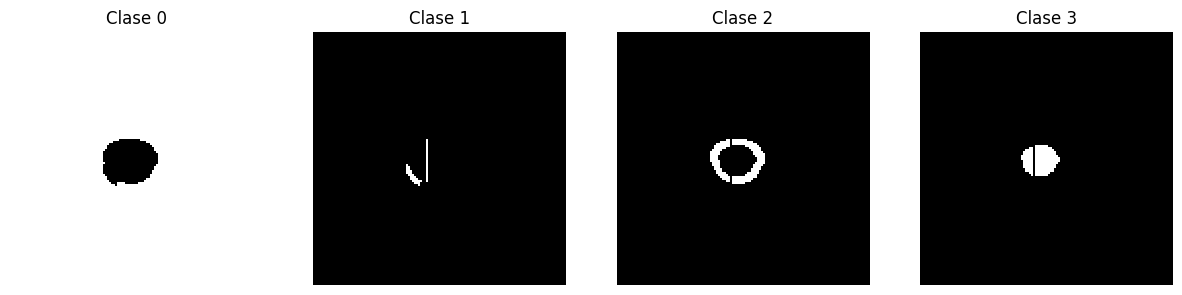

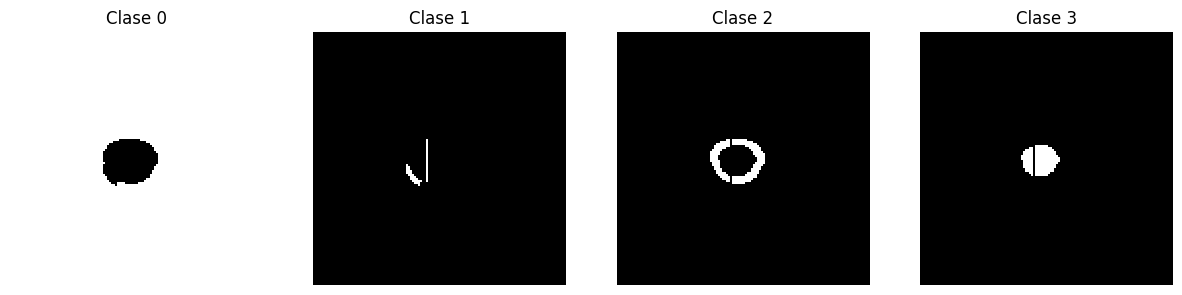

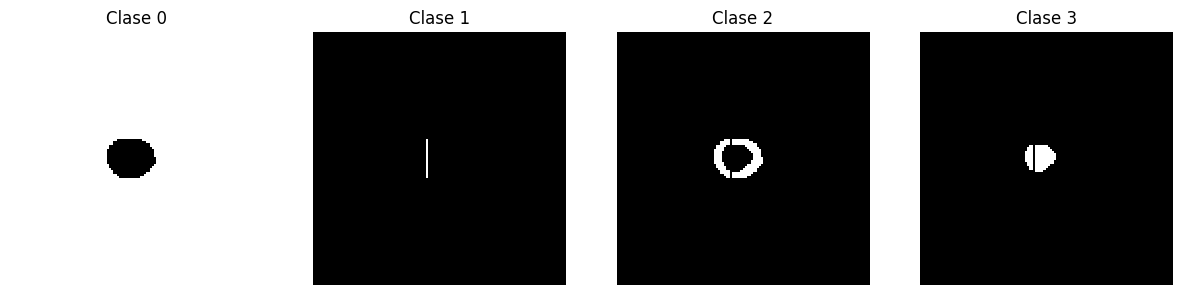

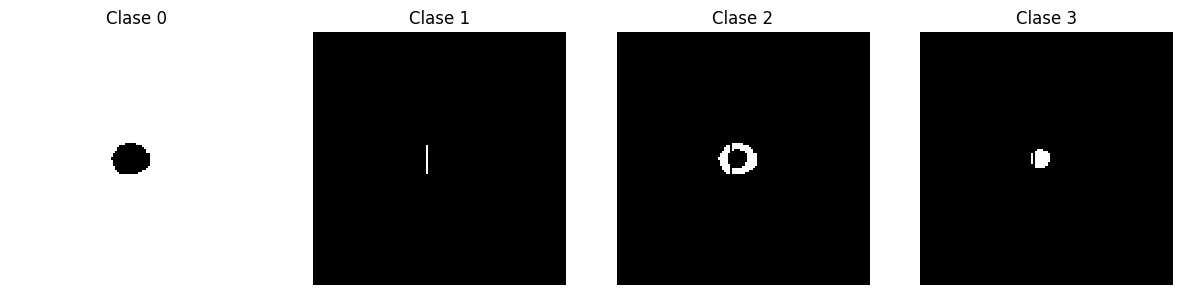

In [22]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_noise)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

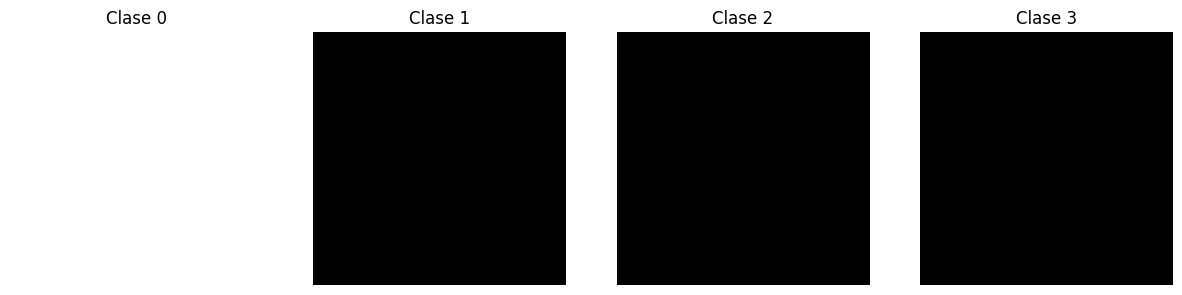

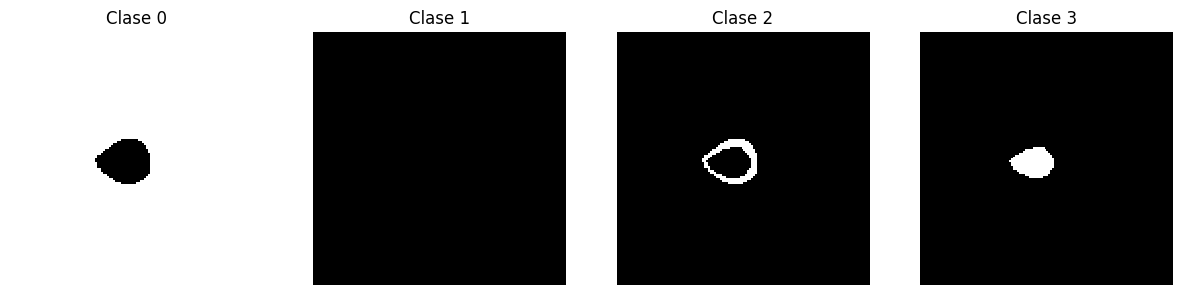

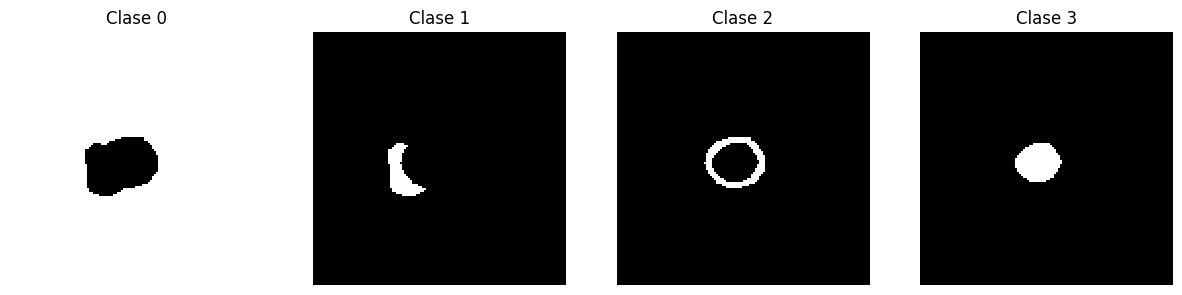

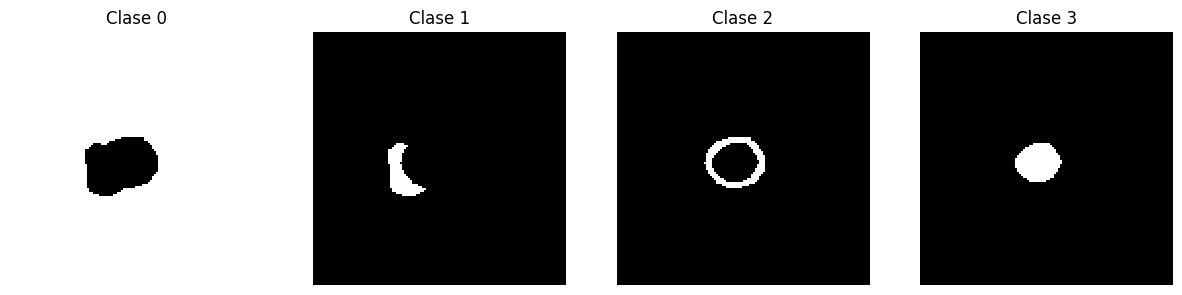

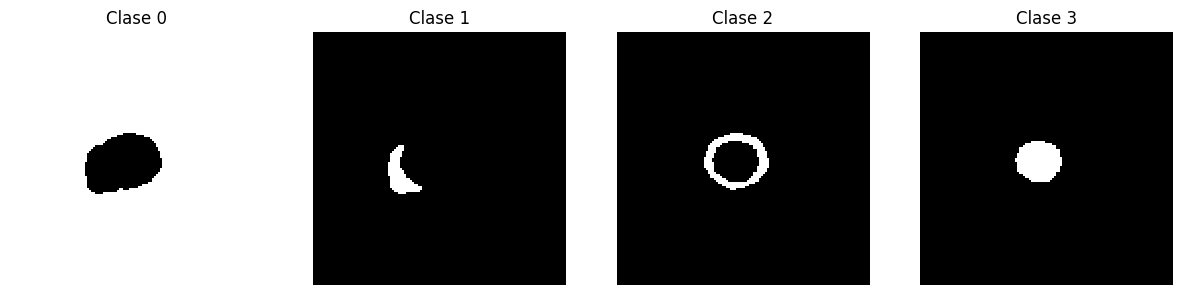

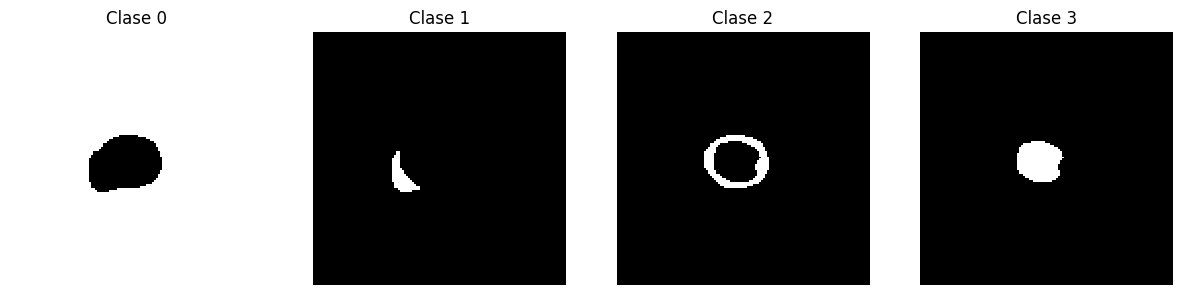

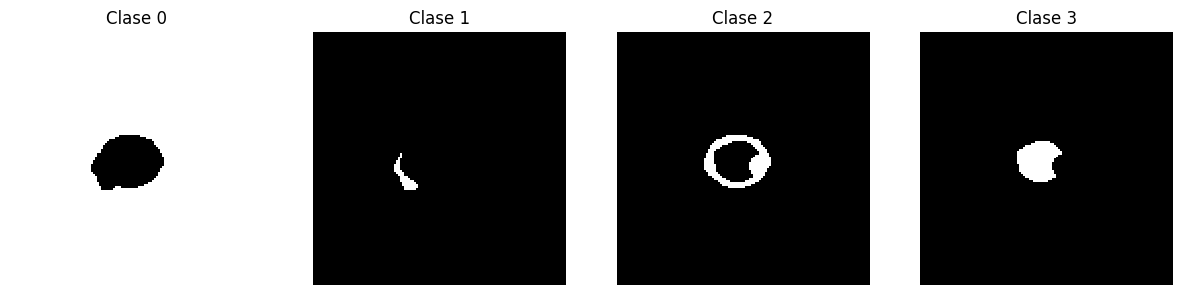

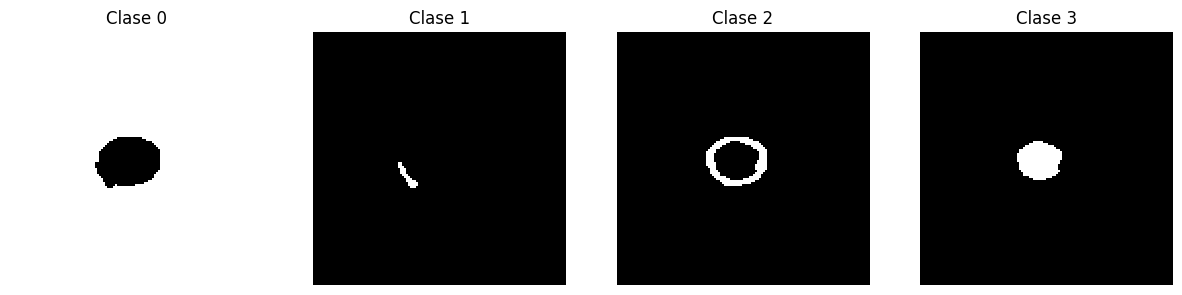

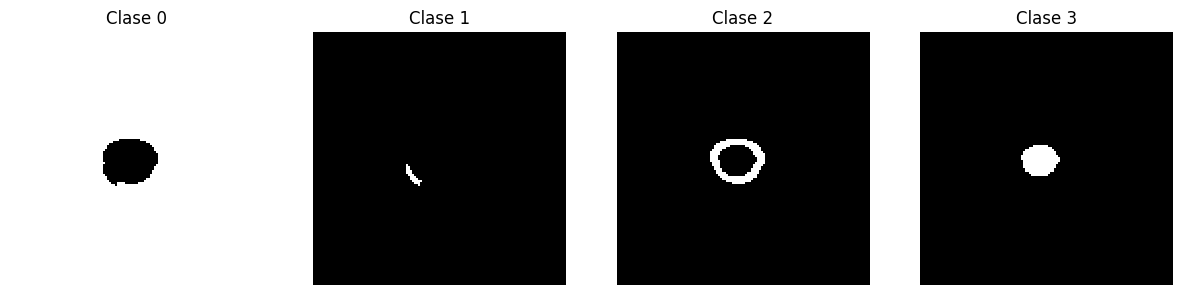

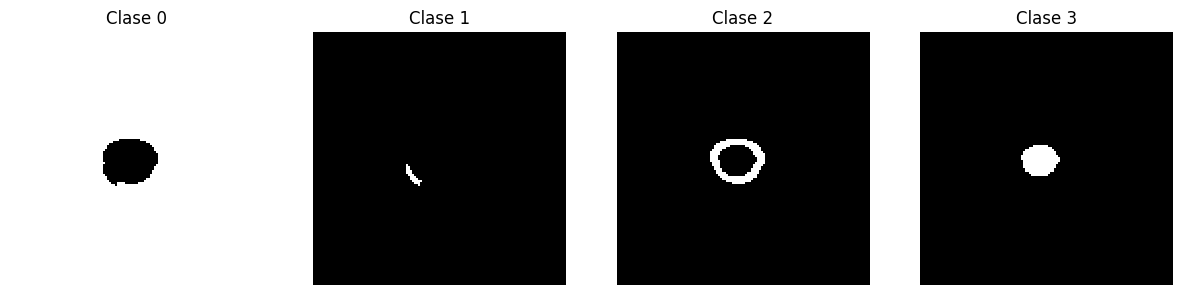

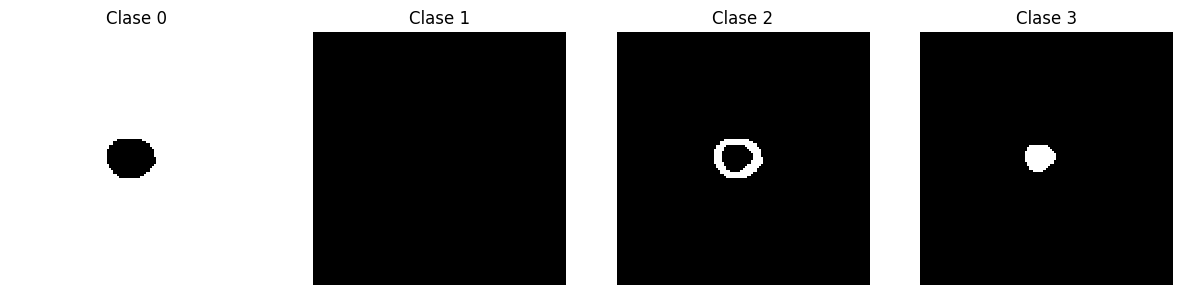

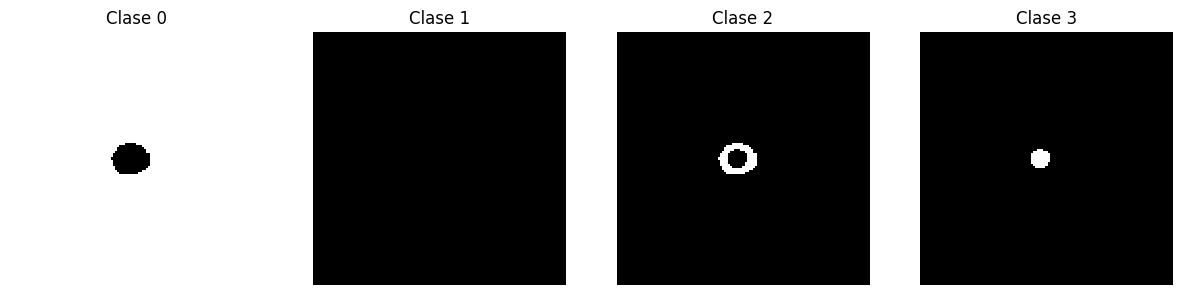

In [23]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

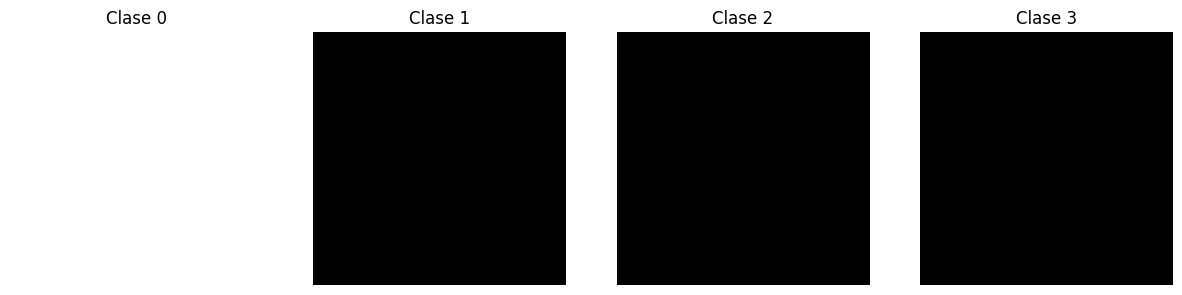

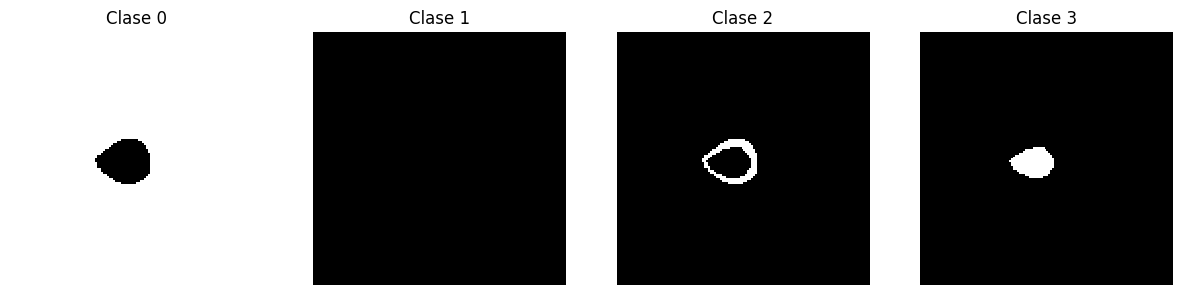

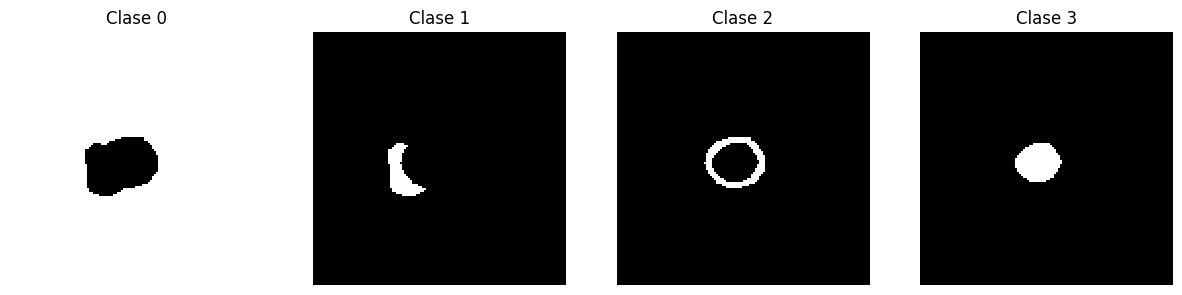

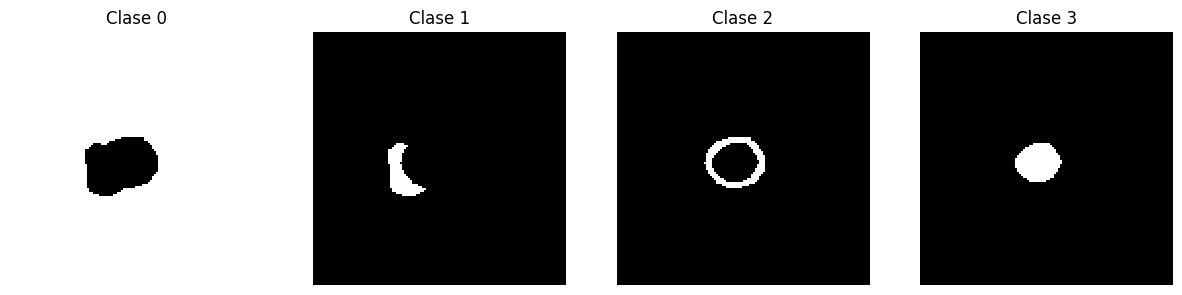

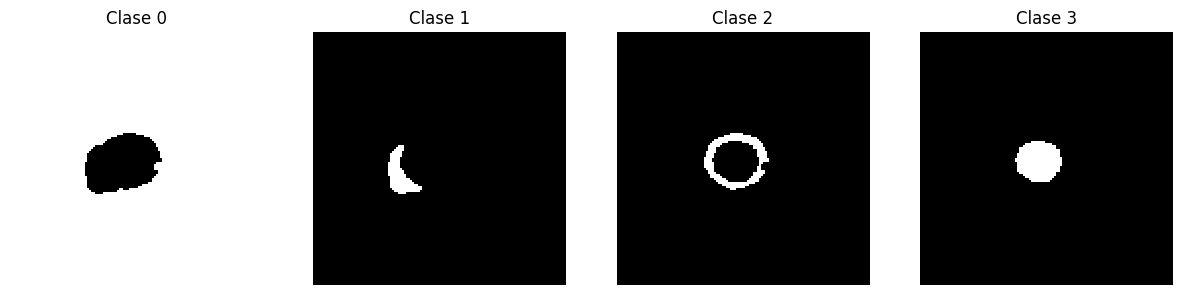

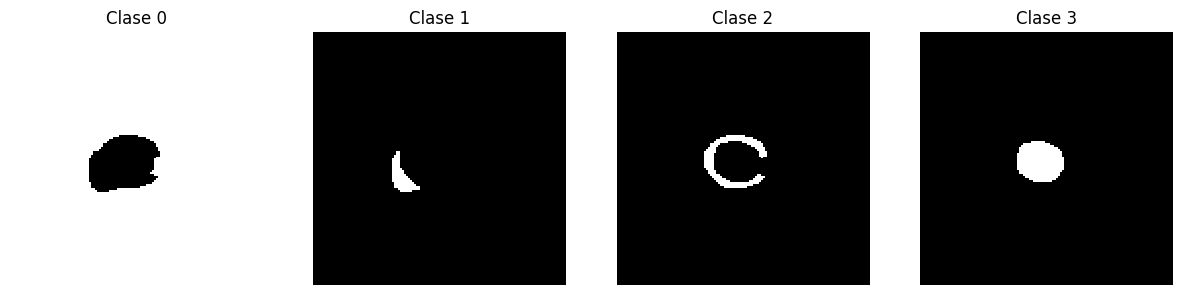

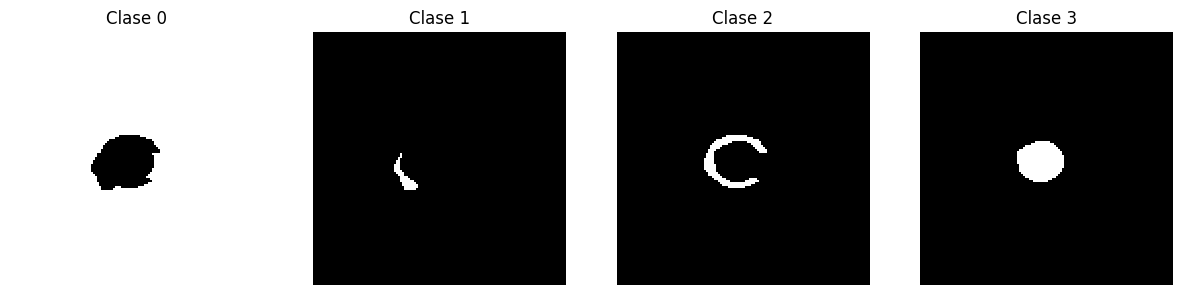

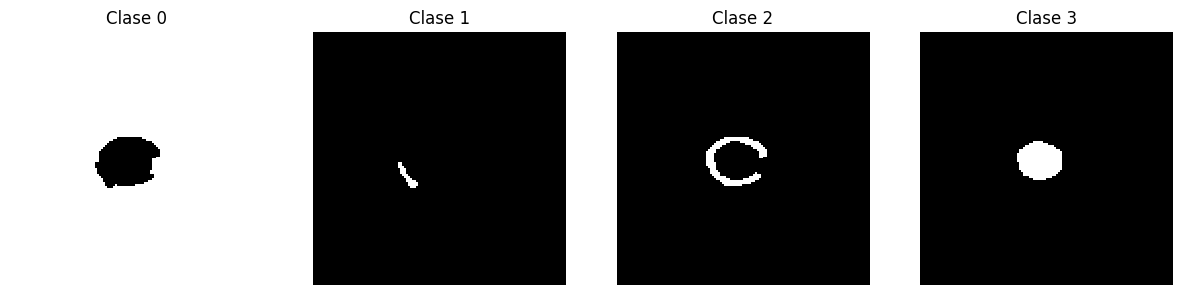

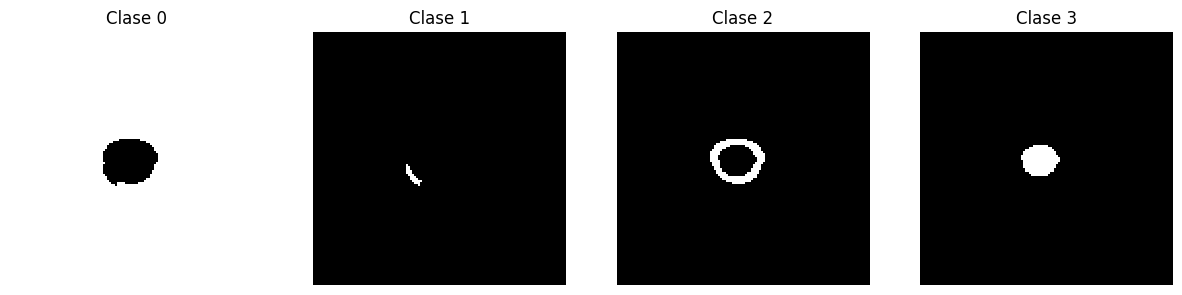

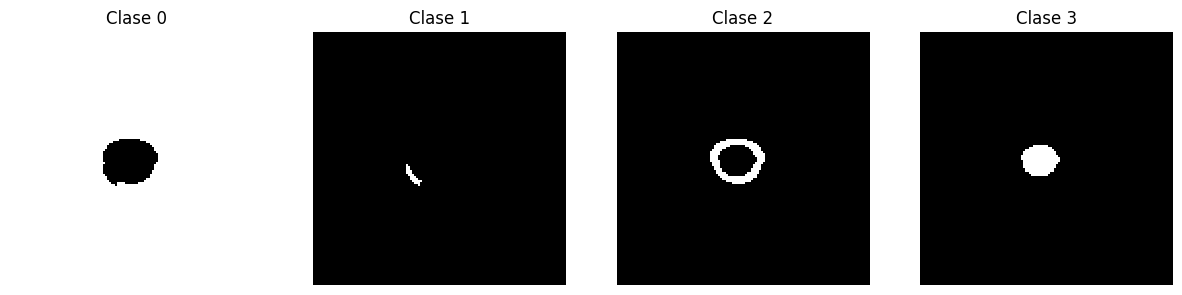

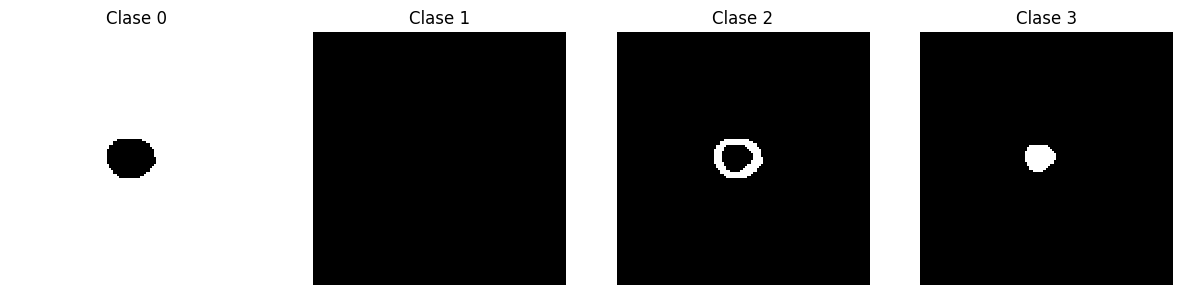

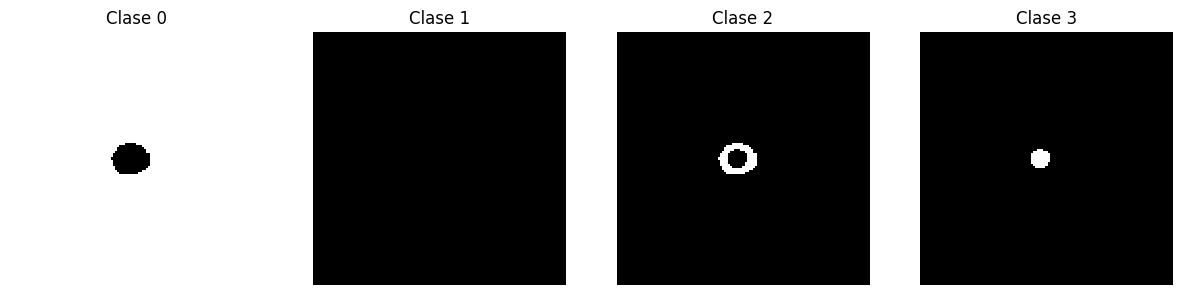

In [24]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere_2)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

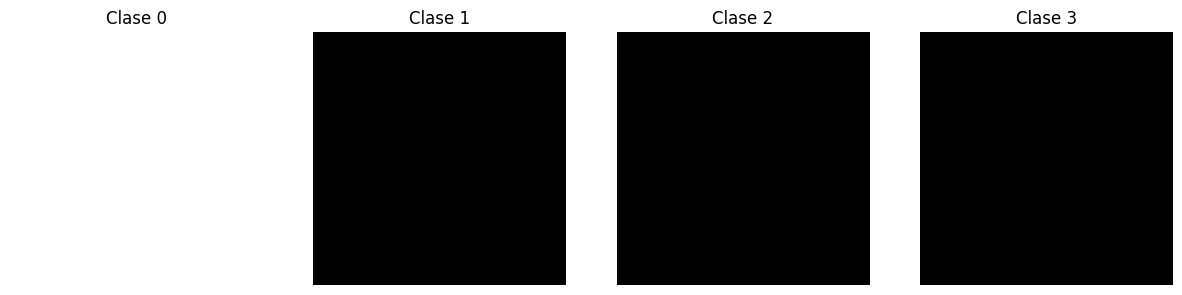

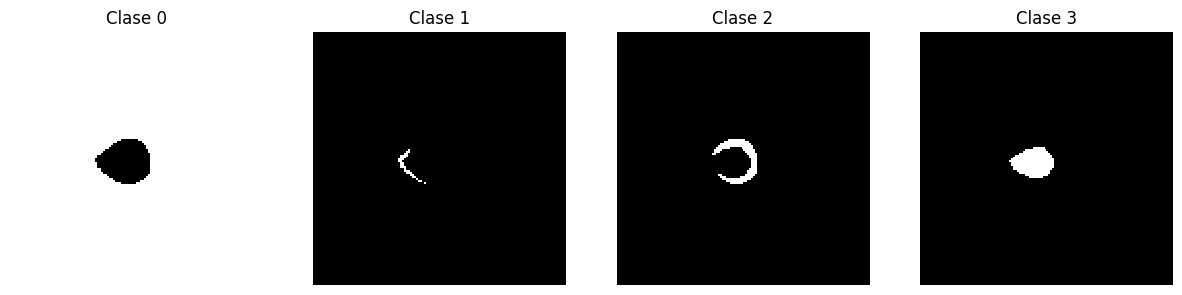

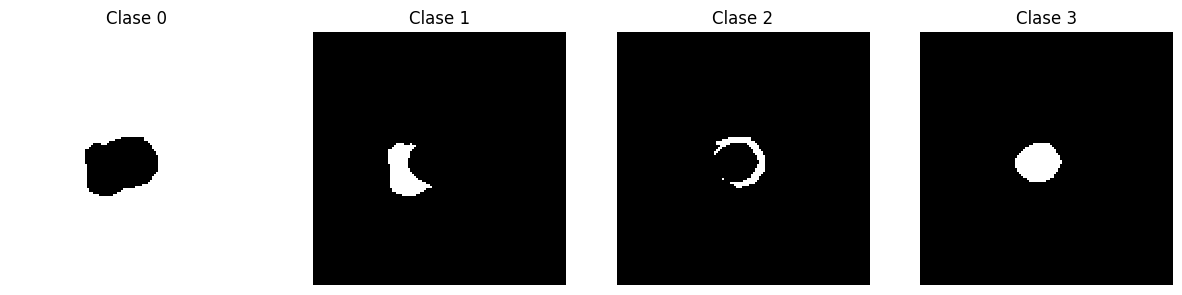

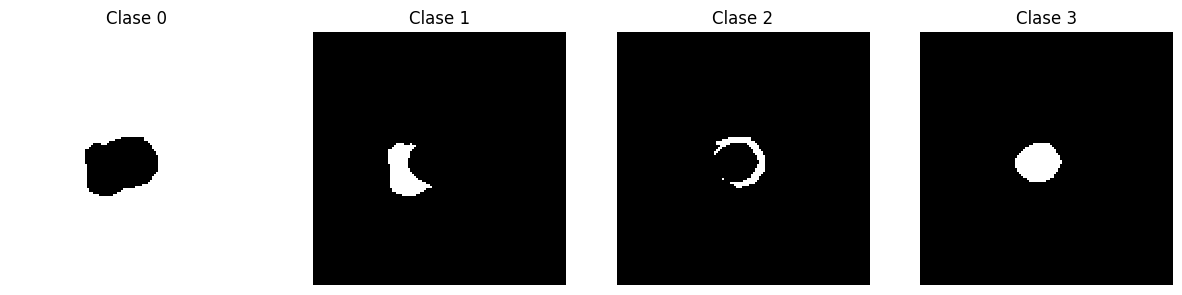

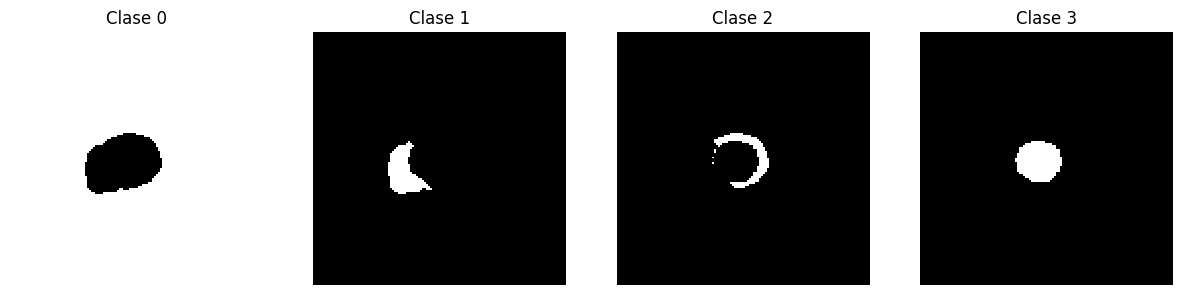

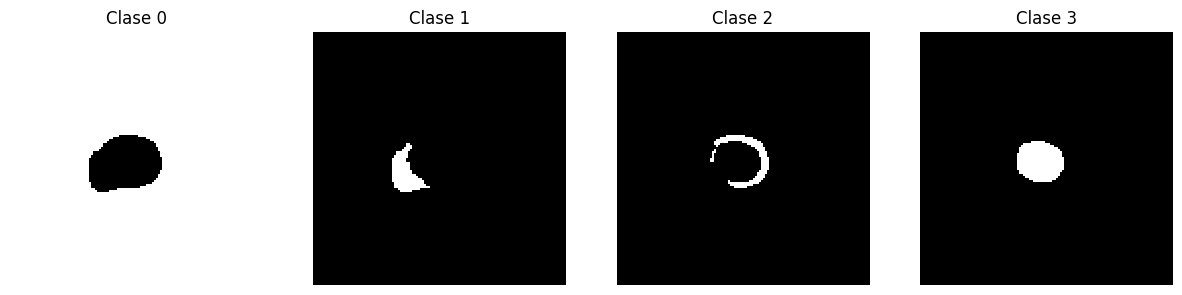

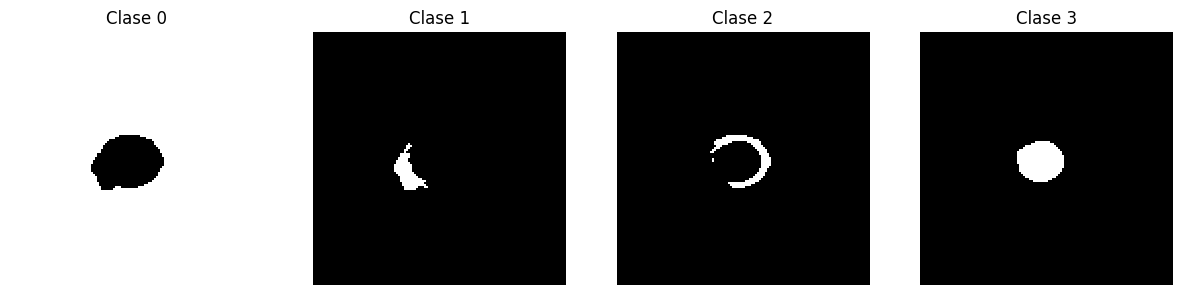

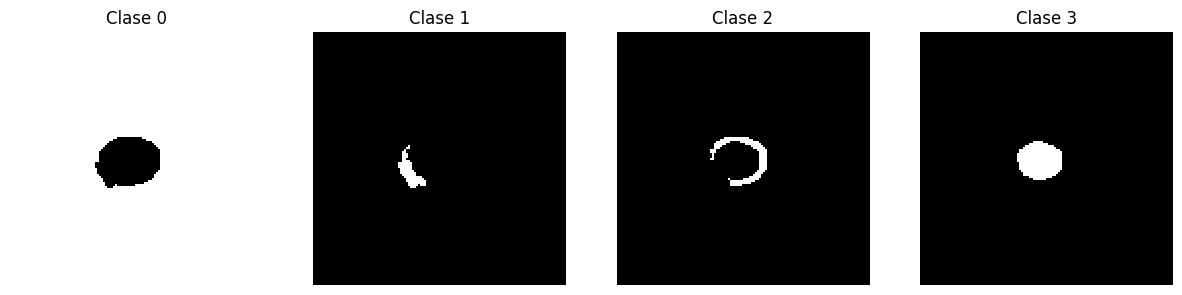

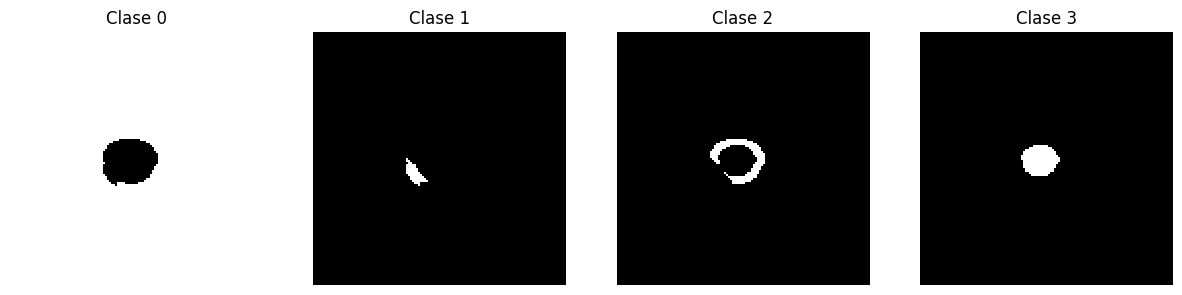

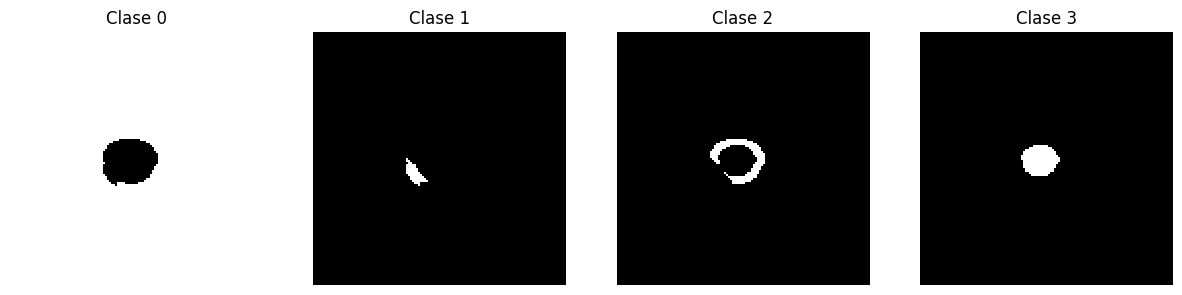

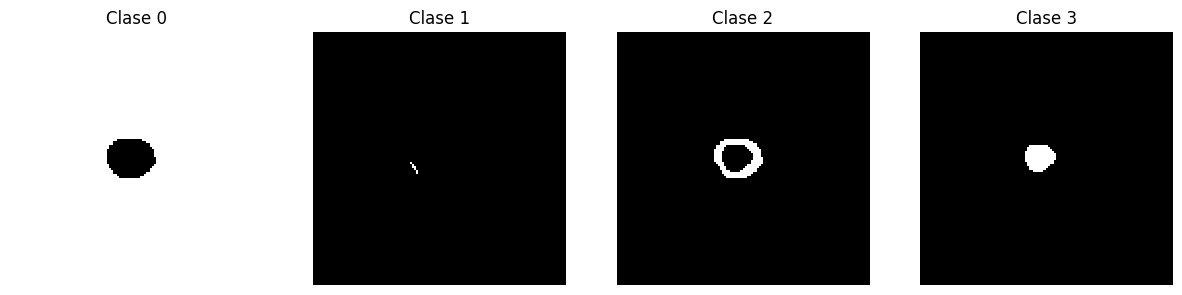

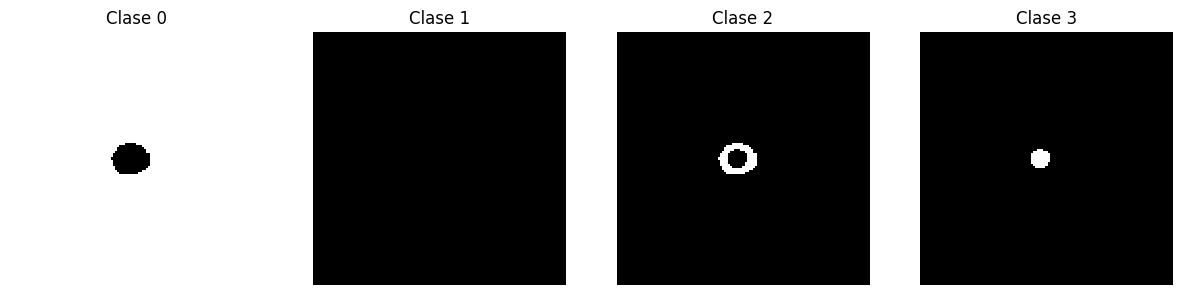

In [25]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_sphere_3)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [26]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [27]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise]
train_ds_noise = Dataset(data=train_data_dicts_noise, transform=all_transforms)

val_data_dicts_noise = [{"image": file} for file in testing_files_noise]
val_ds_noise = Dataset(data=val_data_dicts_noise, transform=all_transforms)

train_loader_noise = DataLoader(train_ds_noise, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_noise[0]["image"].shape}')
val_loader_noise = DataLoader(val_ds_noise, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_noise[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [28]:
train_data_dicts_sphere = [{"image": file} for file in training_files_sphere]
train_ds_sphere = Dataset(data=train_data_dicts_sphere, transform=all_transforms)

val_data_dicts_sphere = [{"image": file} for file in testing_files_sphere]
val_ds_sphere = Dataset(data=val_data_dicts_sphere, transform=all_transforms)

train_loader_sphere = DataLoader(train_ds_sphere, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere[0]["image"].shape}')
val_loader_sphere = DataLoader(val_ds_sphere, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [29]:
train_data_dicts_sphere_2 = [{"image": file} for file in training_files_sphere_2]
train_ds_sphere_2 = Dataset(data=train_data_dicts_sphere_2, transform=all_transforms)

val_data_dicts_sphere_2 = [{"image": file} for file in testing_files_sphere_2]
val_ds_sphere_2 = Dataset(data=val_data_dicts_sphere_2, transform=all_transforms)

train_loader_sphere_2 = DataLoader(train_ds_sphere_2, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere_2[0]["image"].shape}')
val_loader_sphere_2 = DataLoader(val_ds_sphere_2, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere_2[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [30]:
train_data_dicts_sphere_3 = [{"image": file} for file in training_files_sphere_3]
train_ds_sphere_3 = Dataset(data=train_data_dicts_sphere_3, transform=all_transforms)

val_data_dicts_sphere_3 = [{"image": file} for file in testing_files_sphere_3]
val_ds_sphere_3 = Dataset(data=val_data_dicts_sphere_3, transform=all_transforms)

train_loader_sphere_3 = DataLoader(train_ds_sphere_3, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_sphere_3[0]["image"].shape}')
val_loader_sphere_3 = DataLoader(val_ds_sphere_3, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_sphere_3[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [31]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated]
train_ds_elongated = Dataset(data=train_data_dicts_elongated, transform=all_transforms)

val_data_dicts_elongated = [{"image": file} for file in testing_files_elongated]
val_ds_elongated = Dataset(data=val_data_dicts_elongated, transform=all_transforms)

train_loader_elongated = DataLoader(train_ds_elongated, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_elongated[0]["image"].shape}')
val_loader_elongated = DataLoader(val_ds_elongated, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_elongated[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [32]:
# Get one batch of validation data to visualize
first(val_loader).__getitem__("image").shape
first(val_loader_noise).__getitem__("image").shape
first(val_loader_sphere).__getitem__("image").shape
first(val_loader_sphere_2).__getitem__("image").shape
first(val_loader_sphere_3).__getitem__("image").shape
first(val_loader_elongated).__getitem__("image").shape

torch.Size([1, 4, 12, 128, 128])

In [33]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [34]:
postprocess_mask_noise = postprocess_transform(val_ds_noise[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_noise.shape[0]):
    plt.subplot(1, postprocess_mask_noise.shape[1], i + 1)
    plt.imshow(postprocess_mask_noise[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [35]:
postprocess_mask_sphere = postprocess_transform(val_ds_sphere[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere.shape[0]):
    plt.subplot(1, postprocess_mask_sphere.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere[i], cmap="gray", interpolation='none')
    plt.axis("off")
    
postprocess_mask_sphere_2 = postprocess_transform(val_ds_sphere_2[0])['image'][0]
plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere_2.shape[0]):
    plt.subplot(1, postprocess_mask_sphere_2.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere_2[i], cmap="gray", interpolation='none')
    plt.axis("off")

postprocess_mask_sphere_3 = postprocess_transform(val_ds_sphere_3[0])['image'][0]
plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_sphere_3.shape[0]):
    plt.subplot(1, postprocess_mask_sphere_3.shape[1], i + 1)
    plt.imshow(postprocess_mask_sphere_3[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [36]:
postprocess_mask_elongated = postprocess_transform(val_ds_elongated[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_elongated.shape[0]):
    plt.subplot(1, postprocess_mask_elongated.shape[1], i + 1)
    plt.imshow(postprocess_mask_elongated[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


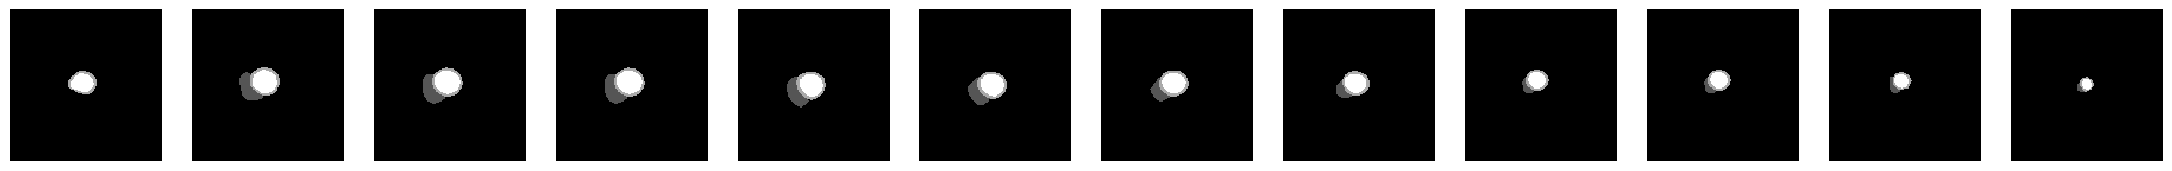

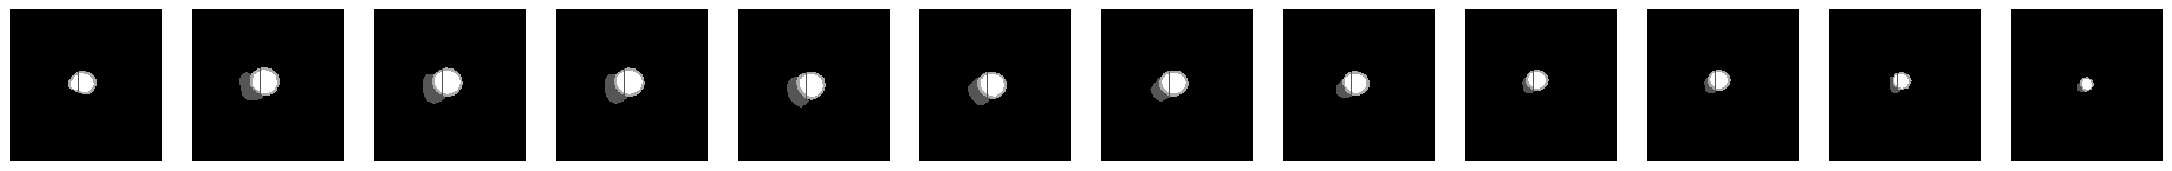

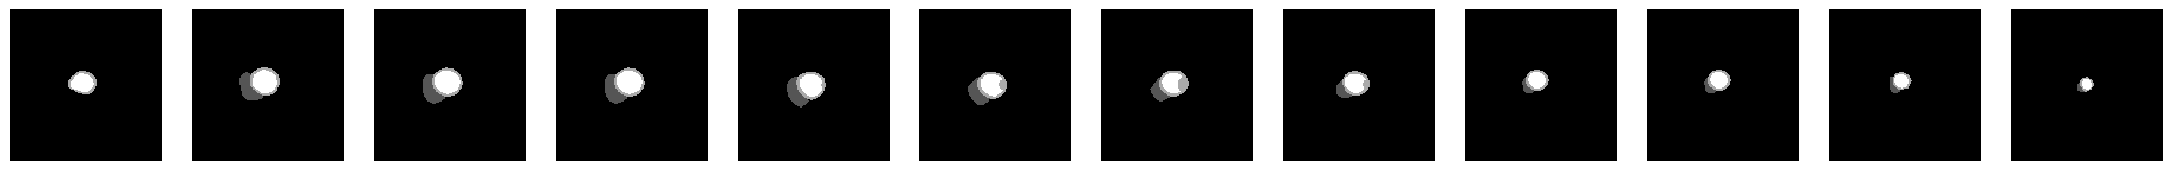

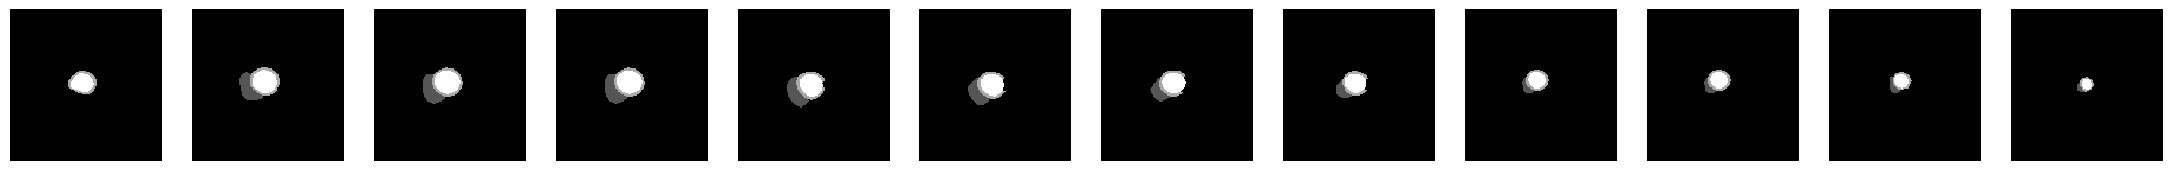

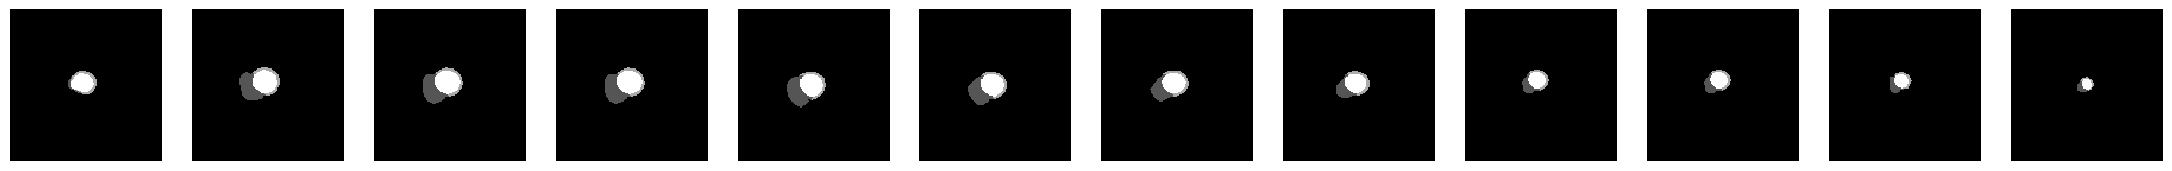

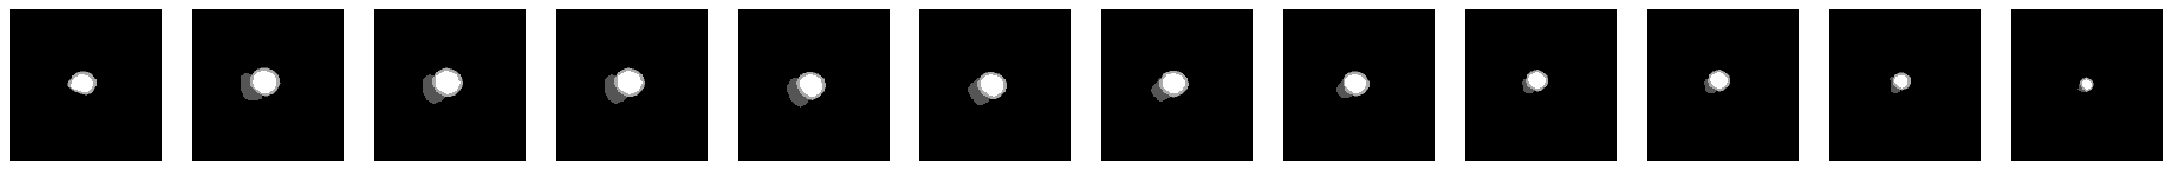

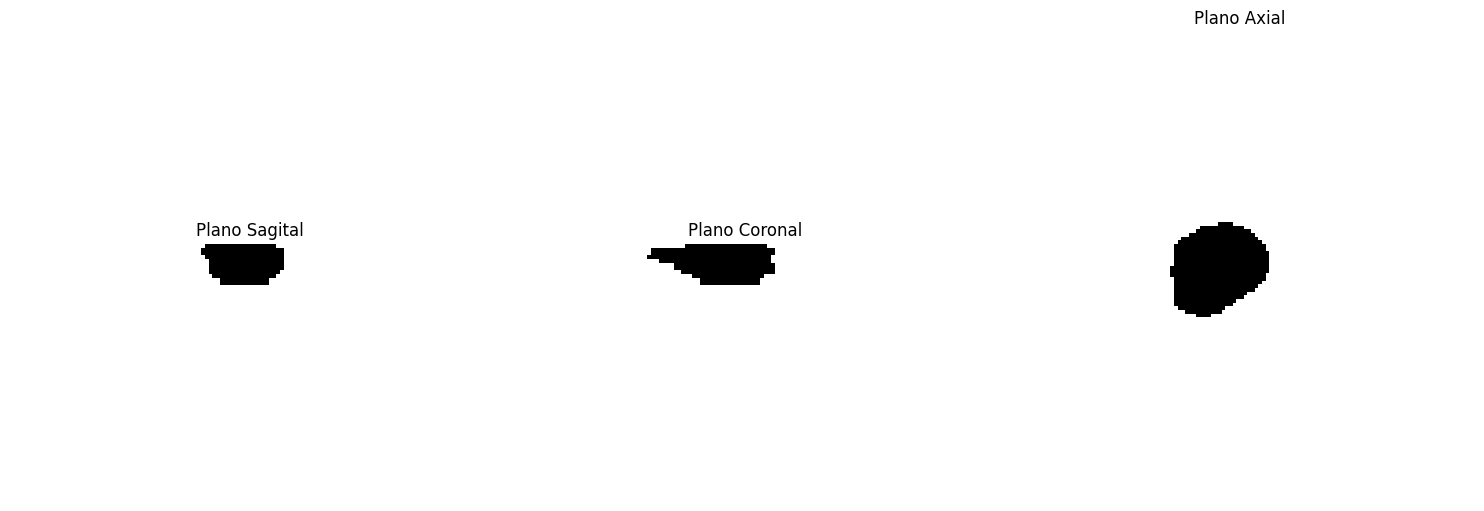

In [37]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")


width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Imagen de entrenamiento con ruido cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


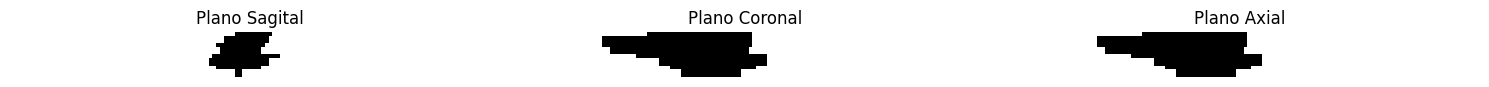

In [38]:
check_data_noise = next(iter(train_loader_noise))
image_tensor_noise = check_data_noise['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento con ruido cargada, tamaño: {image_tensor_noise.shape}")


width_idx = image_tensor_noise.size(4) // 2 # Sagittal
height_idx = image_tensor_noise.size(3) // 2 # Coronal
depth_idx = image_tensor_noise.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal_noise = image_tensor_noise[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal_noise.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal_noise = image_tensor_noise[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial_noise = image_tensor_noise[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

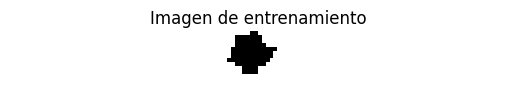

In [39]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# Convertir el tensor en una imagen para visualizar con matplotlib
# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

Tamaño de la máscara cargada: torch.Size([1, 4, 12, 128, 128])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


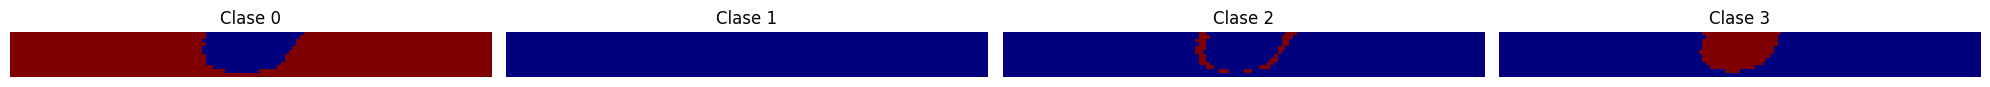

In [40]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


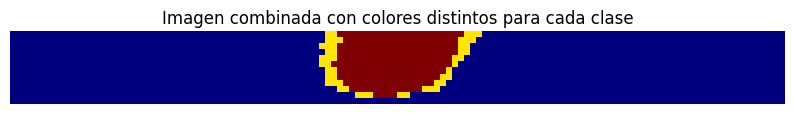

In [41]:
# slice axial del tensor de imagen
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [43]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=(1,2,2), padding=1), # [4, 12, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 6, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),      # [16, 12, 64, 64] -> [16, 12, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 12, 128, 128] -> [4, 12, 128, 128]
        )

    # def forward(self, x):
    #     encoded = self.encoder(x) # [4, 12, 128, 128] -> [1, 3, 8, 8]
    #     latent_vector = self.fc(encoded.view(encoded.size(0), -1)) # [batch_size, 64]
    #     decoded = self.decoder(latent_vector.view(encoded.size()))
    #     return decoded, latent_vector
    
    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)  # [batch_size, 1, 3, 8, 8]
        flattened = encoded.view(encoded.size(0), -1)  # Aplanamos el tensor
        latent_vector = self.fc[1](flattened)  # Extraemos el vector latente: nn.Linear(3 * 8 * 8, 64)
        fc_output = self.fc[2:](latent_vector)  # Pasamos el vector latente por las capas restantes

        # Decoder
        reshaped = fc_output.view(encoded.size())  # Ajustamos a la forma necesaria para el decoder
        decoded = self.decoder(reshaped)

        return decoded, latent_vector  # Devolvemos la salida decodificada y el vector latente
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 12, 128, 128).to(device) 
sample_output = model(sample_input)[0]
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [44]:
from torchmetrics import Metric
from torch import Tensor
import torch.nn.functional as F

class DiceCoefficient(Metric):
    def __init__(self, num_classes: int, ignore_index: int = 0, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.ignore_index = ignore_index

        self.add_state("intersection", default=torch.zeros(num_classes), dist_reduce_fx="sum")
        self.add_state("union", default=torch.zeros(num_classes), dist_reduce_fx="sum")

    def update(self, preds: Tensor, target: Tensor) -> None:
        device = preds.device

        if preds.shape[1] == self.num_classes:
            preds = F.softmax(preds, dim=1)

        if preds.dim() == 4:
            preds = F.one_hot(torch.argmax(preds, dim=1), num_classes=self.num_classes).permute(0, 4, 1, 2, 3).to(device)
        if target.dim() == 4: 
            target = F.one_hot(target, num_classes=self.num_classes).permute(0, 4, 1, 2, 3).to(device)

        for c in range(self.num_classes):
            if c == self.ignore_index:
                continue
            pred_class = preds[:, c, :, :, :]
            target_class = target[:, c, :, :, :]
            self.intersection[c] += torch.sum(pred_class * target_class)
            self.union[c] += torch.sum(pred_class) + torch.sum(target_class)

    def compute(self) -> Tensor:
        dice_per_class = (2.0 * self.intersection) / (self.union + 1e-7)
        valid_classes = [c for c in range(self.num_classes) if c != self.ignore_index]
        return dice_per_class[valid_classes].mean()

In [45]:
from torchmetrics import Metric
from torch import Tensor
import torch.nn.functional as F

class MeanSquaredError(Metric):
    def __init__(self, num_classes: int, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.add_state("sum_squared_error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: Tensor, target: Tensor) -> None:
        device = preds.device

        if preds.shape[1] == self.num_classes:
            preds = F.softmax(preds, dim=1)

        if preds.dim() == 4:
            preds = F.one_hot(torch.argmax(preds, dim=1), num_classes=self.num_classes).permute(0, 4, 1, 2, 3).to(device)
        if target.dim() == 4:
            target = F.one_hot(target, num_classes=self.num_classes).permute(0, 4, 1, 2, 3).to(device)

        squared_error = (preds - target) ** 2
        self.sum_squared_error += torch.sum(squared_error)
        self.total += target.numel()

    def compute(self) -> Tensor:
        return self.sum_squared_error / self.total

In [46]:
# from torchmetrics.segmentation import DiceScore
# import torch.nn.functional as F

# dice_score_metric = DiceScore(
#     num_classes=3,          # Número de clases (incluyendo fondo)
#     include_background=False,  # Excluir el fondo
#     average='macro'         # Opción de promediado (puede ser 'micro', 'macro', 'weighted', None)
# )

# preds = torch.randn(4, 3, 128, 128)  # Batch de 4, 3 clases, tamaño 128x128
# targets = torch.randint(0, 3, (4, 128, 128))  # Batch de etiquetas reales (índices de clases)

# preds_softmax = F.softmax(preds, dim=1)  # Convertir logits a probabilidades
# preds_argmax = preds_softmax.argmax(dim=1)  # Obtener la clase más probable

# dice_score = dice_score_metric(preds_argmax, targets)
# print("Promedio Dice por batch:", dice_score)

In [47]:
def save_latent_vectors(model, train_loader, val_loader, desc):
    train_latent_vectors = []
    val_latent_vectors = []

    with torch.no_grad():
        for batch_data in tqdm(train_loader, desc=f"Saving Train Latent Vectors ({desc})"):
            inputs = batch_data["image"].to(device)
            _, latent_vectors = model(inputs)
            train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

        for val_data in tqdm(val_loader, desc=f"Saving Validation Latent Vectors ({desc})"):
            val_inputs = val_data["image"].to(device)
            _, latent_vectors = model(val_inputs)
            val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

    train_latent_vectors = np.concatenate(train_latent_vectors, axis=0)
    val_latent_vectors = np.concatenate(val_latent_vectors, axis=0)

    return train_latent_vectors, val_latent_vectors


In [48]:
# # ORIGINAL
# import torch.nn.functional as F
# import torch.optim as optim
# from sklearn.metrics import f1_score

# model = Autoencoder().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
# criterion = nn.CrossEntropyLoss() 

# # Entrenamiento
# num_epochs = 20
# val_interval = 1
# train_loss_list = []
# val_loss_list = []
# best_val_dice = 0
# best_val_mse = float('inf') 
# best_train_latent_vectors_dice = None
# best_val_latent_vectors_dice = None
# best_train_latent_vectors_mse = None
# best_val_latent_vectors_mse = None

# num_classes = 4
# dice_metric = DiceCoefficient(num_classes=num_classes).to(device)
# mse_metric = MeanSquaredError(num_classes=num_classes).to(device)

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0

#     dice_metric.reset()
#     mse_metric.reset()

#     for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
#         inputs = batch_data["image"].to(device)
#         outputs, train_latent_vectors_output = model(inputs)

#         loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#         dice_metric.update(outputs, inputs)
#         mse_metric.update(outputs, inputs)

#     avg_train_loss = train_loss / len(train_loader)
#     avg_train_dice = dice_metric.compute().item()
#     avg_train_mse = mse_metric.compute().item()

#     train_loss_list.append(avg_train_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train MSE: {avg_train_mse:.4f}")

#     # Validación
#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         val_loss = 0

#         dice_metric.reset()
#         mse_metric.reset()

#         with torch.no_grad():
#             for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
#                 val_inputs = val_data["image"].to(device)
#                 val_outputs, val_latent_vectors_output = model(val_inputs)

#                 val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

#                 dice_metric.update(val_outputs, val_inputs)
#                 mse_metric.update(val_outputs, val_inputs)

#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_dice = dice_metric.compute().item()
#         avg_val_mse = mse_metric.compute().item()

#         val_loss_list.append(avg_val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}, Validation MSE: {avg_val_mse:.4f}")

#         if avg_val_dice > best_val_dice:
#             best_val_dice = avg_val_dice
#             best_train_latent_vectors_dice, best_val_latent_vectors_dice = save_latent_vectors(model, train_loader, val_loader, "Dice")

#         if avg_val_mse < best_val_mse:
#             best_val_mse = avg_val_mse
#             best_train_latent_vectors_mse, best_val_latent_vectors_mse = save_latent_vectors(model, train_loader, val_loader, "MSE")

# last_train_latent_vectors, last_val_latent_vectors = save_latent_vectors(model, train_loader, val_loader, "Last Epoch")

In [58]:
from torchmetrics.segmentation import DiceScore, HausdorffDistance
import torch.nn.functional as F
import torch.optim as optim

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()

num_classes = 4
dice_score_metric = DiceScore(num_classes=num_classes, include_background=False, average='macro', input_format='one-hot')
hausdorff_distance = HausdorffDistance(num_classes=num_classes, include_background=False, input_format='one-hot', distance_metric="euclidean")

num_epochs = 20
val_interval = 1
train_loss_list = []
val_loss_list = []

best_val_dice = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_dice_scores = []
    train_hs_scores = []

    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        
        inputs = batch_data["image"].to(device)

        outputs, _ = model(inputs)

        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        preds_one_hot = F.one_hot(preds, num_classes=num_classes).permute(0, 4, 1, 2, 3)
        targets_one_hot = F.one_hot(torch.argmax(inputs, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3)

        dice_score = dice_score_metric(preds_one_hot, targets_one_hot)
        train_dice_scores.append(dice_score)
        
        hausdorff_distance_score = hausdorff_distance(preds_one_hot, targets_one_hot)
        train_hs_scores.append(hausdorff_distance_score)
        
    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = sum(train_dice_scores) / len(train_dice_scores)
    avg_train_hs = sum(train_hs_scores) / len(train_hs_scores)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train Dice: {avg_train_hs:.4f}")

    # Validación
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        val_dice_scores = []


        with torch.no_grad():
            for val_data in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                val_inputs = val_data["image"].to(device)
                val_outputs, _ = model(val_inputs)

                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()

                val_preds = torch.argmax(F.softmax(val_outputs, dim=1), dim=1)

                val_preds_one_hot = F.one_hot(val_preds, num_classes=num_classes).permute(0, 4, 1, 2, 3)
                val_targets_one_hot = F.one_hot(torch.argmax(val_inputs, dim=1), num_classes=num_classes).permute(0, 4, 1, 2, 3)

                val_dice_score = dice_score_metric(val_preds_one_hot, val_targets_one_hot)
                val_dice_scores.append(val_dice_score)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = sum(val_dice_scores) / len(val_dice_scores)

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}")

Epoch 1/20 [Train]:   0%|          | 0/200 [00:00<?, ?it/s]


ValueError: Expected argument `x` to be of rank 2 but got rank `3`.

In [48]:
val_outputs.shape, val_inputs.shape

(torch.Size([1, 4, 12, 128, 128]), torch.Size([1, 4, 12, 128, 128]))

In [49]:
val_outputs[0,0,0,0,:]

metatensor([4.3076, 4.6768, 4.5578, 3.4805, 3.6734, 2.8662, 2.7689, 2.3867, 2.7563,
        2.5690, 2.7850, 2.6189, 2.9324, 2.5490, 2.5615, 2.3717, 2.5924, 2.3770,
        2.3408, 2.1863, 2.2438, 2.0289, 2.0072, 1.9540, 2.0786, 1.9931, 2.0394,
        1.9550, 1.9896, 1.8417, 1.8967, 1.8831, 1.9956, 1.8747, 1.8951, 1.8813,
        2.0340, 1.9454, 2.0772, 2.1447, 2.4419, 2.4313, 2.6797, 2.6993, 3.0931,
        2.9625, 3.2722, 3.1589, 3.5781, 3.2334, 3.3755, 3.1653, 3.6015, 3.2981,
        3.5441, 3.3759, 3.9609, 3.7141, 4.1548, 3.8991, 4.6600, 4.2387, 4.7989,
        4.4058, 5.2338, 4.5839, 5.0260, 4.4535, 5.2284, 4.5035, 5.0192, 4.3686,
        5.0581, 4.2546, 4.5956, 3.7526, 4.0392, 3.2752, 3.5447, 3.0139, 3.4372,
        3.0004, 3.2542, 2.8511, 3.1905, 2.7104, 2.7982, 2.4904, 2.8242, 2.5697,
        2.7037, 2.5133, 2.7499, 2.4234, 2.4901, 2.3641, 2.6955, 2.5650, 2.7389,
        2.6481, 2.9740, 2.7654, 2.9828, 2.8521, 3.2628, 3.0322, 3.2773, 3.1498,
        3.6958, 3.4245, 3.7875, 3.62

In [50]:
print(f"Train Latent Vector Shape (last epoch): {last_train_latent_vectors.shape}")
print(f"Train Latent Vector Shape (best epoch dice): {best_train_latent_vectors_dice.shape}")
print(f"Train Latent Vector Shape (best epoch mse): {best_train_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape (last epoch): {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_mse.shape}")
print(last_train_latent_vectors[0].shape)
print(last_val_latent_vectors[0].shape)
print(best_train_latent_vectors_dice[0].shape)
print(best_val_latent_vectors_dice[0].shape)
print(best_train_latent_vectors_mse[0].shape)
print(best_val_latent_vectors_mse[0].shape)

Train Latent Vector Shape (last epoch): (200, 64)
Train Latent Vector Shape (best epoch dice): (200, 64)
Train Latent Vector Shape (best epoch mse): (200, 64)
Validation Latent Vector Shape (last epoch): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


In [51]:
# # Guardar los vectores latentes de la mejor época
# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'best_train_latent_vectors.tsv'), best_train_latent_vectors, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'best_val_latent_vectors.tsv'), best_val_latent_vectors, delimiter='\t')

# print(f"Vectores latentes de la mejor época guardados en {output_dir}")

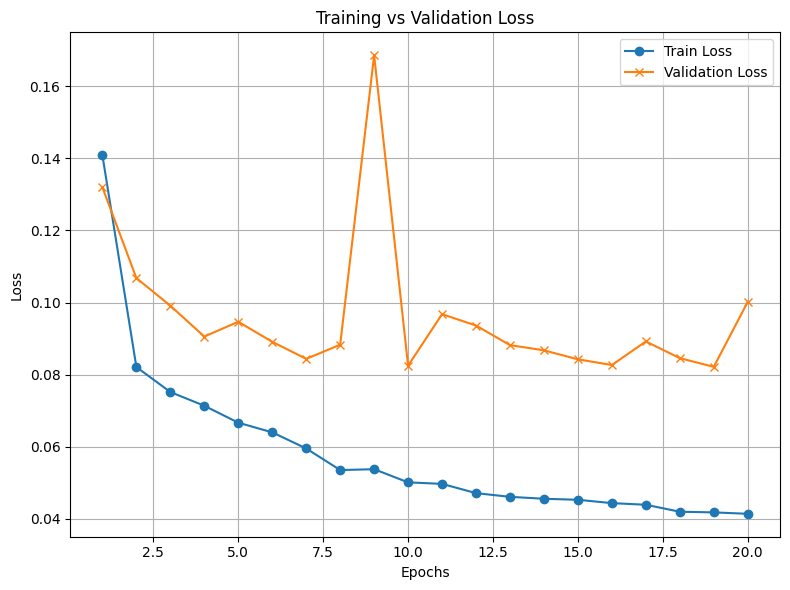

In [52]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
def visualize_axial_reconstruction(model, data_loader, device):
    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.eval()
    with torch.no_grad():
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        outputs, _ = model(inputs)

        postprocess_input = postprocess_transform({"image": inputs})["image"]
        postprocess_output = postprocess_transform({"image": outputs})["image"]

        print(f"Input shape: {inputs.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Postprocess output shape: {postprocess_output.shape}")

        slice_idx = postprocess_output.shape[2] // 2  # Índice de la rebanada central
        
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Reconstrucción")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])


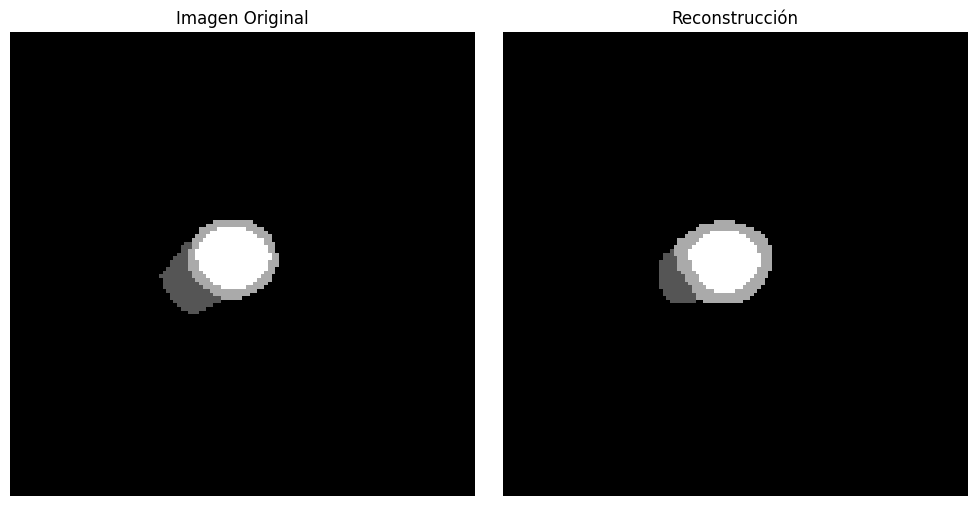

In [54]:
visualize_axial_reconstruction(model, val_loader, device)

In [55]:
torch.save(model.state_dict(), 'autoencoder_model.pth')

In [56]:
train_latent_vectors_noise = []
val_latent_vectors_noise = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_noise, desc="Encoding Noisy Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_noise.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_noise, desc="Encoding Noisy Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_noise.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_noise = np.concatenate(train_latent_vectors_noise, axis=0)
val_latent_vectors_noise = np.concatenate(val_latent_vectors_noise, axis=0)  

print(f"Train Latent Vectors Shape (Noise): {train_latent_vectors_noise.shape}")
print(f"Validation Latent Vectors Shape (Noise): {val_latent_vectors_noise.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Noisy Train Images:   0%|          | 0/200 [00:00<?, ?it/s]

Encoding Noisy Validation Images: 100%|██████████| 100/100 [00:04<00:00, 24.41it/s]

Train Latent Vectors Shape (Noise): (200, 64)
Validation Latent Vectors Shape (Noise): (100, 64)


In [57]:
train_latent_vectors_sphere = []
val_latent_vectors_sphere = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere, desc="Encoding Sphere Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_sphere.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere, desc="Encoding Sphere Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_sphere.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere = np.concatenate(train_latent_vectors_sphere, axis=0)
val_latent_vectors_sphere = np.concatenate(val_latent_vectors_sphere, axis=0)  

print(f"Train Latent Vectors Shape (Sphere): {train_latent_vectors_sphere.shape}")
print(f"Validation Latent Vectors Shape (Sphere): {val_latent_vectors_sphere.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere Validation Images: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]

Train Latent Vectors Shape (Sphere): (200, 64)
Validation Latent Vectors Shape (Sphere): (100, 64)


In [58]:
train_latent_vectors_sphere_2 = []
val_latent_vectors_sphere_2 = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere_2, desc="Encoding Sphere 2 Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_sphere_2.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere_2, desc="Encoding Sphere 2 Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_sphere_2.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere_2 = np.concatenate(train_latent_vectors_sphere_2, axis=0)
val_latent_vectors_sphere_2 = np.concatenate(val_latent_vectors_sphere_2, axis=0)  

print(f"Train Latent Vectors Shape (Sphere 2): {train_latent_vectors_sphere_2.shape}")
print(f"Validation Latent Vectors Shape (Sphere 2): {val_latent_vectors_sphere_2.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere 2 Validation Images: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]

Train Latent Vectors Shape (Sphere 2): (200, 64)
Validation Latent Vectors Shape (Sphere 2): (100, 64)


In [59]:
train_latent_vectors_sphere_3 = []
val_latent_vectors_sphere_3 = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_sphere_3, desc="Encoding Sphere 3 Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_sphere_3.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_sphere_3, desc="Encoding Sphere 3 Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_sphere_3.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_sphere_3 = np.concatenate(train_latent_vectors_sphere_3, axis=0)
val_latent_vectors_sphere_3 = np.concatenate(val_latent_vectors_sphere_3, axis=0)  

print(f"Train Latent Vectors Shape (Sphere 3): {train_latent_vectors_sphere_3.shape}")
print(f"Validation Latent Vectors Shape (Sphere 3): {val_latent_vectors_sphere_3.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Sphere 3 Validation Images: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]

Train Latent Vectors Shape (Sphere 3): (200, 64)
Validation Latent Vectors Shape (Sphere 3): (100, 64)


In [60]:
train_latent_vectors_elongated = []
val_latent_vectors_elongated = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_elongated, desc="Encoding Elongated Train Images"):
        elongated_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_elongated.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_elongated, desc="Encoding Elongated Validation Images"):
        elongated_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_elongated.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_elongated = np.concatenate(train_latent_vectors_elongated, axis=0)
val_latent_vectors_elongated = np.concatenate(val_latent_vectors_elongated, axis=0)  

print(f"Train Latent Vectors Shape (Elongation): {train_latent_vectors_elongated.shape}")
print(f"Validation Latent Vectors Shape (Elongation): {val_latent_vectors_elongated.shape}")
# print(f"Validation Latent Vectors (Elongation): {val_latent_vectors_noise[0]}")

Encoding Elongated Validation Images: 100%|██████████| 100/100 [00:04<00:00, 22.04it/s]

Train Latent Vectors Shape (Elongation): (200, 64)
Validation Latent Vectors Shape (Elongation): (100, 64)


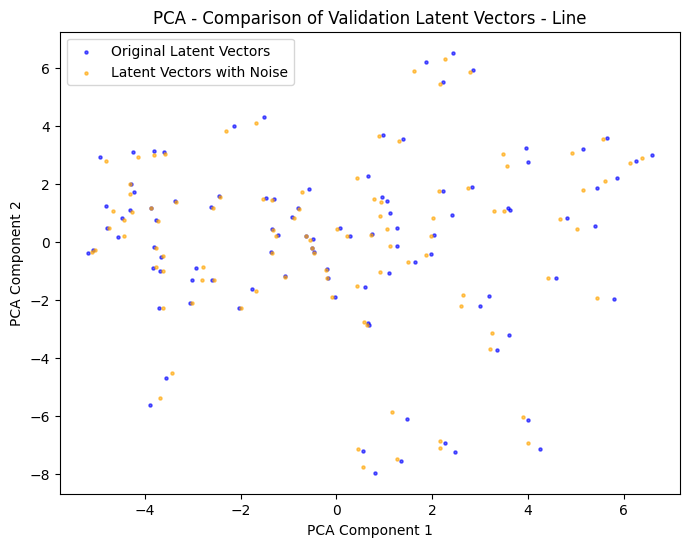

In [61]:
from sklearn.decomposition import PCA
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Line')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

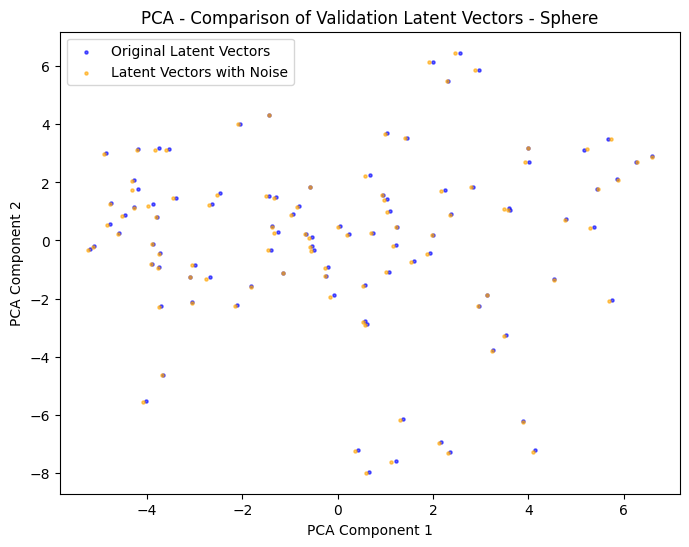

In [62]:
from sklearn.decomposition import PCA
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

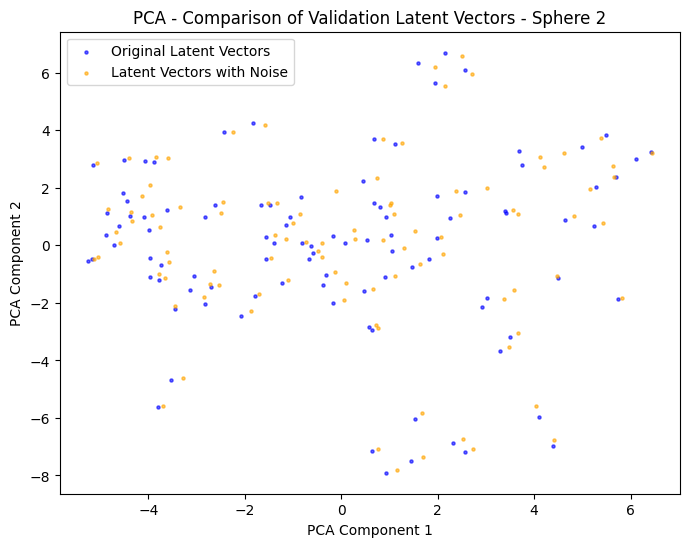

In [63]:
from sklearn.decomposition import PCA
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere 2')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

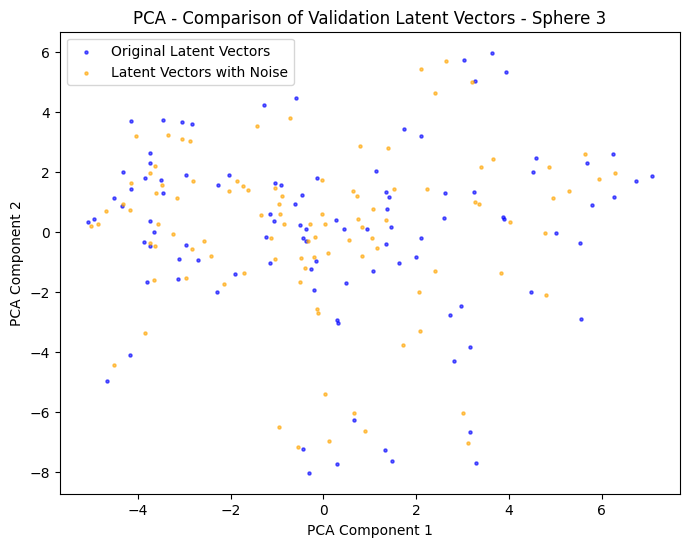

In [ ]:
from sklearn.decomposition import PCA
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors - Sphere 3')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

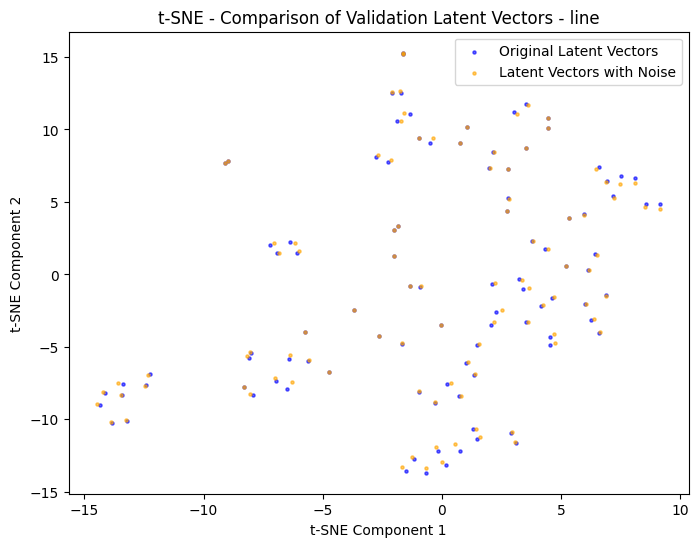

In [65]:
# t-sne
from sklearn.manifold import TSNE
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors - line')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

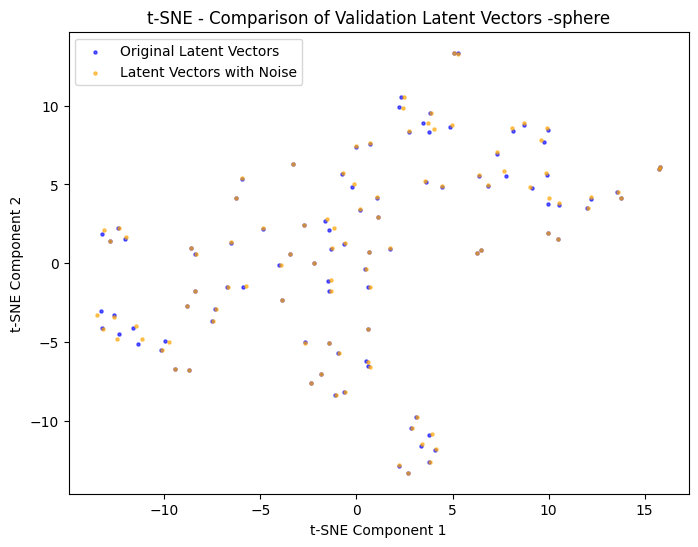

In [66]:
# t-sne
from sklearn.manifold import TSNE
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

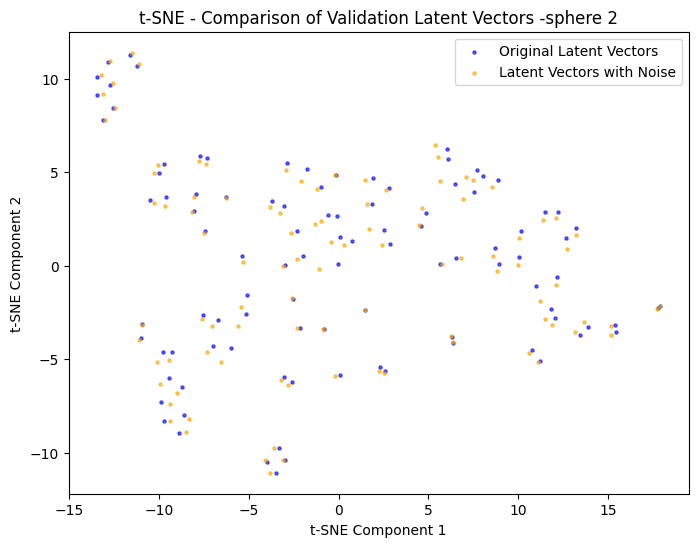

In [67]:
# t-sne
from sklearn.manifold import TSNE
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere 2')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

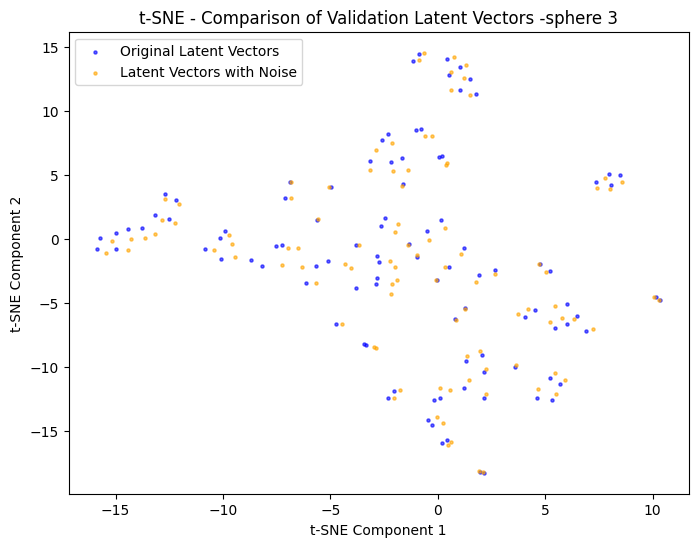

In [ ]:
# t-sne
from sklearn.manifold import TSNE
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors -sphere 3')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


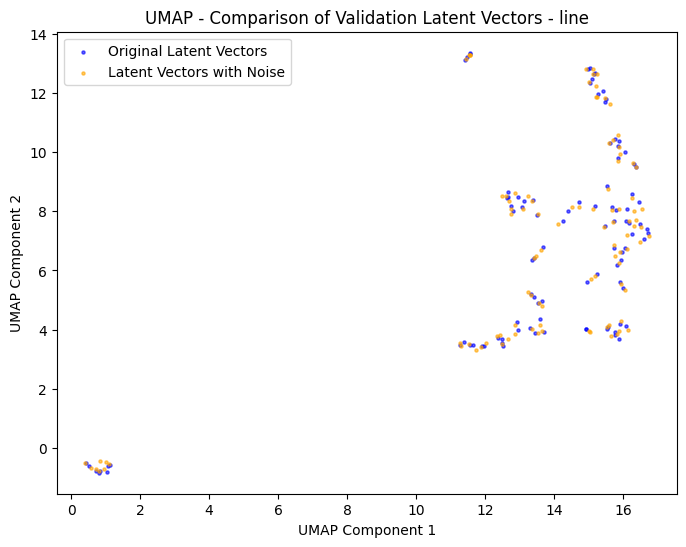

In [69]:
# UMAP
import umap
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - line')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


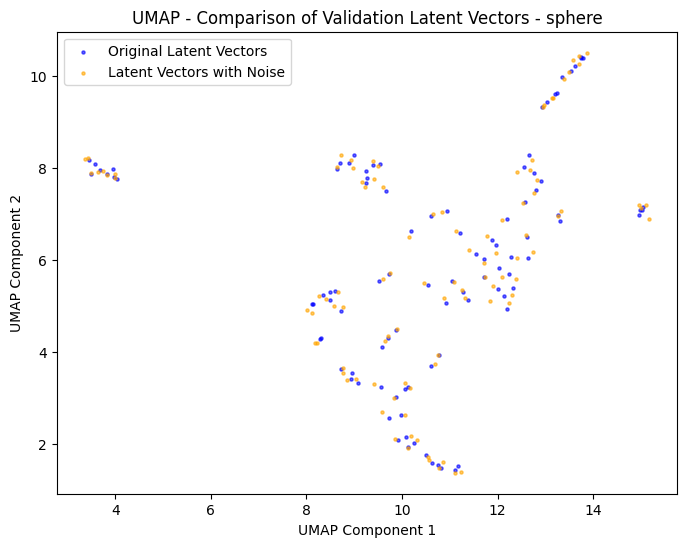

In [70]:
# UMAP
import umap
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


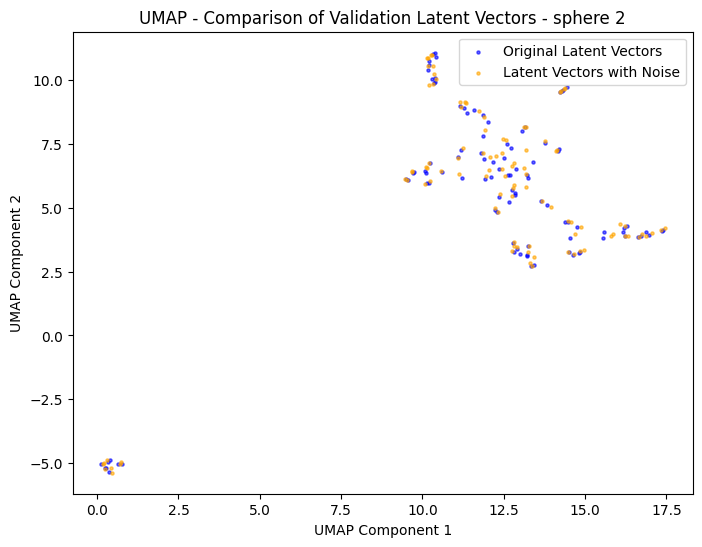

In [71]:
# Usando UMAP
import umap
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_2], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere 2')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


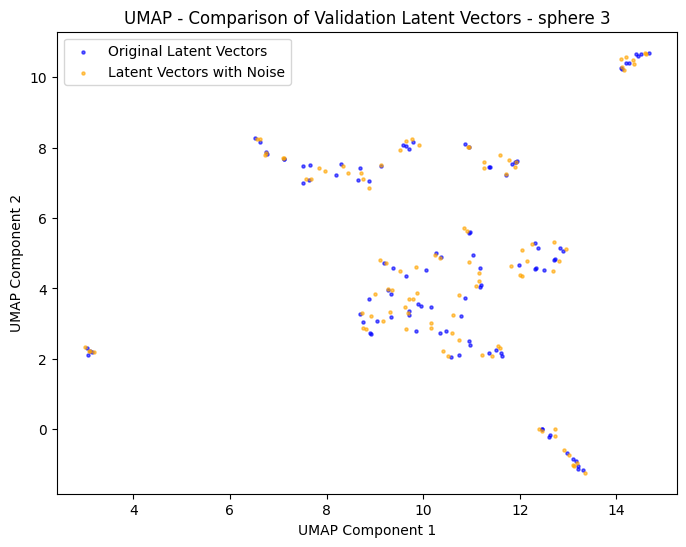

In [ ]:
# Usando UMAP
import umap
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_sphere_3], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors - sphere 3')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

EUCLIDEAN DISTANCE

In [73]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with noise

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_noise[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.2346878  0.22177105 0.10785063 0.3073553  0.12788516 0.1280339
 0.38795677 0.31266686 0.2528949  0.3025176  0.10826963 0.23537152
 0.09440929 0.22581415 0.43234876 0.1959186  0.29140252 0.11000389
 0.48684874 0.1837469  0.60489357 0.67886555 0.40847462 0.15922262
 0.27967042 0.29687285 0.5214028  0.7334884  0.39695403 0.16433436
 0.33027637 0.356043   0.48753574 0.18770492 0.2799748  0.11562847
 0.36291286 0.3522669  0.14742818 0.14087802 0.2503287  0.06294809
 0.4111441  0.5877426  0.2908694  0.1615063  0.4235665  0.14369154
 0.33107597 0.12094358 0.08904016 0.10506201 0.13731015 0.49303475
 0.11629243 0.3001663  0.11925052 0.5500125  0.38416263 0.39652297
 0.31940055 0.1327888  0.11196302 0.12901972 0.18206368 0.4631233
 0.20406957 0.11085122 0.2590606  0.2545342  0.37265632 0.36053354
 0.38188365 0.16089354 0.14375764 0.3636649  0.52844065 0.3545836
 0.018

In [ ]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere: {val_latent_vectors_sphere.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.11292139 0.07632462 0.27931327 0.11458872 0.12016197 0.06599011
 0.2007983  0.01153548 0.14036873 0.04070088 0.23381324 0.22508635
 0.273832   0.15614916 0.09738403 0.04017179 0.19166468 0.16310173
 0.16228211 0.06945864 0.15276225 0.         0.13237578 0.05786452
 0.24831553 0.22221647 0.0510034  0.         0.20427246 0.11499385
 0.09778032 0.03659731 0.13261251 0.11191858 0.21573924 0.11895077
 0.11022301 0.05732005 0.05793749 0.0696539  0.24802184 0.1056563
 0.276968   0.21220447 0.08652307 0.04177495 0.06091724 0.01108727
 0.13236645 0.05843448 0.12997474 0.1148646  0.12904939 0.10302151
 0.20038523 0.14019863 0.13515761 0.04504846 0.09784892 0.02741733
 0.1976852  0.1933502  0.15846802 0.14022231 0.12436553 0.09520913
 0.10307156 0.08000562 0.10625816 0.10810743 0.14409843 0.08247926
 0.20645423 0.26701418 0.13393916 0.04043796 0.21422541 0.10845868
 0.

In [ ]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere 2: {val_latent_vectors_sphere_2.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 2: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.38385016 0.42327526 0.5302503  1.0737503  0.77315176 0.94547105
 0.75146073 1.3965274  0.43243188 0.8106036  0.43638486 0.549363
 0.48360354 0.6448203  0.33775878 0.5032741  0.46596324 0.8516551
 0.46583533 0.8001343  1.0762435  1.5494864  0.31937358 0.56722766
 0.69674873 0.9534059  1.1306076  1.041304   0.37153062 0.61074436
 0.39765108 0.66352266 0.4727566  0.50235844 0.5437054  0.6121594
 0.48221105 0.5312767  0.32053307 0.40040138 0.76107347 1.2564305
 0.7998664  0.84679556 0.65356827 1.0120357  0.3592992  0.48311454
 0.38222906 0.5760696  0.24561554 0.50526214 0.3055529  0.4544661
 0.40539825 0.8344484  0.4108231  0.61716276 0.35750607 0.50516707
 0.45320156 0.4597863  0.39222944 0.4023649  0.4109654  0.37485242
 0.56458724 0.83861834 0.3408605  0.5169005  0.30349645 0.44611025
 0.60167485 0.564327   0.782479   1.0551716  0.3913334  0.7527298
 0.3718

In [76]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Sphere 3: {val_latent_vectors_sphere_3.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 3: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.6590511  0.73820853 0.6475185  0.8037191  1.376128   1.2060342
 1.8067284  1.4112482  0.9902272  0.959086   0.91408205 0.9930758
 0.64736974 0.85380673 1.2892536  1.0913185  1.2293026  1.3533276
 0.9854792  1.2392286  1.3291119  1.0778388  1.21782    1.0549685
 1.22215    1.253263   1.2656448  1.6431993  0.98469317 0.9790332
 1.1994457  1.0325562  1.5756598  1.8334411  1.3295878  1.2612463
 0.6490037  0.82338864 1.1359476  1.5082413  1.1103516  1.2413013
 1.3653445  1.3023009  1.0306823  1.0196888  1.2588732  1.5314169
 0.68577313 0.9708819  0.5070349  0.6087556  1.0852454  1.2492406
 0.90898806 1.1671047  1.3935101  1.5730412  1.3725692  1.312512
 0.8735717  0.99052954 1.2236772  1.2262741  1.5088156  1.4581459
 0.891037   0.97828877 1.1074843  1.0680184  1.095557   1.1038623
 1.1735839  1.0330111  1.2001133  1.0359838  0.77991074 1.2248064
 0.6889917  0.

In [ ]:
# Euclidean distance between the latent vectors of the last epoch and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Elongated: {val_latent_vectors_elongated.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Elongated: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.2317014  0.25103286 0.18388915 0.15566315 0.29176015 0.31274956
 0.3822443  0.35813946 0.2895592  0.26941416 0.30151394 0.3060944
 0.3003125  0.26081258 0.314867   0.26093864 0.27268043 0.3310929
 0.32665724 0.34147537 0.26525062 0.24171203 0.26511592 0.27443558
 0.39820188 0.39589742 0.37128833 0.34845275 0.36891282 0.29084548
 0.35211083 0.3290728  0.41529277 0.45848653 0.30628493 0.34190094
 0.29244113 0.28264493 0.3081005  0.2731668  0.33367795 0.31839654
 0.346783   0.2833672  0.35196033 0.3380051  0.34434754 0.33877322
 0.29135683 0.24679679 0.3049701  0.28691074 0.38627803 0.40195078
 0.3771153  0.3350616  0.3073015  0.3236981  0.338755   0.3369312
 0.31208944 0.30303776 0.41023394 0.40109807 0.3549331  0.33019778
 0.254475   0.18350519 0.23776105 0.21401154 0.3347691  0.3370298
 0.27903295 0.21853258 0.25641888 0.266576   0.27383348 0.29243016
 0.

In [78]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



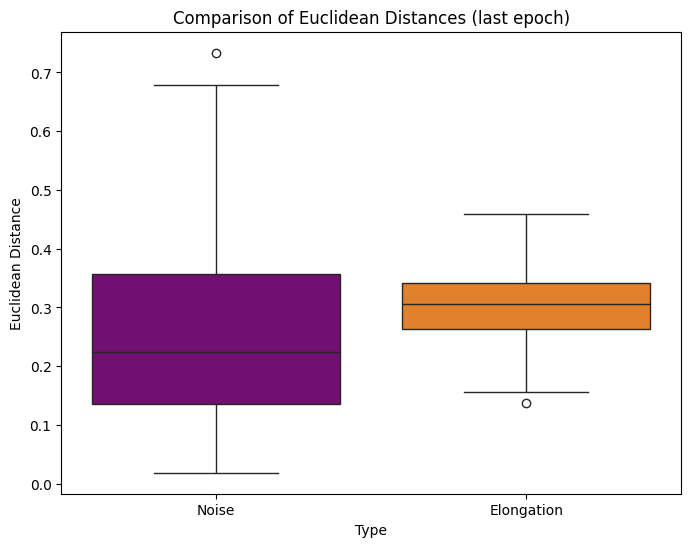

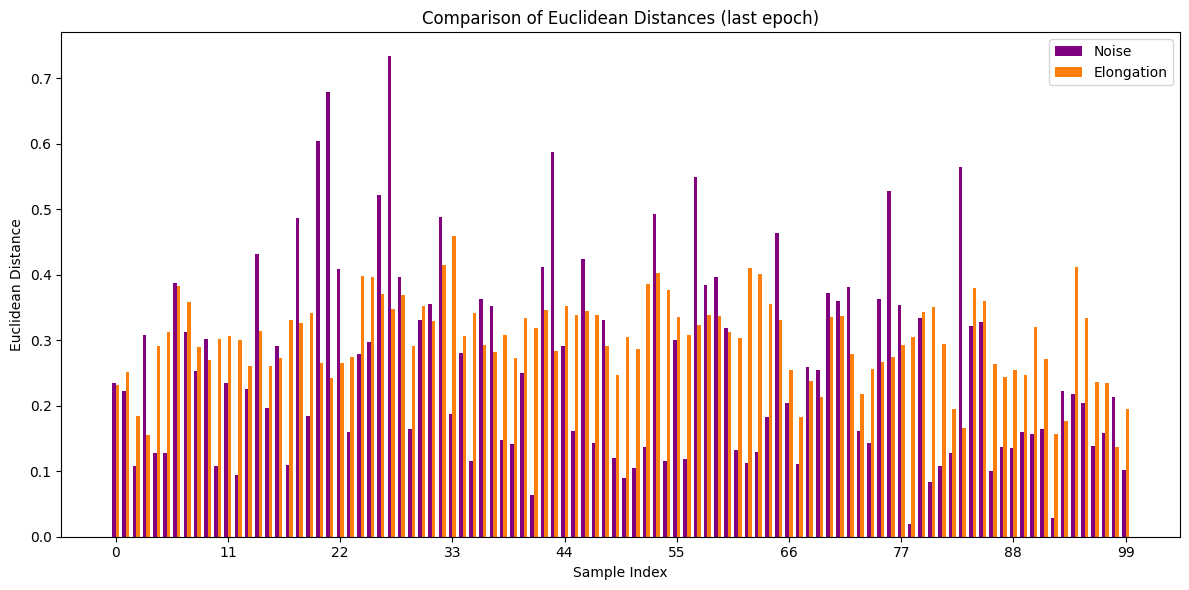

In [ ]:
euclidean_distances_noise = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise) + list(euclidean_distances_elongated),
    'Type': ['Noise'] * len(euclidean_distances_noise) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

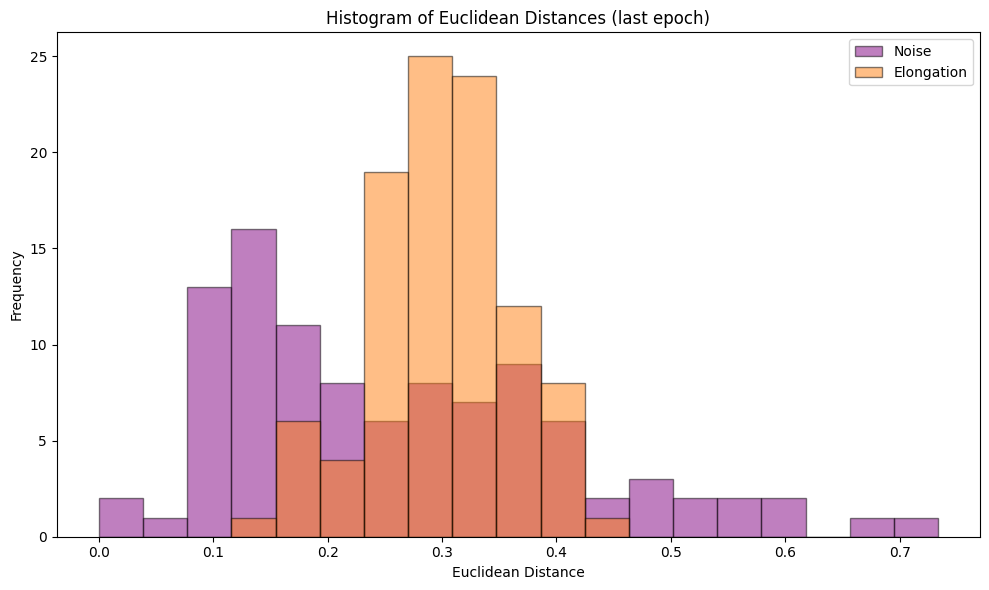

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

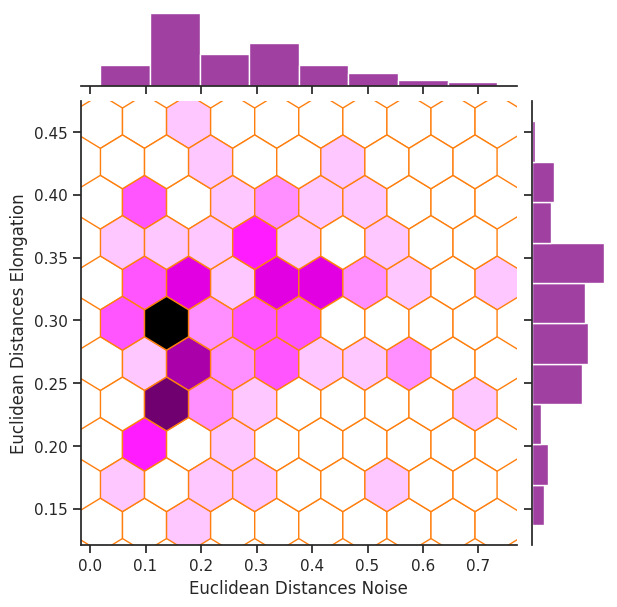

In [ ]:
x = euclidean_distances_noise
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#800080") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Noise')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



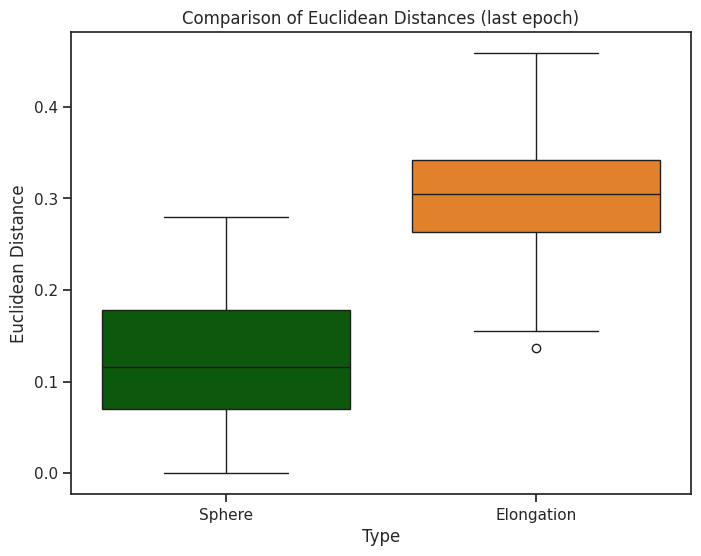

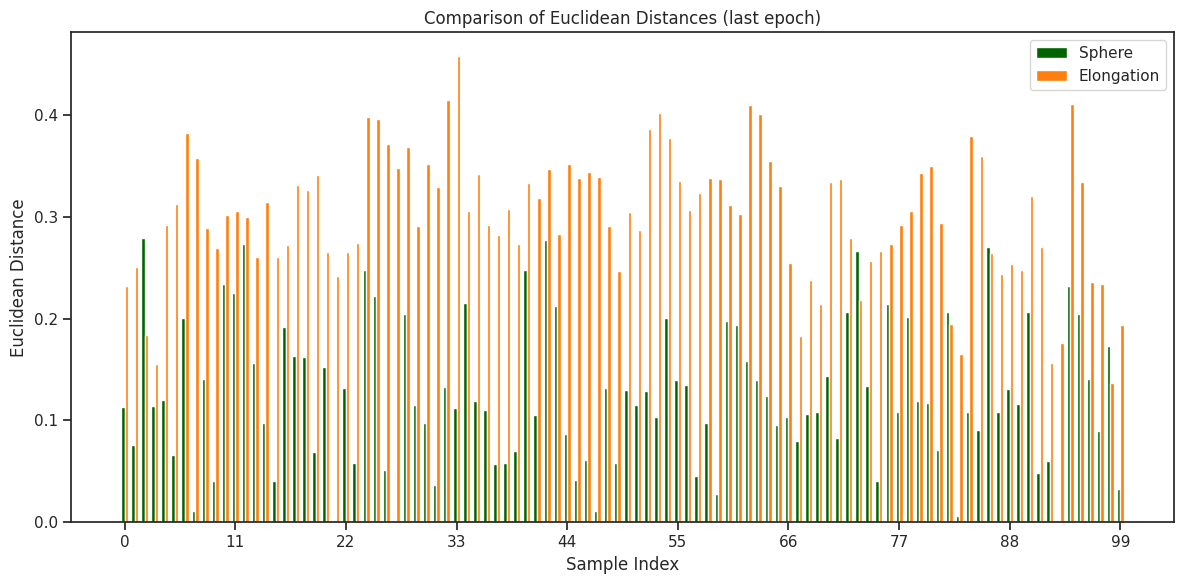

In [ ]:
euclidean_distances_sphere = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere) + list(euclidean_distances_elongated),
    'Type': ['Sphere'] * len(euclidean_distances_sphere) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

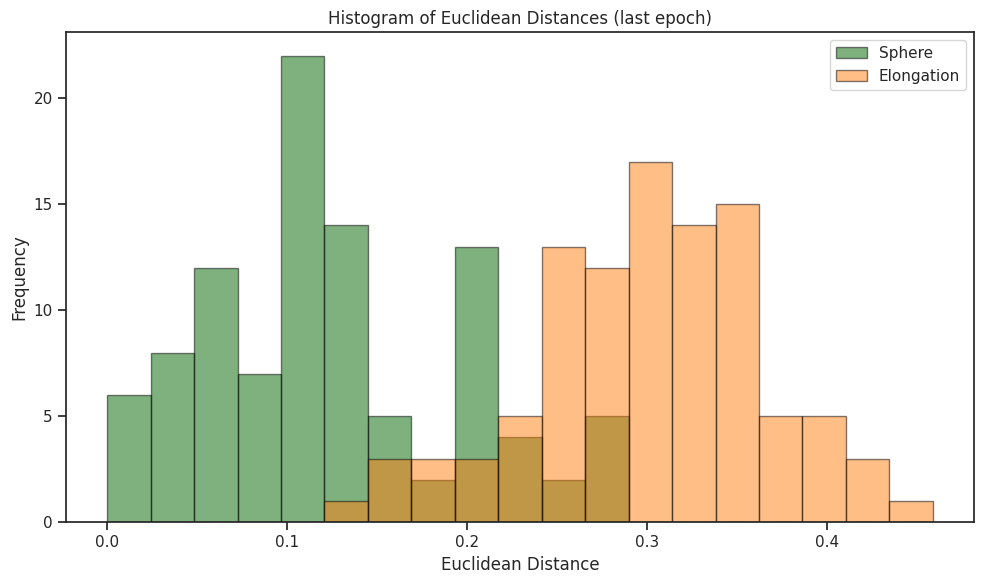

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

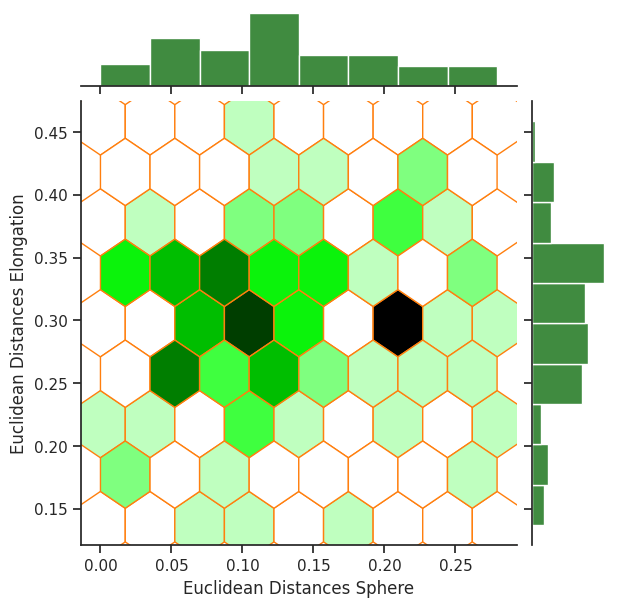

In [ ]:
x = euclidean_distances_sphere
y = euclidean_distances_elongated

sns.set_theme(style="ticks")

# Crear el gráfico conjunto con colores específicos
g = sns.jointplot(x=x, y=y, kind="hex", color="#006400") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")

plt.xlabel('Euclidean Distances Sphere')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



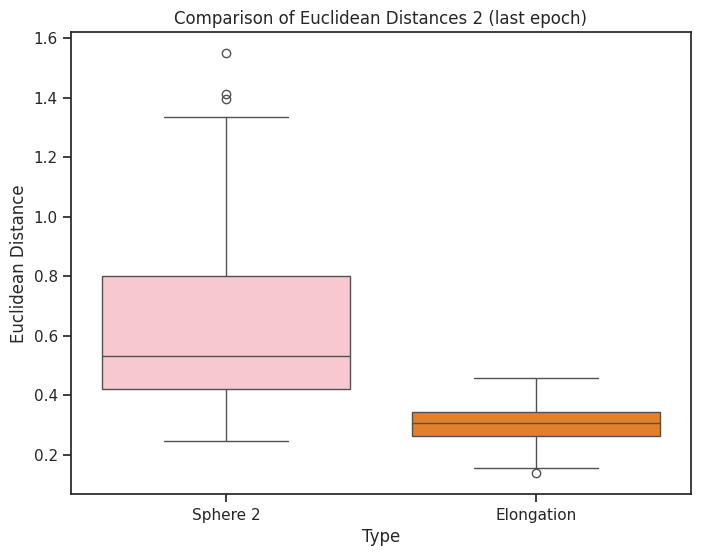

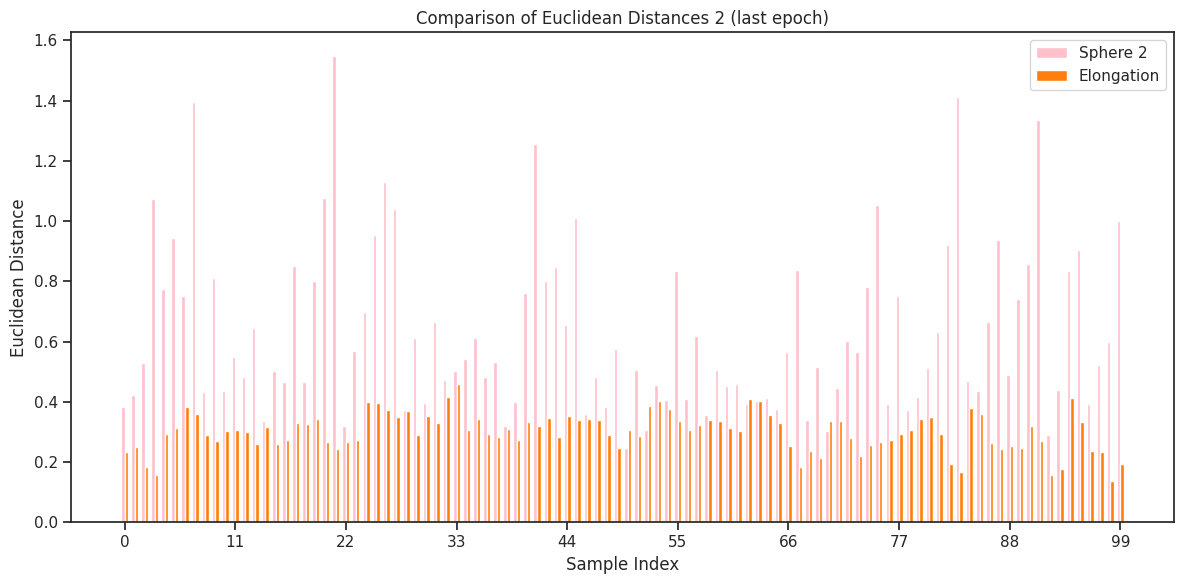

In [ ]:
euclidean_distances_sphere_2 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2) + list(euclidean_distances_elongated),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere 2": "#FFC0CB", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances 2 (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_2, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances 2 (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

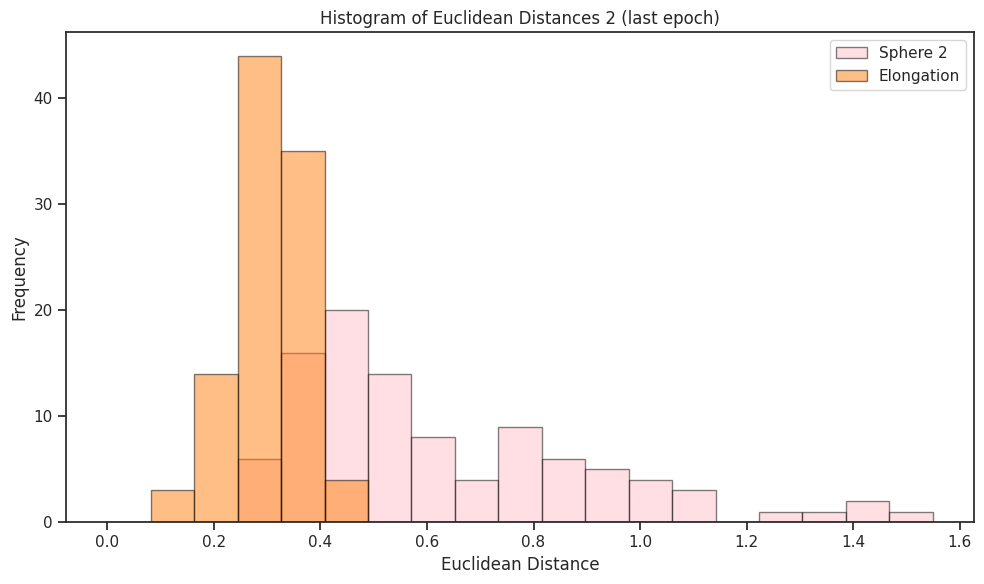

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere_2), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2, bins=bins, alpha=0.5, label='Sphere 2', color='#FFC0CB', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances 2 (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

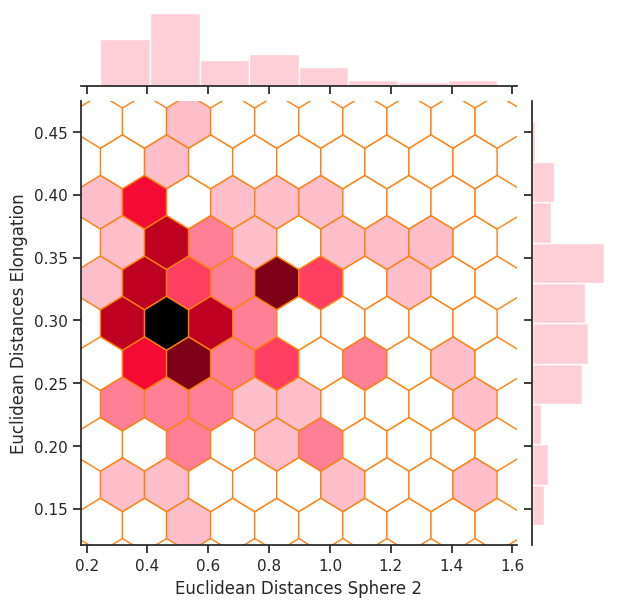

In [ ]:
x = euclidean_distances_sphere_2
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#FFC0CB") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 2')
plt.ylabel('Euclidean Distances Elongation')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



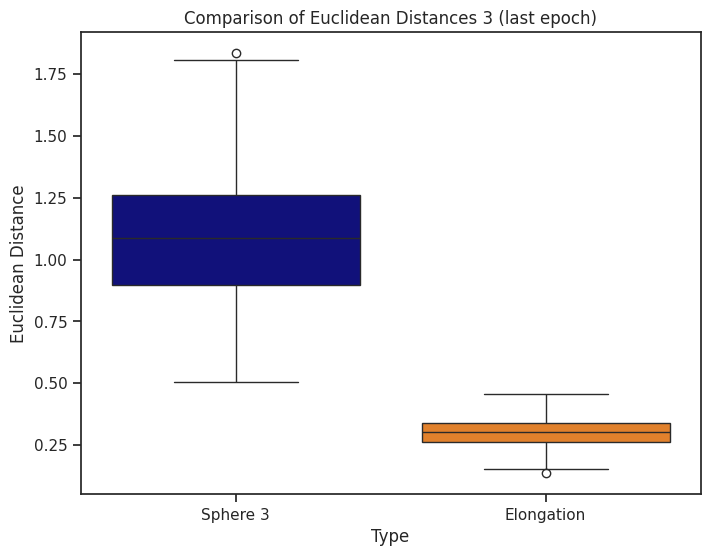

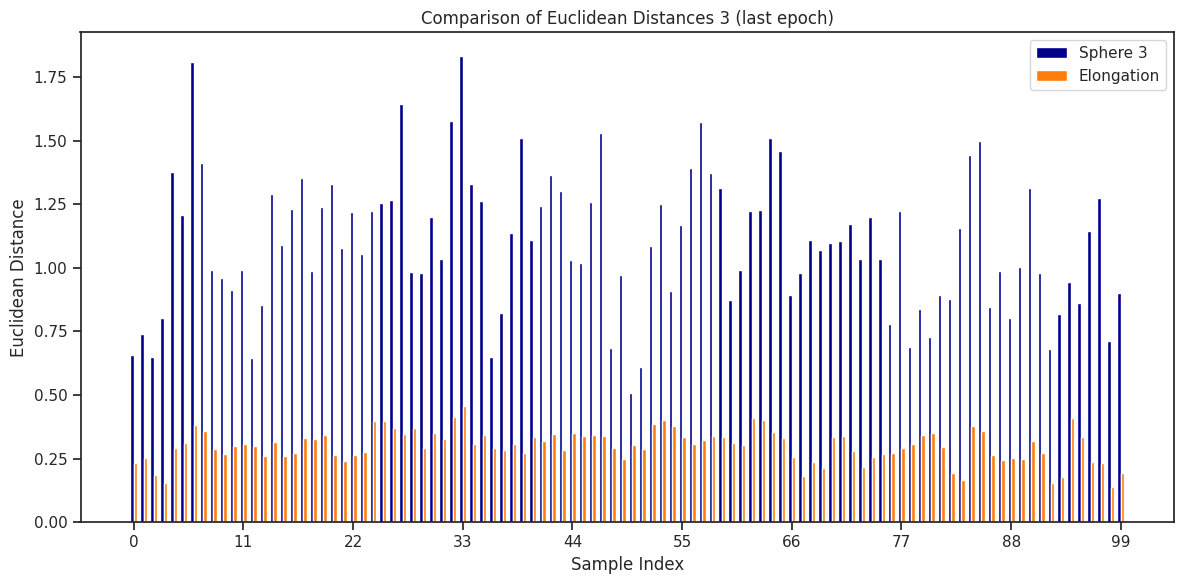

In [ ]:
euclidean_distances_sphere_3 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3) + list(euclidean_distances_elongated),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3) + ['Elongation'] * len(euclidean_distances_elongated)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances 3 (last epoch)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_3, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances 3 (last epoch)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

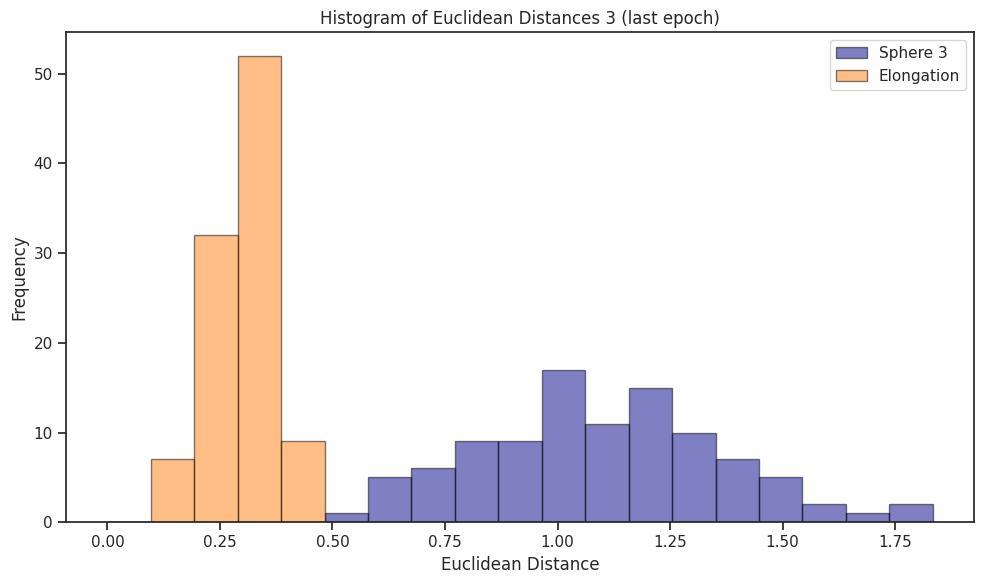

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_sphere_3), np.max(euclidean_distances_elongated)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3, bins=bins, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances 3 (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()

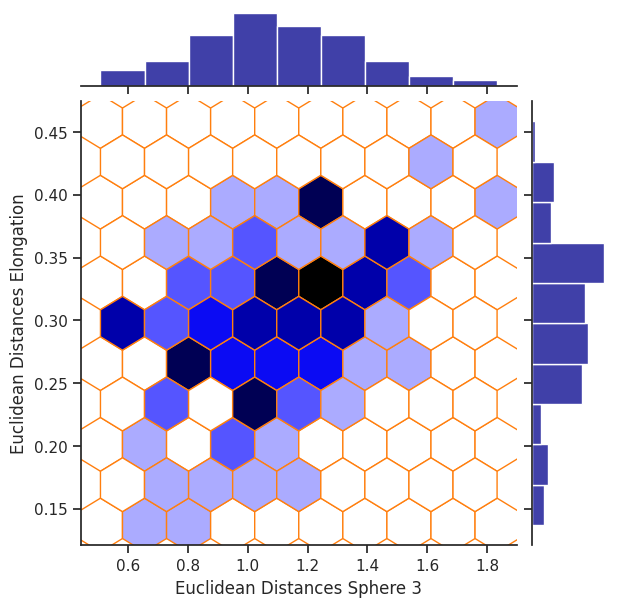

In [ ]:
x = euclidean_distances_sphere_3
y = euclidean_distances_elongated

sns.set_theme(style="ticks")
g = sns.jointplot(x=x, y=y, kind="hex", color="#00008B") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3')
plt.ylabel('Euclidean Distances Elongation')
plt.show()

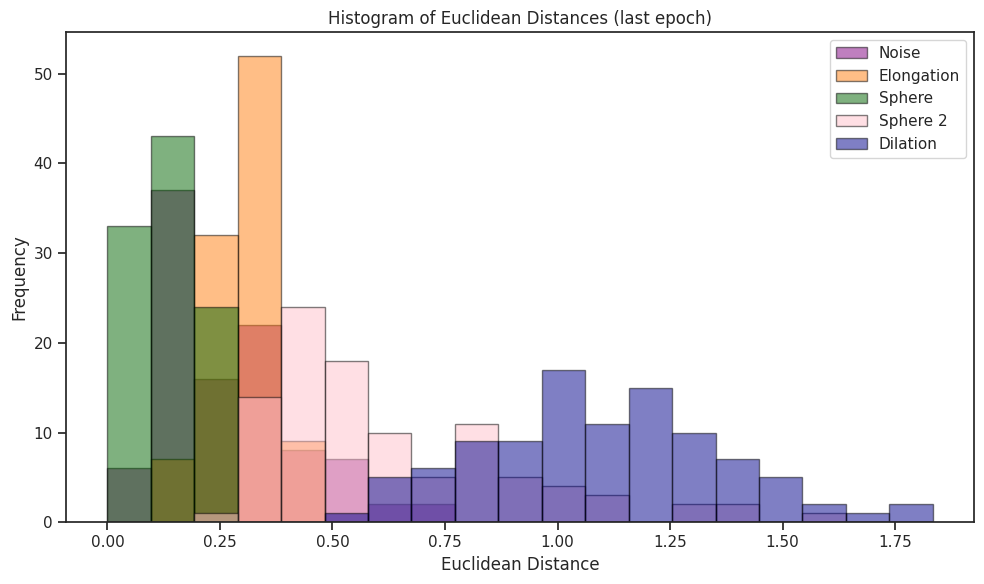

In [91]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise), 
                          np.max(euclidean_distances_elongated), 
                          np.max(euclidean_distances_sphere), 
                          np.max(euclidean_distances_sphere_2), 
                          np.max(euclidean_distances_sphere_3)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.hist(euclidean_distances_sphere, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Verde oscuro
plt.hist(euclidean_distances_sphere_2, bins=bins, alpha=0.5, label='Sphere 2', color='#FFC0CB', edgecolor='black')  # Rosa
plt.hist(euclidean_distances_sphere_3, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  # Gris
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



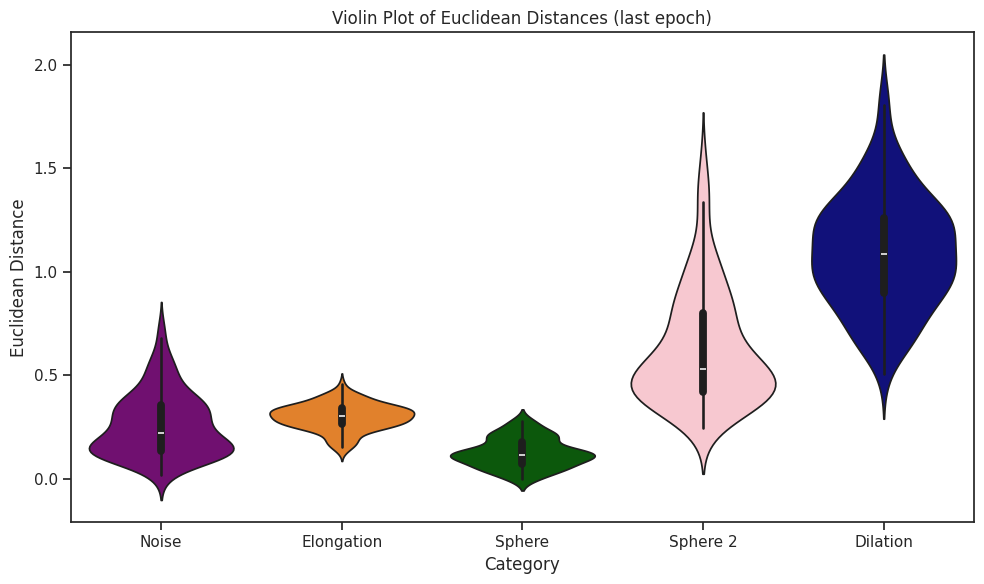

In [ ]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise, 
                                euclidean_distances_elongated, 
                                euclidean_distances_sphere, 
                                euclidean_distances_sphere_2, 
                                euclidean_distances_sphere_3]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Dilation'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FFC0CB', 
    'Dilation': '#00008B'
})
plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (last epoch)')
plt.tight_layout()
plt.show()

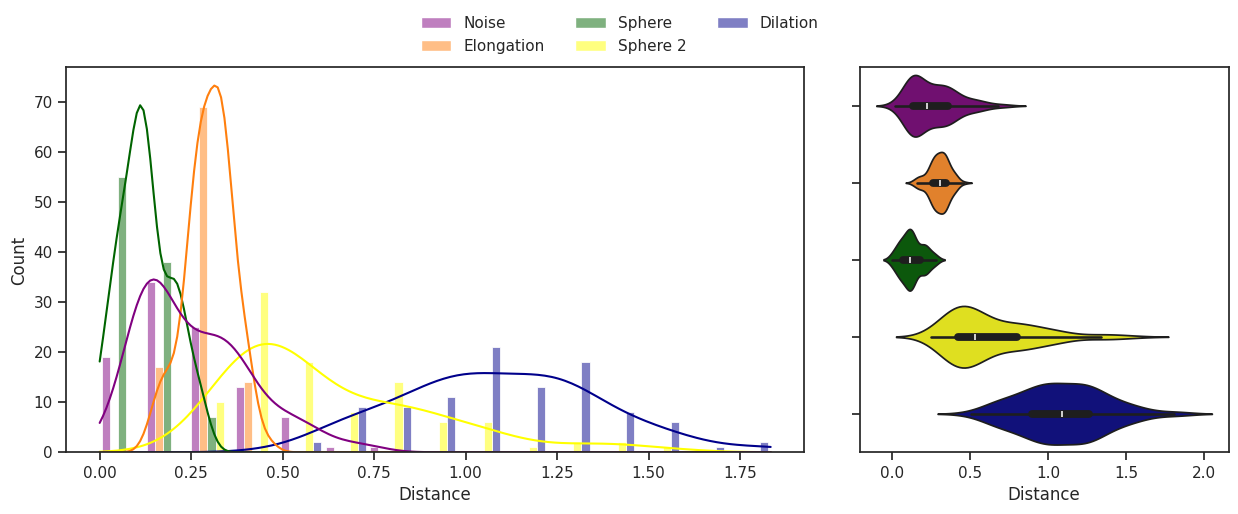

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un DataFrame para usar con seaborn
import pandas as pd

data = {
    'Distance': np.concatenate([
        euclidean_distances_noise, 
        euclidean_distances_elongated, 
        euclidean_distances_sphere, 
        euclidean_distances_sphere_2, 
        euclidean_distances_sphere_3
    ]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Dilation'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

# Definir la paleta de colores
palette = {
    'Noise': '#800080',       # Morado
    'Elongation': '#ff7f0e',  # Naranja
    'Sphere': '#006400',      # Verde oscuro
    'Sphere 2': '#FFFF00',    # Magenta
    'Dilation': '#00008B'     # Gris
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5), width_ratios=[2, 1])

# Histograma
sns.histplot(data=df, x='Distance', hue='Category', multiple='dodge', shrink=0.9, kde=True, palette=palette, ax=axes[0])
sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(0.75, 1), ncol=3, title=None, frameon=False,
)

# Gráfico de violín
sns.violinplot(data=df, y='Category', x='Distance', hue='Category', palette=palette, ax=axes[1])
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])

plt.subplots_adjust(wspace=0.1)
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



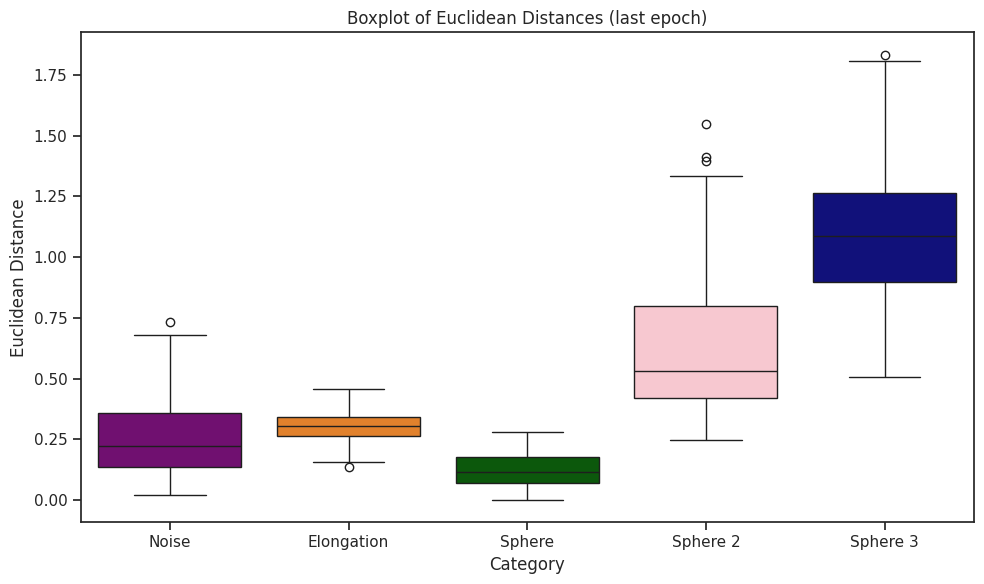

In [ ]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise, 
                                euclidean_distances_elongated, 
                                euclidean_distances_sphere, 
                                euclidean_distances_sphere_2, 
                                euclidean_distances_sphere_3]),
    'Category': ['Noise'] * len(euclidean_distances_noise) + 
                ['Elongation'] * len(euclidean_distances_elongated) + 
                ['Sphere'] * len(euclidean_distances_sphere) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2) + 
                ['Sphere 3'] * len(euclidean_distances_sphere_3)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FFC0CB', 
    'Sphere 3': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Boxplot of Euclidean Distances (last epoch)')
plt.tight_layout()
plt.show()

EUCLICEAN DISTANCES BETWEEN EMBEDDINGS OF THE EPOCH WITH BEST DICE

In [94]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.8867243  0.82285273 0.8386045  0.92061114 1.0625558  0.9767308
 1.6583394  1.422159   1.0717369  1.201878   1.4392711  1.4126356
 1.2515097  0.9569613  1.8441437  1.5173143  1.9460275  1.688189
 1.5149308  1.305042   1.5638493  1.7951064  1.5640838  1.3114725
 2.1554697  2.026099   2.5364754  2.646682   1.4520826  1.2178545
 1.6109154  1.542476   1.8157904  1.5351163  1.7441154  1.5407875
 1.0773888  0.9453037  1.2794979  1.3960884  1.6342856  1.3780681
 1.8396362  1.8784307  1.3841907  1.3841838  1.5524819  1.5326829
 1.2572287  0.94932675 0.8381536  0.80309725 1.2694079  1.4723393
 1.2665693  1.4409161  1.3843406  1.4715155  1.7713397  1.5767082
 1.6378015  1.4522692  1.6688021  1.6509964  1.3712275  1.5422566
 0.8666089  0.7786244  1.2909555  1.1490967  1.6036711  1.4457701
 1.4450827  1.4515548  1.5714731  1.7232984  1.100158   1.119318
 1.1174362  1.1289

In [ ]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.92221713 0.849661   0.8948153  0.79196066 1.0467005  0.94459915
 1.4823248  1.1959537  1.0289145  1.048397   1.3906978  1.3515258
 1.3267758  0.95020676 1.6216474  1.4108073  1.9148606  1.714551
 1.3460003  1.2513934  1.3026128  1.3439875  1.3451568  1.1994776
 2.0752573  1.9518886  2.176796   2.0766814  1.3925085  1.1916033
 1.5067079  1.365593   1.573364   1.4233755  1.6744616  1.5130987
 1.0808954  0.90528154 1.2330106  1.344101   1.6365765  1.3965206
 1.713503   1.649524   1.3043537  1.2934353  1.3207242  1.4388587
 1.1987809  0.9210051  0.90656126 0.8567522  1.1839173  1.1067019
 1.2561251  1.2691867  1.309805   1.1385287  1.5574509  1.2816936
 1.5986793  1.4668227  1.6316156  1.6062449  1.2548195  1.2509693
 0.88036805 0.78428245 1.2076708  1.086965   1.5001041  1.3162793
 1.2360473  1.3971776  1.5089436  1.4752142  0.9752882  0.9227849
 1.1555105  1.02

In [ ]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere_2.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.899834   0.83530354 1.0173761  1.4830949  1.180742   1.2111477
 1.6177192  1.8323333  0.9571609  1.1455549  1.4432834  1.4133853
 1.252702   1.0726563  1.4341042  1.3848712  1.935613   1.74812
 1.1664484  1.1503891  1.2710268  1.8338412  1.3998423  1.4497204
 1.9644623  1.8627032  2.38078    2.1821678  1.2205379  1.1292175
 1.4186981  1.3470794  1.7044771  1.5903842  1.4688956  1.4735246
 1.208631   1.0847349  1.1317868  1.2204287  1.4365665  1.6689675
 1.7579241  1.7441505  1.1785461  1.6195956  1.1747394  1.2894441
 1.186041   1.058721   0.8292458  0.81903267 1.2152922  1.2613866
 1.2075496  1.538838   1.3952619  1.2883852  1.4382275  1.3306088
 1.5747813  1.4218355  1.5919528  1.5574942  1.2875687  1.2994199
 0.9797643  1.0263354  1.1359097  0.9766174  1.2892563  1.126575
 1.2543502  1.3788443  1.641856   1.6844991  1.1320696  1.2573279
 1.1531274  1.09117

In [97]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_sphere_3.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.2793772  1.2335786  1.0709925  1.2880214  2.0004797  1.7963245
 2.801437   2.370547   1.6611502  1.7610214  2.0270722  2.0518608
 1.4736017  1.3508763  2.567392   2.248278   2.3277905  2.2944963
 1.969645   2.1217515  2.250795   2.2266185  2.3183722  2.0883358
 2.9569721  2.8337061  3.2683177  3.443699   1.9994155  1.8841513
 2.4094963  2.1849272  2.7516067  2.9019353  2.6272817  2.478282
 1.1843563  1.2659599  1.9776137  2.5038612  2.2905188  2.255457
 2.3453035  2.2339888  1.9773396  2.1062837  2.203892   2.668743
 1.4142158  1.4612211  0.91323435 0.99313724 2.0323613  2.1583838
 1.8791215  2.2064533  2.4000325  2.3582034  2.650252   2.3828957
 1.9820842  1.9223802  2.4912555  2.4875262  2.469912   2.417928
 1.3244488  1.3427718  1.9602292  1.788015   2.3115537  2.121998
 2.1185086  2.1321013  2.4361315  2.3279681  1.4069973  1.8942504
 1.2990596  1.4131228

In [ ]:
# Euclidean distance between the latent vectors of the best epoch (dice) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Elongated: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Elongated: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.0187963  0.9629186  0.88190705 0.8613511  1.1448498  1.0547308
 1.6575812  1.4042217  1.1264988  1.2037305  1.5405898  1.4805669
 1.4866983  1.104158   1.7795258  1.547146   2.0019176  1.8231153
 1.4676509  1.3769894  1.314135   1.488242   1.4984847  1.3348027
 2.2244468  2.1367753  2.3822348  2.2803812  1.5374213  1.3348755
 1.6571217  1.5555178  1.9147291  1.7950115  1.8394755  1.7688574
 1.293269   1.0996884  1.3090723  1.424712   1.7112353  1.5190579
 1.9159794  1.8195251  1.4498746  1.4913181  1.4884956  1.6294066
 1.3436491  1.0596497  1.0861876  1.0299269  1.4505491  1.4325954
 1.4256104  1.4653819  1.4708391  1.3252522  1.7668418  1.5541865
 1.8298625  1.6792961  1.9327908  1.8847839  1.3967953  1.3565549
 0.9681695  0.8453376  1.2207915  1.0658168  1.6858016  1.5328573
 1.3376098  1.4398963  1.591502   1.6032377  1.1315194  1.0675819
 1.3043973  



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



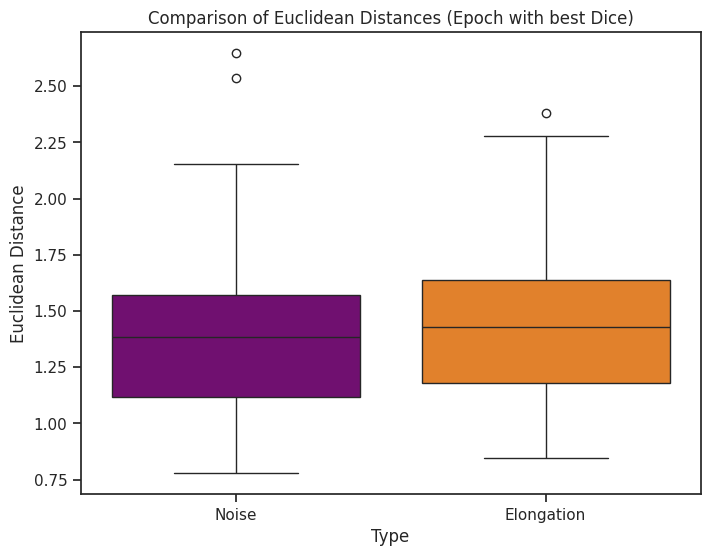

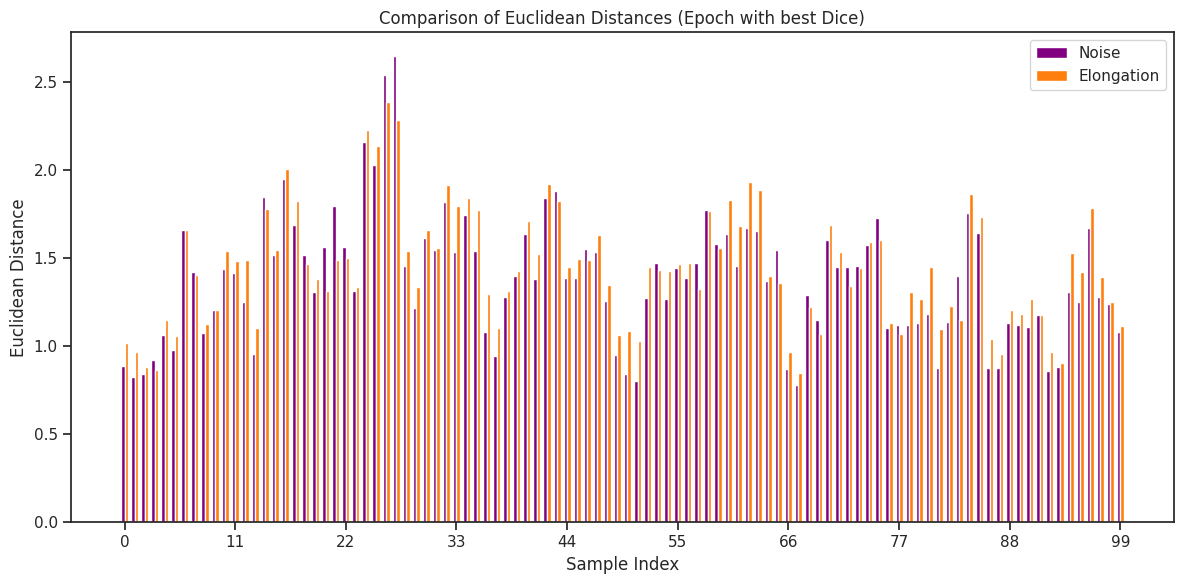

In [ ]:
euclidean_distances_noise_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Noise'] * len(euclidean_distances_noise_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

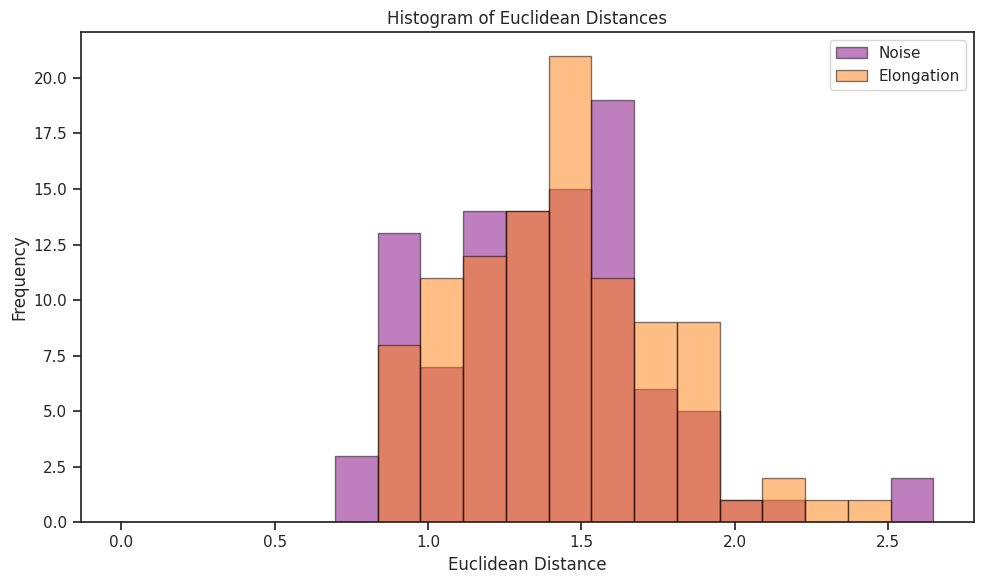

In [ ]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_noise_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_dice, bins=bins_dice, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

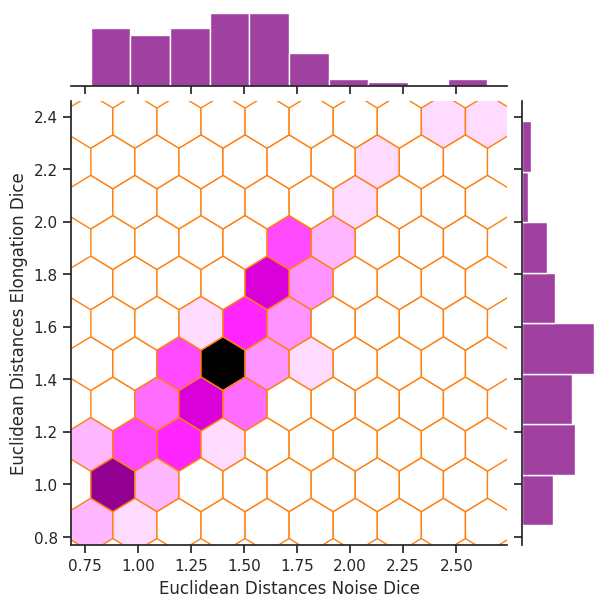

In [ ]:
x_dice = euclidean_distances_noise_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#800080")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")

plt.xlabel('Euclidean Distances Noise Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



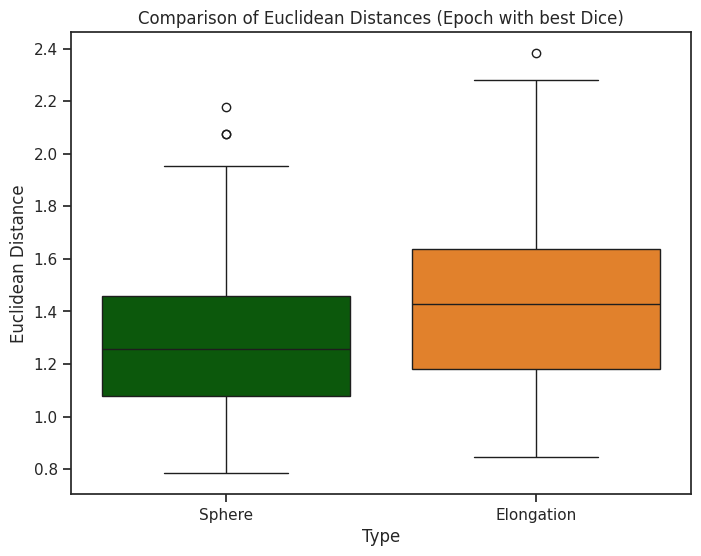

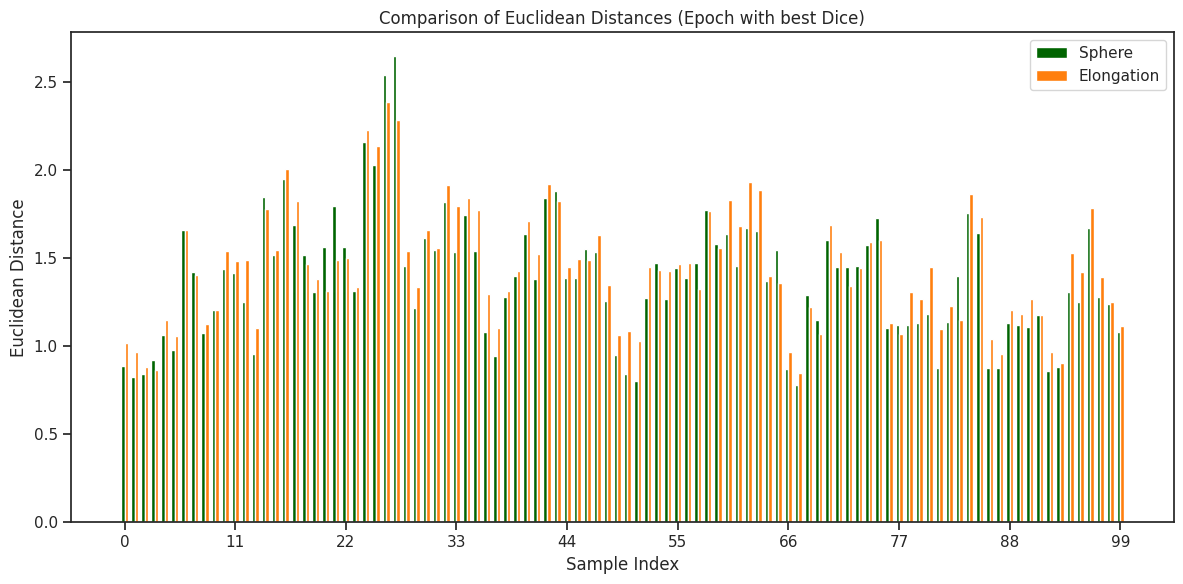

In [102]:
euclidean_distances_sphere_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere'] * len(euclidean_distances_sphere_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

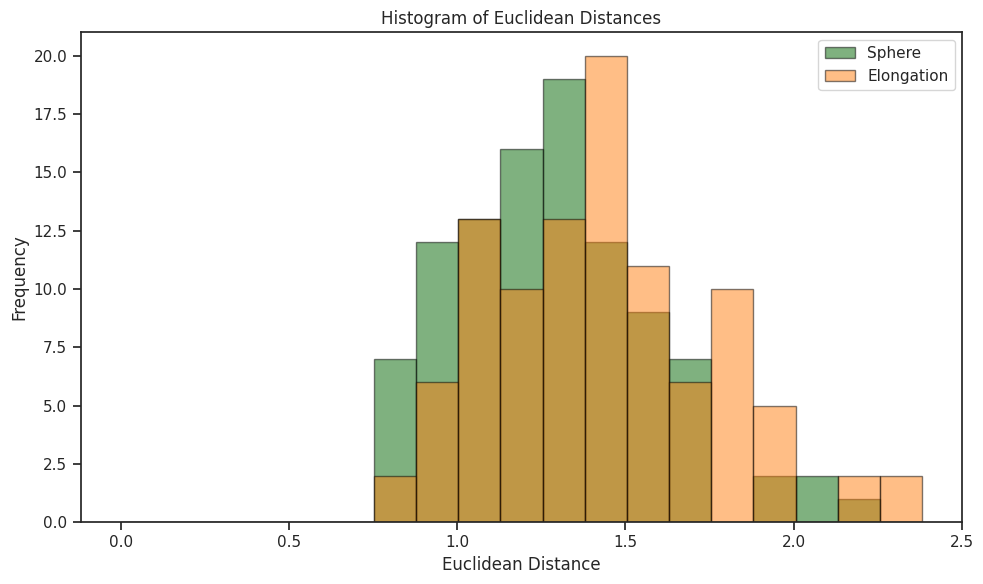

In [ ]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_dice, bins=bins_dice, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

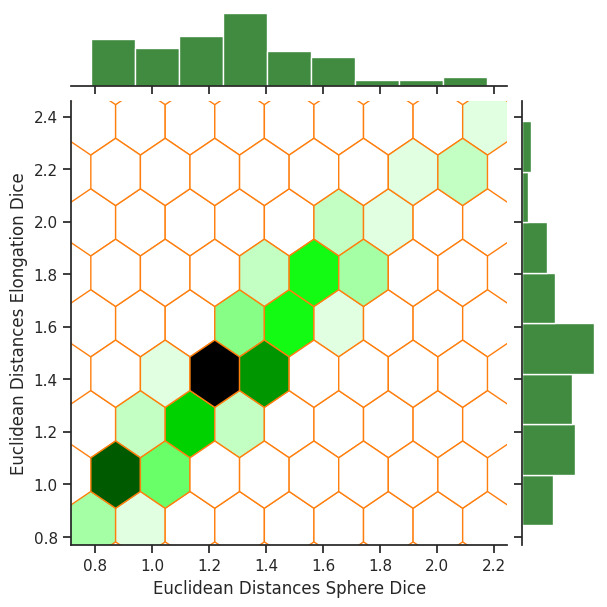

In [104]:
x_dice = euclidean_distances_sphere_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#006400")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



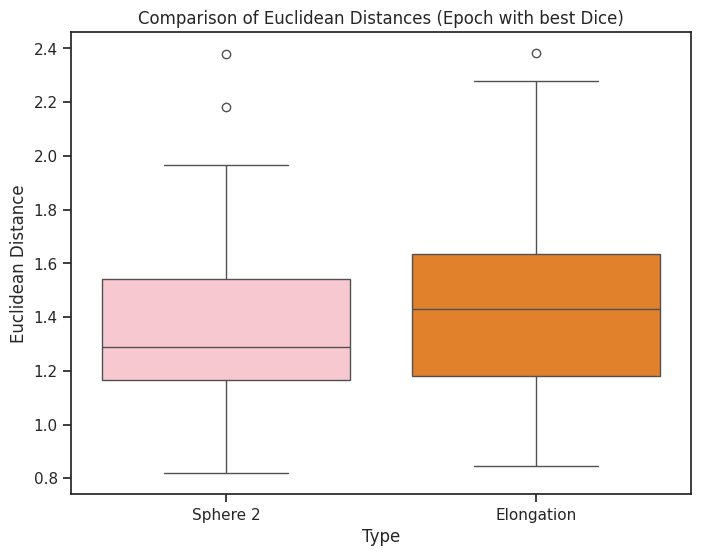

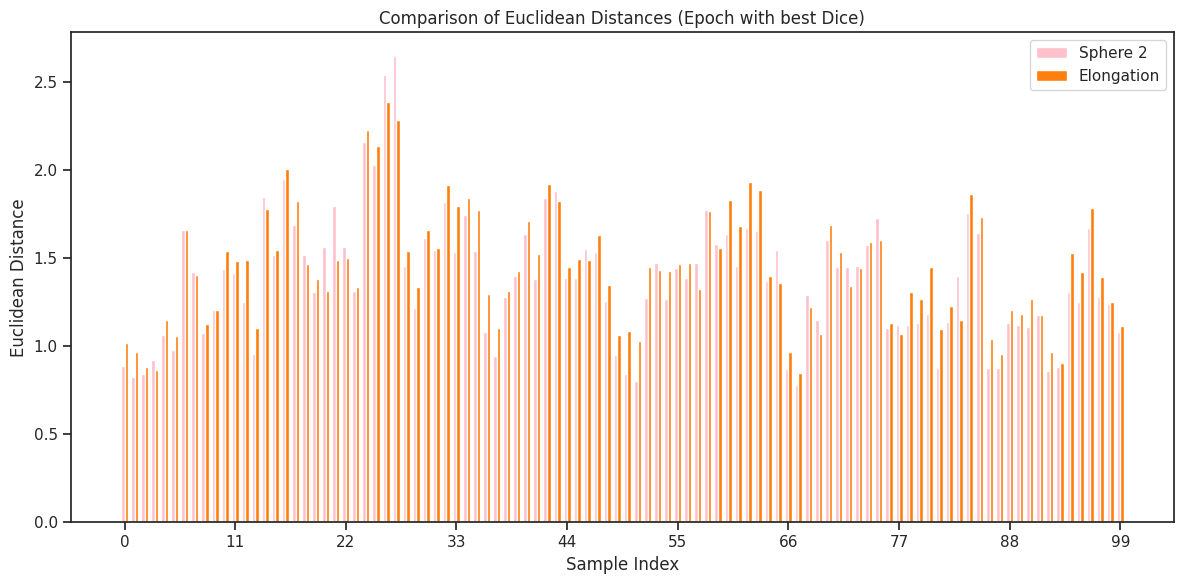

In [105]:
euclidean_distances_sphere_2_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere 2": "#FFC0CB", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

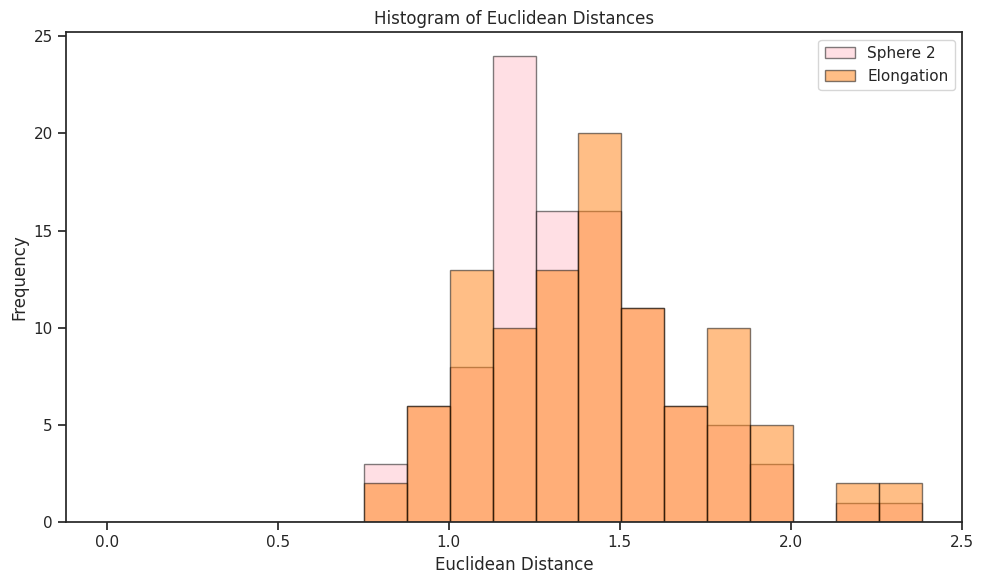

In [106]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_2_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2_dice, bins=bins_dice, alpha=0.5, label='Sphere 2', color='#FFC0CB', edgecolor='black') 
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

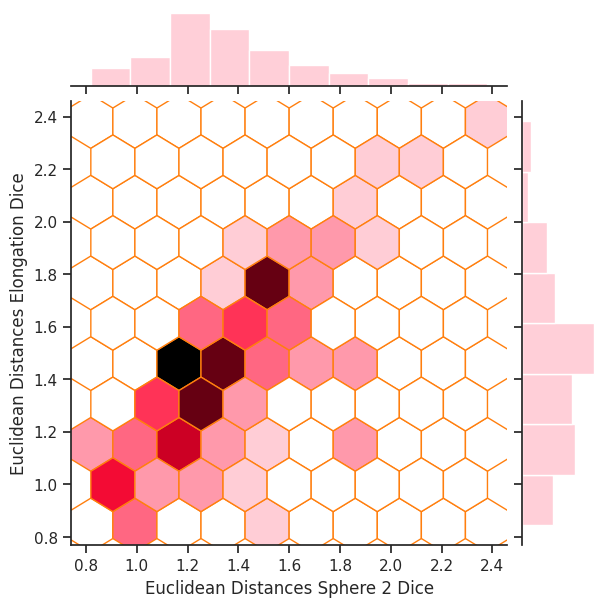

In [ ]:
x_dice = euclidean_distances_sphere_2_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#FFC0CB")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 2 Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



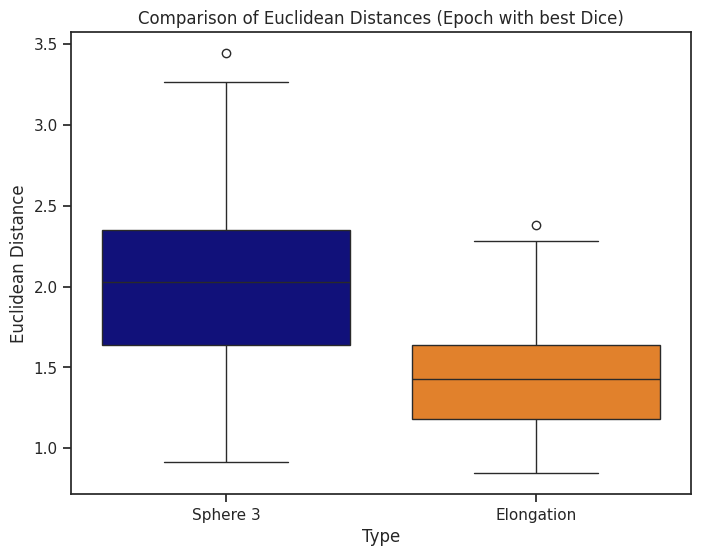

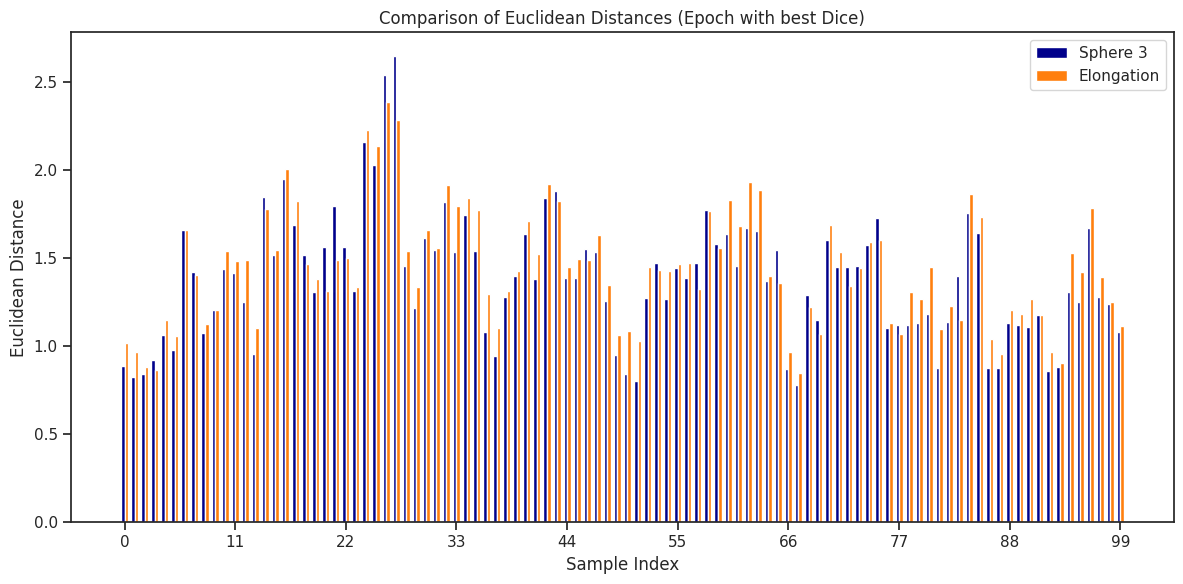

In [108]:
euclidean_distances_sphere_3_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3_dice))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best Dice)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

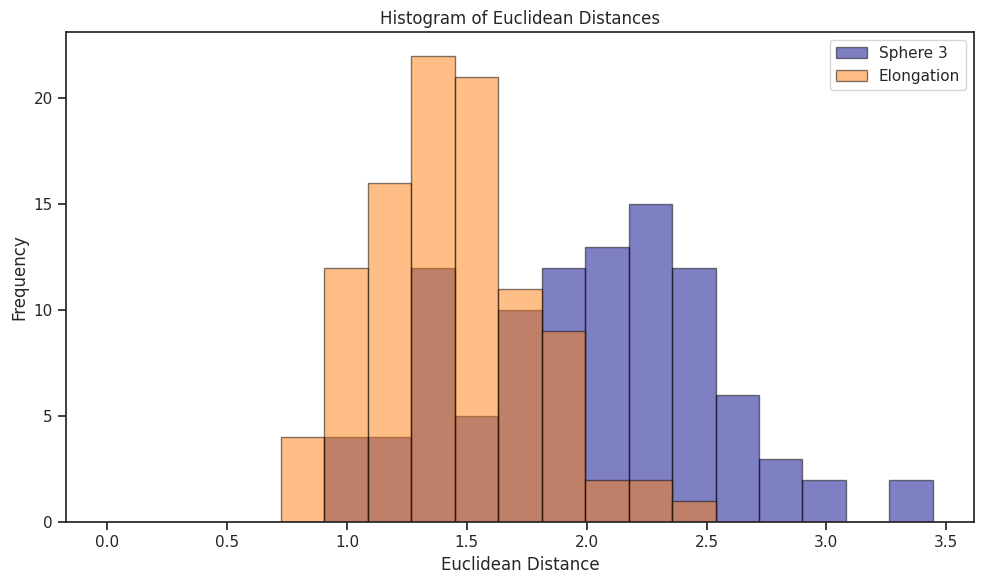

In [ ]:
bins_dice = np.linspace(0, max(np.max(euclidean_distances_sphere_3_dice), np.max(euclidean_distances_elongated_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3_dice, bins=bins_dice, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

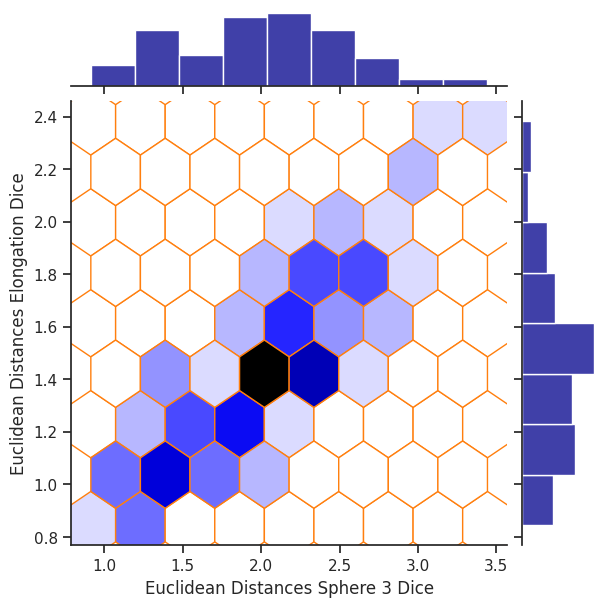

In [ ]:
x_dice = euclidean_distances_sphere_3_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#00008B")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3 Dice')
plt.ylabel('Euclidean Distances Elongation Dice')
plt.show()

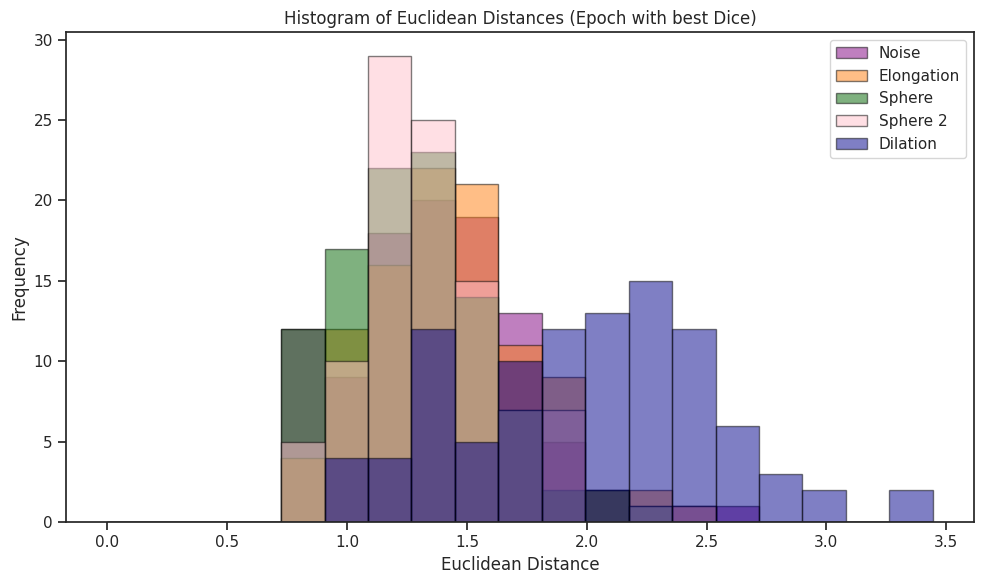

In [111]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise_dice), 
                          np.max(euclidean_distances_elongated_dice), 
                          np.max(euclidean_distances_sphere_dice), 
                          np.max(euclidean_distances_sphere_2_dice), 
                          np.max(euclidean_distances_sphere_3_dice)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_dice, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_dice, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.hist(euclidean_distances_sphere_dice, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Verde oscuro
plt.hist(euclidean_distances_sphere_2_dice, bins=bins, alpha=0.5, label='Sphere 2', color='#FFC0CB', edgecolor='black')  # Rosa
plt.hist(euclidean_distances_sphere_3_dice, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  # Gris

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (Epoch with best Dice)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



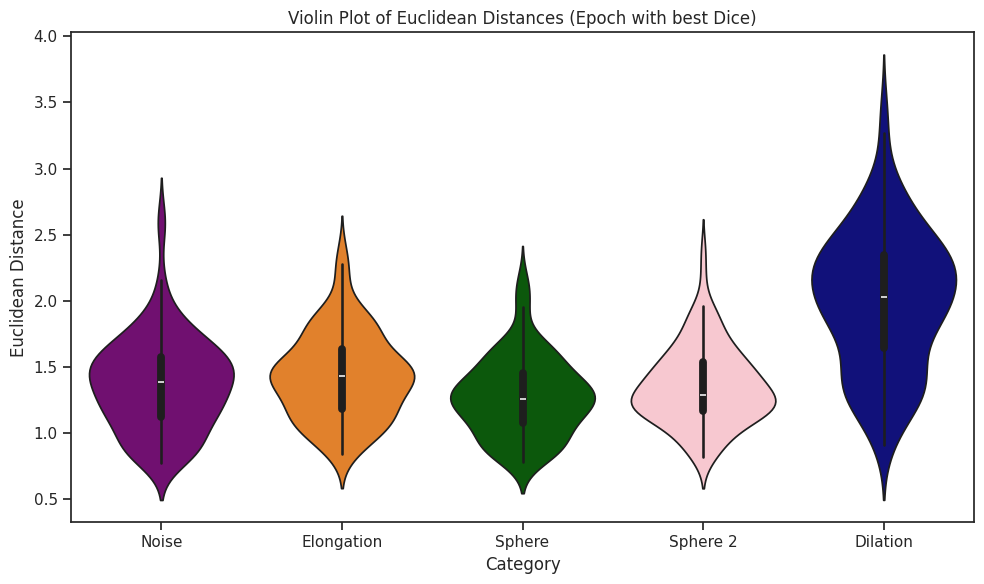

In [ ]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise_dice, 
                                euclidean_distances_elongated_dice, 
                                euclidean_distances_sphere_dice, 
                                euclidean_distances_sphere_2_dice, 
                                euclidean_distances_sphere_3_dice]),
    'Category': ['Noise'] * len(euclidean_distances_noise_dice) + 
                ['Elongation'] * len(euclidean_distances_elongated_dice) + 
                ['Sphere'] * len(euclidean_distances_sphere_dice) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_dice) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_dice)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FFC0CB', 
    'Dilation': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (Epoch with best Dice)')
plt.tight_layout()
plt.show()

EUCLIDEAN DISTANCES BETWEEN EMBEDDINGS OF THE EPOCHS WITH THE BEST MSE

In [113]:
# Euclidean distance between the latent vectors of the best epoch (mse) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_mse[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_mse.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.1775242 1.0352485 1.0068309 1.2172894 1.4544363 1.3216017 1.9500631
 1.985181  1.3534715 1.6256483 1.4872156 1.4345345 1.3724777 1.0545597
 1.7196358 1.7669983 2.0781662 1.7943195 1.4095986 1.3822211 1.9828786
 2.2469523 1.6151012 1.3465488 2.0125282 2.0574384 3.0398014 3.5632446
 1.529516  1.3918369 1.5118327 1.6105154 1.8464141 1.8071929 1.5107167
 1.2853578 1.2705292 1.149918  1.5103171 1.6400894 1.7777455 1.3626832
 2.4417677 2.2265728 1.654947  1.5497676 1.2981058 1.3996936 1.3149492
 1.0791637 0.8565333 0.720011  1.5386437 1.4620333 1.8264806 1.6669208
 2.2312136 2.0854826 2.0275383 1.7395269 1.531709  1.4727312 2.0129151
 2.007226  1.3549662 1.5289165 1.1813072 1.1142162 1.4628282 1.3780997
 1.3719027 1.3575565 1.8293384 2.0051837 1.9120786 2.4774501 1.5938774
 1.5907322 1.4045027 1.3201342 1.2439804 1.0466185 1.3938482 1.8835944
 1.8095988 1.916966  1

In [ ]:
# Euclidean distance between the latent vectors of the best epoch (mse) and the latent vectors with sphere

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape Sphere: {val_latent_vectors_sphere.shape}")

print(best_val_latent_vectors_mse[0].shape)
print(val_latent_vectors_sphere[0].shape)

assert best_val_latent_vectors_mse.shape == val_latent_vectors_sphere.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_sphere, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.2727399  1.1057609  1.0840918  1.0888814  1.4462378  1.2907606
 1.8270965  1.7782407  1.3354915  1.4720128  1.4716234  1.4256034
 1.4853562  1.1075559  1.5394536  1.6530132  2.2365935  1.8898617
 1.294437   1.3109304  1.8077067  1.7883894  1.6813936  1.3077201
 2.0472777  2.0944402  2.7319443  3.0539763  1.5560639  1.3751538
 1.4557914  1.3943981  1.8507125  1.7665237  1.5157319  1.2767779
 1.3495731  1.1132833  1.4998163  1.6044433  1.8203547  1.3580719
 2.4912434  2.1962903  1.7510676  1.4725155  1.279151   1.3617623
 1.333266   1.0789703  0.93389606 0.7643931  1.5190774  1.234163
 1.8590652  1.5568784  2.2095122  1.8240569  1.9501216  1.5985985
 1.5456561  1.5298605  2.0198395  1.9948096  1.3026392  1.3617928
 1.2155719  1.1211131  1.3916075  1.3270401  1.4863235  1.4785843
 1.7957304  1.9917705  1.8633258  2.240889   1.5280478  1.4152553
 1.4697057  1.24

In [ ]:
# Euclidean distance between the latent vectors of the best epoch (mse) and the latent vectors with sphere 2

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape Sphere 2: {val_latent_vectors_sphere_2.shape}")

print(best_val_latent_vectors_mse[0].shape)
print(val_latent_vectors_sphere_2[0].shape)

assert best_val_latent_vectors_mse.shape == val_latent_vectors_sphere_2.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_sphere_2, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 2: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.2789134  1.1157833  1.0830652  1.6247903  1.5908822  1.6229336
 1.8651135  2.343983   1.2698197  1.5897608  1.4757016  1.4491563
 1.327483   1.1536005  1.3621292  1.6992582  2.0124564  1.6162698
 1.1745018  1.2889488  1.5714139  2.3085198  1.6687458  1.4872257
 1.9137313  2.0276406  2.8964229  3.1849766  1.4364064  1.4139943
 1.3753604  1.5094911  1.9941243  1.9634221  1.4775535  1.392667
 1.335369   1.2372316  1.4079585  1.5020874  1.6401353  1.8150984
 2.4132428  2.1882362  1.6435565  1.9728955  1.2713131  1.3305703
 1.2608949  1.1188025  0.91538256 0.8369401  1.5785637  1.4029785
 1.8557307  1.9310652  2.135027   1.7819319  1.8874383  1.5650141
 1.428903   1.378902   1.9202226  1.914605   1.3838203  1.4678625
 1.2414409  1.2555016  1.3499286  1.2761526  1.5295705  1.5115024
 1.8224995  1.9902096  1.9080348  2.4031718  1.5906118  1.682534
 1.3475422  1.2

In [ ]:
# Euclidean distance between the latent vectors of the best epoch (mse) and the latent vectors with sphere 3

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape Sphere 3: {val_latent_vectors_sphere_3.shape}")

print(best_val_latent_vectors_mse[0].shape)
print(val_latent_vectors_sphere_3[0].shape)

assert best_val_latent_vectors_mse.shape == val_latent_vectors_sphere_3.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_sphere_3, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Sphere 3: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.4646261  1.3184191  1.2602143  1.5767472  2.22942    2.0331304
 2.9128966  2.8157024  1.8860136  2.1437676  1.9905721  2.002067
 1.3721967  1.291515   2.3556855  2.4151025  1.9873267  1.9874401
 1.8060344  2.2061353  2.5088885  2.6347513  1.7849809  1.8103431
 2.4025316  2.4409168  3.7599494  4.3222756  2.0472052  2.027271
 2.120615   2.1997023  1.9866282  2.476592   2.007134   1.8909972
 1.4039242  1.4935788  1.9616315  2.5769079  2.0105743  1.9087338
 3.038818   2.758904   1.8399438  2.0561485  1.5493578  2.1498523
 1.2830349  1.3923024  0.81206584 0.91735655 1.8973737  1.9827625
 1.8597215  2.0594263  2.9810474  2.8058944  2.2087994  2.0023224
 1.6545967  1.6837038  2.5870671  2.587144   2.1545012  2.221726
 1.576862   1.6332036  2.0534418  1.9283485  1.5623468  1.4574527
 1.8345008  2.2560072  2.7227213  3.0334175  1.6231885  2.1172607
 1.5216187  1.58

In [117]:
# Euclidean distance between the latent vectors of the best epoch (mse) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_mse[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_mse.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

print(len(distancias_euclidianas))
print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
100
Distancias Euclidianas: [1.2938827  1.1444362  1.0236299  1.1588806  1.4966066  1.3685406
 1.8372996  1.9020584  1.3803658  1.6101297  1.4673365  1.4521853
 1.5404379  1.1836456  1.6537565  1.8159032  2.1529615  1.8262831
 1.2838855  1.4230194  1.7022943  1.8721534  1.7440361  1.4399506
 2.1222155  2.2293234  2.8413997  3.2117174  1.5893978  1.4609717
 1.4281927  1.5442685  1.9043559  1.9407834  1.6200327  1.447892
 1.4560372  1.2607609  1.4421636  1.5847262  1.8268718  1.4588381
 2.5507467  2.2674649  1.6437465  1.5615577  1.2620815  1.4119747
 1.350386   1.1327235  0.98980105 0.89305466 1.5368956  1.4150891
 1.7519505  1.5738412  2.141922   1.82658    2.0838187  1.7197274
 1.6653705  1.6507815  2.1751728  2.1586497  1.3050458  1.3832622
 1.2712756  1.1707635  1.3605092  1.2936693  1.5522451  1.5093632
 1.8618515  2.0771906  1.8711928  2.345612   1.5636443  1.5046874
 1.4746923  1



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



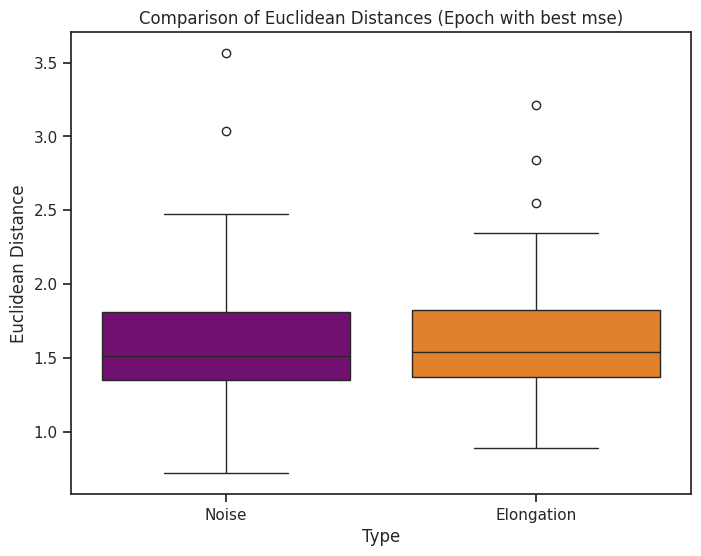

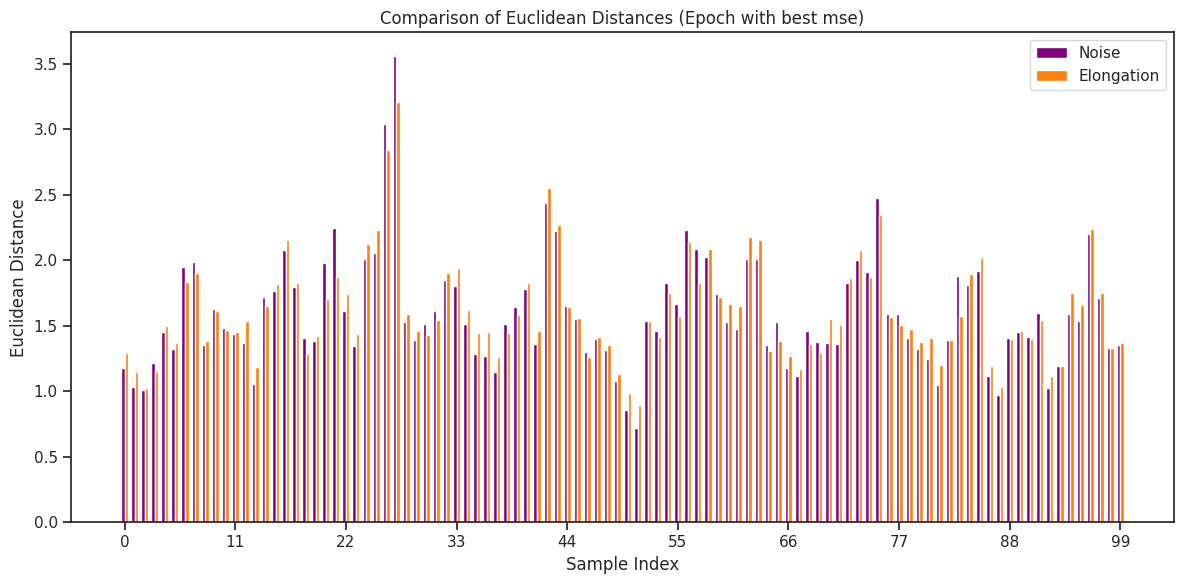

In [ ]:
euclidean_distances_noise_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_mse) + list(euclidean_distances_elongated_mse),
    'Type': ['Noise'] * len(euclidean_distances_noise_mse) + ['Elongation'] * len(euclidean_distances_elongated_mse)
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best mse)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_mse))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_mse, width, label='Noise', color=palette['Noise'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_mse, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best mse)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

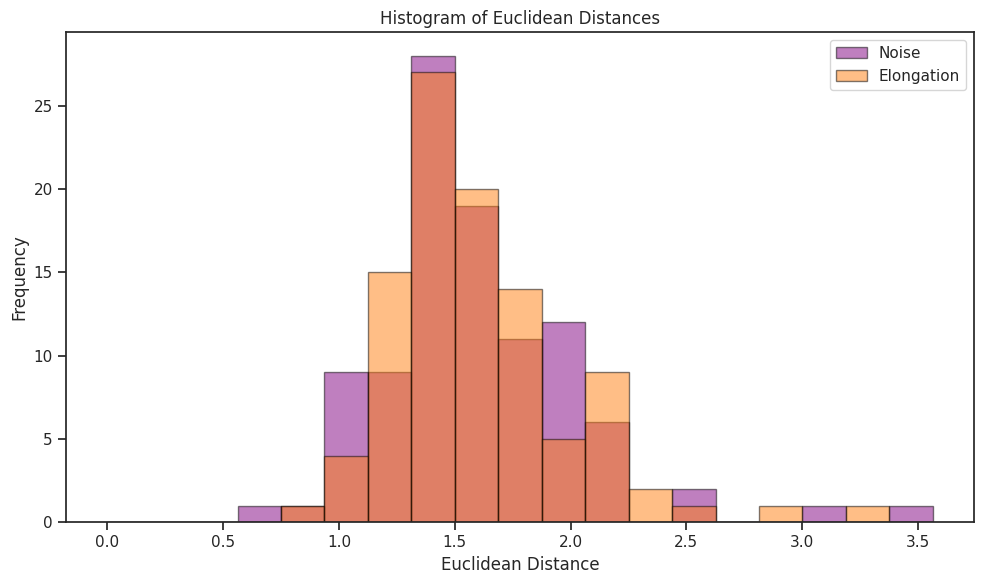

In [ ]:
bins_mse = np.linspace(0, max(np.max(euclidean_distances_noise_mse), np.max(euclidean_distances_elongated_mse)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_mse, bins=bins_mse, alpha=0.5, label='Noise', color='#800080', edgecolor='black') 
plt.hist(euclidean_distances_elongated_mse, bins=bins_mse, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

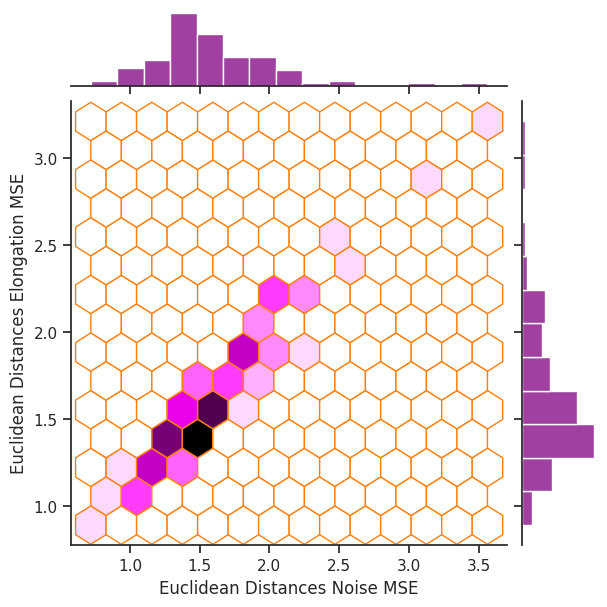

In [ ]:
x_mse = euclidean_distances_noise_mse
y_mse = euclidean_distances_elongated_mse

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_mse, y=y_mse, kind="hex", color="#800080") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Noise MSE')
plt.ylabel('Euclidean Distances Elongation MSE')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



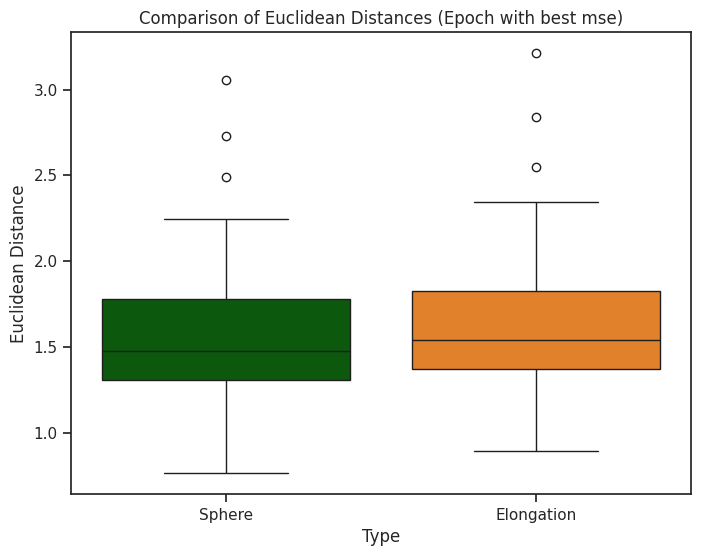

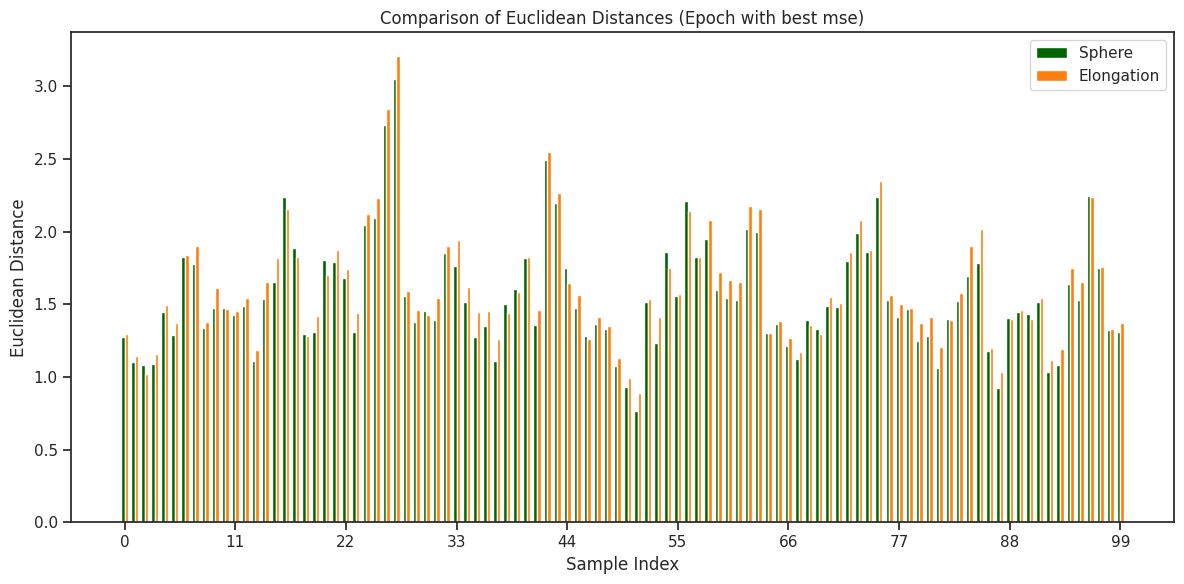

In [121]:
euclidean_distances_sphere_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_sphere, axis=1)
euclidean_distances_elongated_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_mse) + list(euclidean_distances_elongated_mse),
    'Type': ['Sphere'] * len(euclidean_distances_sphere_mse) + ['Elongation'] * len(euclidean_distances_elongated_mse)
})

palette = {"Sphere": "#006400", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best mse)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_mse))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_mse, width, label='Sphere', color=palette['Sphere'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_mse, width, label='Elongation', color=palette['Elongation'])

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best mse)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

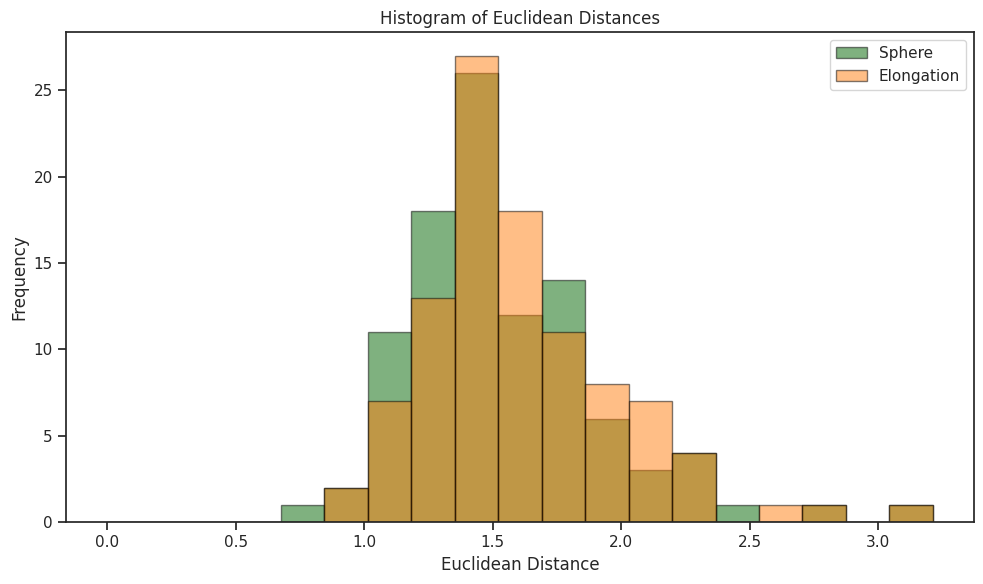

In [122]:
bins_mse = np.linspace(0, max(np.max(euclidean_distances_sphere_mse), np.max(euclidean_distances_elongated_mse)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_mse, bins=bins_mse, alpha=0.5, label='Sphere', color='#006400', edgecolor='black') 
plt.hist(euclidean_distances_elongated_mse, bins=bins_mse, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black') 
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

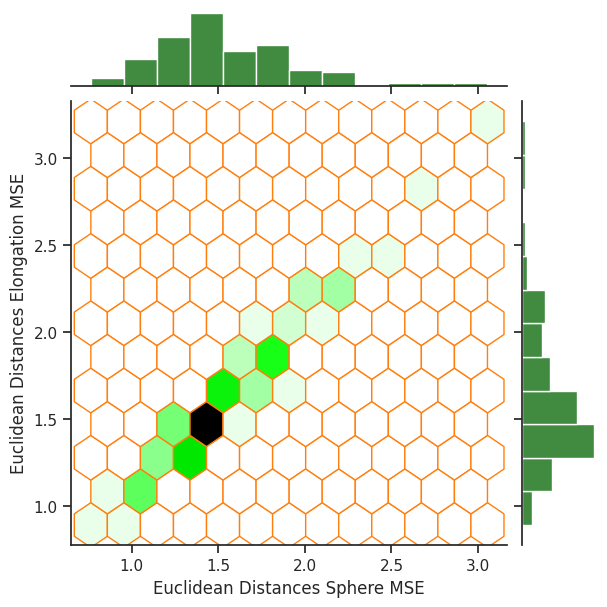

In [123]:
x_mse = euclidean_distances_sphere_mse
y_mse = euclidean_distances_elongated_mse

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_mse, y=y_mse, kind="hex", color="#006400")
g.ax_joint.collections[0].set_edgecolor("#ff7f0e") 
plt.xlabel('Euclidean Distances Sphere MSE')
plt.ylabel('Euclidean Distances Elongation MSE')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



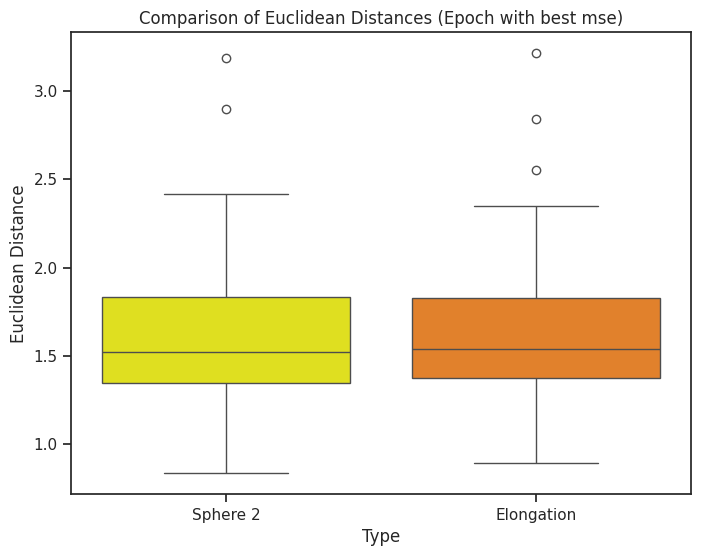

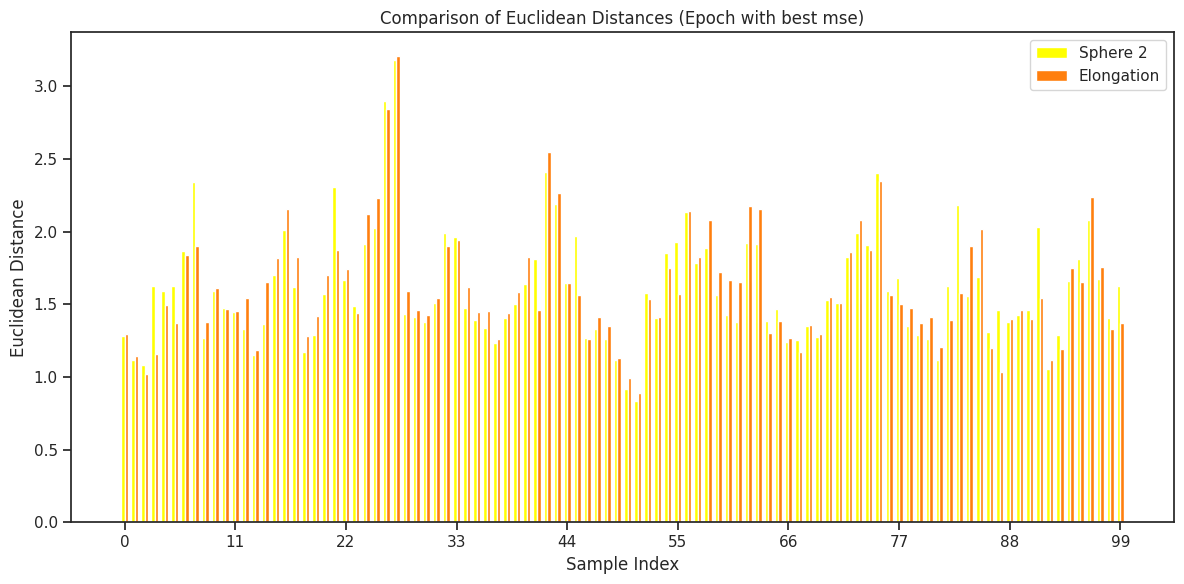

In [ ]:
euclidean_distances_sphere_2_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_sphere_2, axis=1)
euclidean_distances_elongated_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_2_mse) + list(euclidean_distances_elongated_mse),
    'Type': ['Sphere 2'] * len(euclidean_distances_sphere_2_mse) + ['Elongation'] * len(euclidean_distances_elongated_mse)
})

palette = {"Sphere 2": "#FFFF00", "Elongation": "#ff7f0e"} 

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best mse)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_2_mse))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_2_mse, width, label='Sphere 2', color=palette['Sphere 2'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_mse, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best mse)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

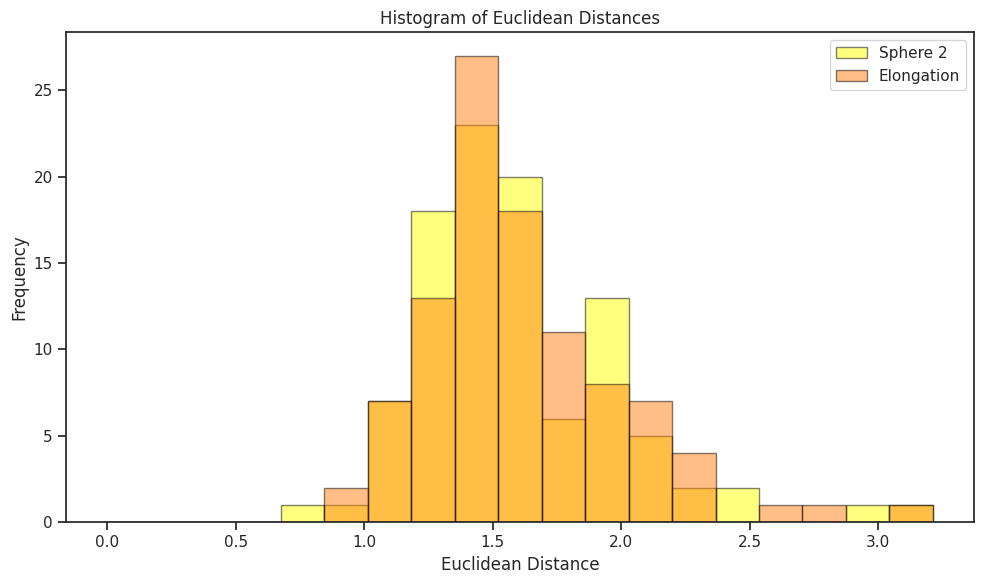

In [143]:
bins_mse = np.linspace(0, max(np.max(euclidean_distances_sphere_2_mse), np.max(euclidean_distances_elongated_mse)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_2_mse, bins=bins_mse, alpha=0.5, label='Sphere 2', color='#FFFF00', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_mse, bins=bins_mse, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()
plt.tight_layout()
plt.show()

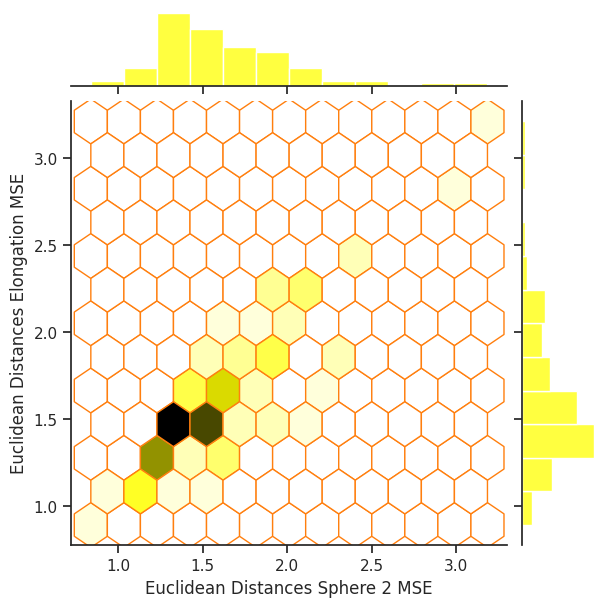

In [144]:
x_mse = euclidean_distances_sphere_2_mse
y_mse = euclidean_distances_elongated_mse

sns.set_theme(style="ticks")

g = sns.jointplot(x=x_mse, y=y_mse, kind="hex", color="#FFFF00")  # Morado para "Noise"
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")  # Naranja para "Elongation"

plt.xlabel('Euclidean Distances Sphere 2 MSE')
plt.ylabel('Euclidean Distances Elongation MSE')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



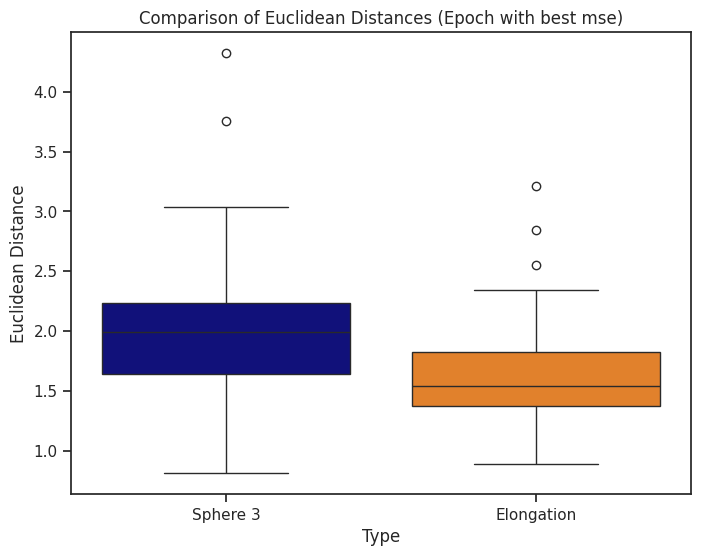

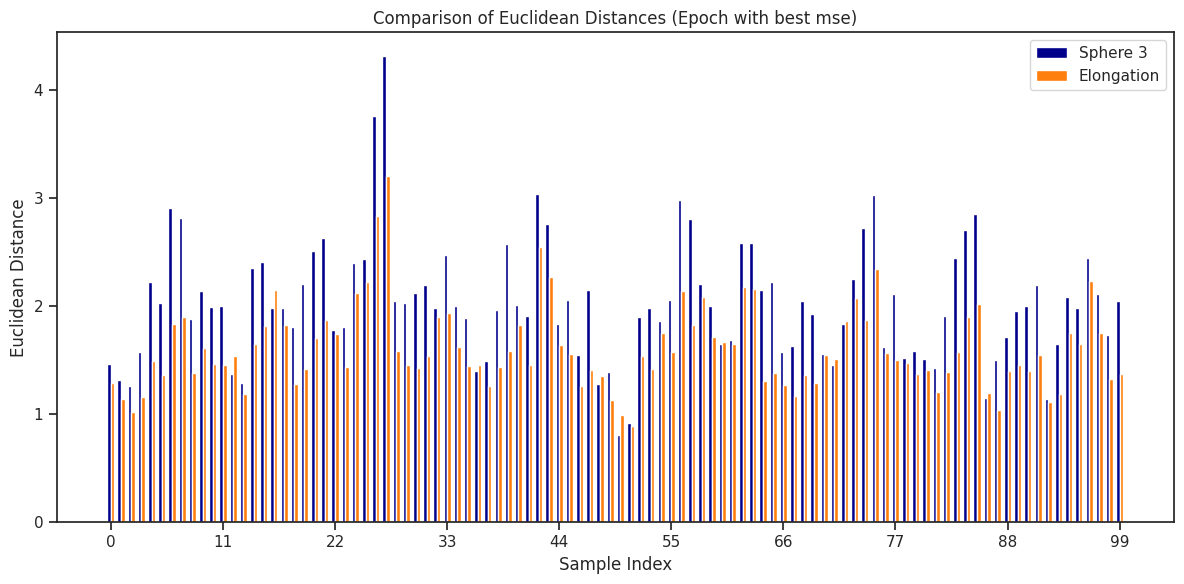

In [127]:
euclidean_distances_sphere_3_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_sphere_3, axis=1)
euclidean_distances_elongated_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_sphere_3_mse) + list(euclidean_distances_elongated_mse),
    'Type': ['Sphere 3'] * len(euclidean_distances_sphere_3_mse) + ['Elongation'] * len(euclidean_distances_elongated_mse)
})

palette = {"Sphere 3": "#00008B", "Elongation": "#ff7f0e"}

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances (Epoch with best mse)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_sphere_3_mse))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_sphere_3_mse, width, label='Sphere 3', color=palette['Sphere 3'])
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_mse, width, label='Elongation', color=palette['Elongation'])
ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Epoch with best mse)')
ax.legend()
ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))
plt.tight_layout()
plt.show()

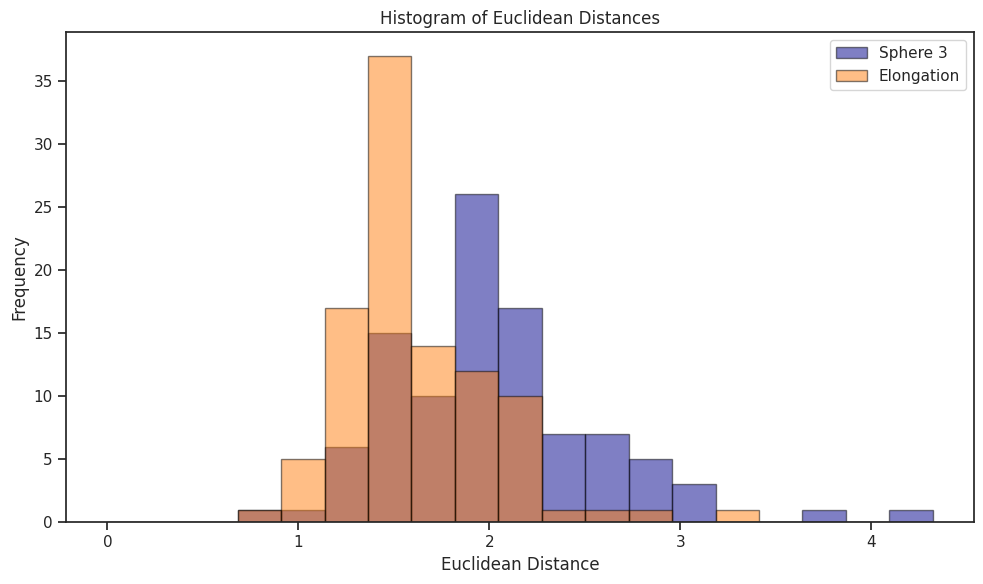

In [128]:
bins_mse = np.linspace(0, max(np.max(euclidean_distances_sphere_3_mse), np.max(euclidean_distances_elongated_mse)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_sphere_3_mse, bins=bins_mse, alpha=0.5, label='Sphere 3', color='#00008B', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_mse, bins=bins_mse, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja

plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()

plt.tight_layout()
plt.show()

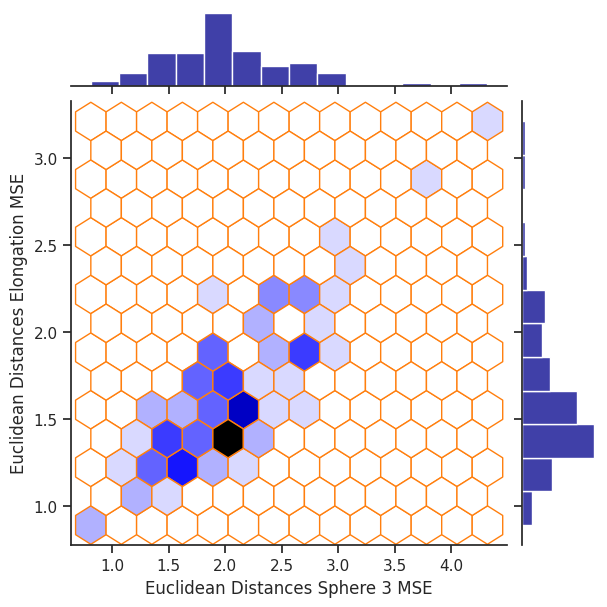

In [129]:
x_mse = euclidean_distances_sphere_3_mse
y_mse = euclidean_distances_elongated_mse

sns.set_theme(style="ticks")
g = sns.jointplot(x=x_mse, y=y_mse, kind="hex", color="#00008B") 
g.ax_joint.collections[0].set_edgecolor("#ff7f0e")
plt.xlabel('Euclidean Distances Sphere 3 MSE')
plt.ylabel('Euclidean Distances Elongation MSE')
plt.show()

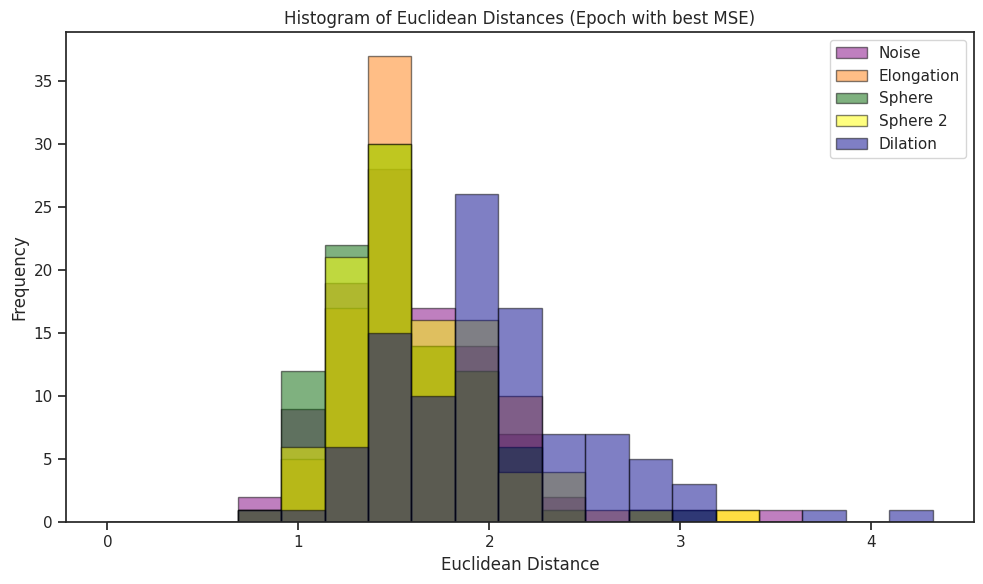

In [ ]:
bins = np.linspace(0, max(np.max(euclidean_distances_noise_mse), 
                          np.max(euclidean_distances_elongated_mse), 
                          np.max(euclidean_distances_sphere_mse), 
                          np.max(euclidean_distances_sphere_2_mse), 
                          np.max(euclidean_distances_sphere_3_mse)), 20)

plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_mse, bins=bins, alpha=0.5, label='Noise', color='#800080', edgecolor='black')  # Morado
plt.hist(euclidean_distances_elongated_mse, bins=bins, alpha=0.5, label='Elongation', color='#ff7f0e', edgecolor='black')  # Naranja
plt.hist(euclidean_distances_sphere_mse, bins=bins, alpha=0.5, label='Sphere', color='#006400', edgecolor='black')  # Verde oscuro
plt.hist(euclidean_distances_sphere_2_mse, bins=bins, alpha=0.5, label='Sphere 2', color='#FFFF00', edgecolor='black')  # Rosa
plt.hist(euclidean_distances_sphere_3_mse, bins=bins, alpha=0.5, label='Dilation', color='#00008B', edgecolor='black')  # Gris
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (Epoch with best MSE)')
plt.legend()
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



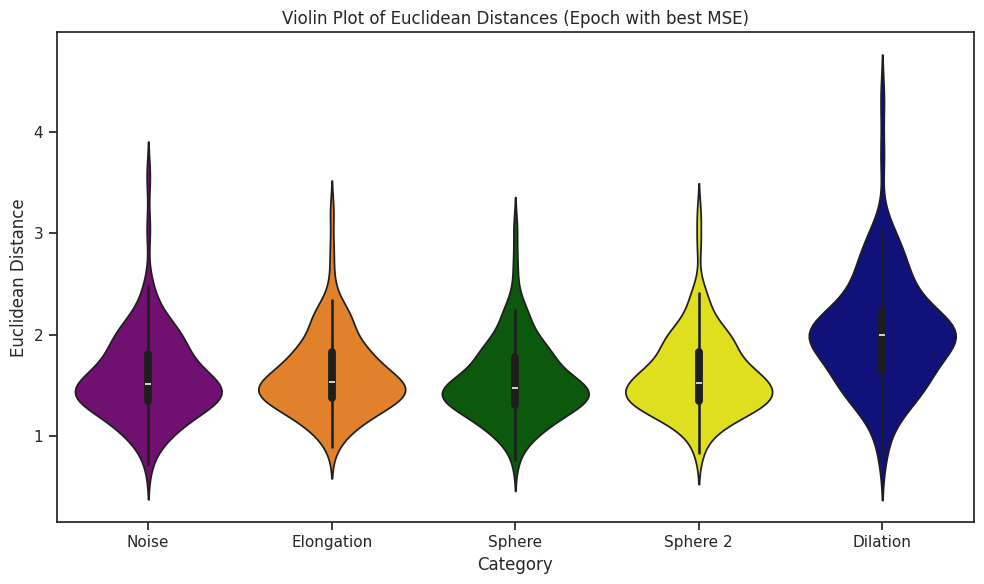

In [140]:
data = {
    'Distance': np.concatenate([euclidean_distances_noise_mse, 
                                euclidean_distances_elongated_mse, 
                                euclidean_distances_sphere_mse, 
                                euclidean_distances_sphere_2_mse, 
                                euclidean_distances_sphere_3_mse]),
    'Category': ['Noise'] * len(euclidean_distances_noise_mse) + 
                ['Elongation'] * len(euclidean_distances_elongated_mse) + 
                ['Sphere'] * len(euclidean_distances_sphere_mse) + 
                ['Sphere 2'] * len(euclidean_distances_sphere_2_mse) + 
                ['Dilation'] * len(euclidean_distances_sphere_3_mse)
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Distance', data=df, palette={
    'Noise': '#800080', 
    'Elongation': '#ff7f0e', 
    'Sphere': '#006400', 
    'Sphere 2': '#FFFF00', 
    'Dilation': '#00008B'
})

plt.xlabel('Category')
plt.ylabel('Euclidean Distance')
plt.title('Violin Plot of Euclidean Distances (Epoch with best MSE)')
plt.tight_layout()
plt.show()

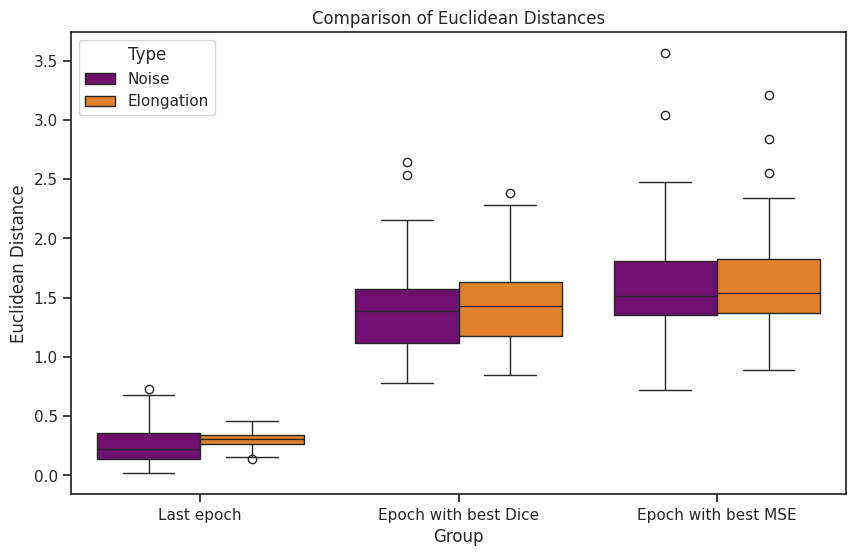

In [ ]:
distances_noise_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
distances_elongation_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

distances_noise_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
distances_elongation_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

distances_noise_3 = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)
distances_elongation_3 = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': (
        list(distances_noise_1) + list(distances_elongation_1) +
        list(distances_noise_2) + list(distances_elongation_2) +
        list(distances_noise_3) + list(distances_elongation_3)
    ),
    'Type': (
        ['Noise'] * len(distances_noise_1) + ['Elongation'] * len(distances_elongation_1) +
        ['Noise'] * len(distances_noise_2) + ['Elongation'] * len(distances_elongation_2) +
        ['Noise'] * len(distances_noise_3) + ['Elongation'] * len(distances_elongation_3)
    ),
    'Group': (
        ['Last epoch'] * (len(distances_noise_1) + len(distances_elongation_1)) +
        ['Epoch with best Dice'] * (len(distances_noise_2) + len(distances_elongation_2)) +
        ['Epoch with best MSE'] * (len(distances_noise_3) + len(distances_elongation_3))
    )
})

palette = {"Noise": "#800080", "Elongation": "#ff7f0e"}

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Distance', hue='Type', data=df, palette=palette)
plt.title("Comparison of Euclidean Distances")
plt.ylabel("Euclidean Distance")
plt.show()

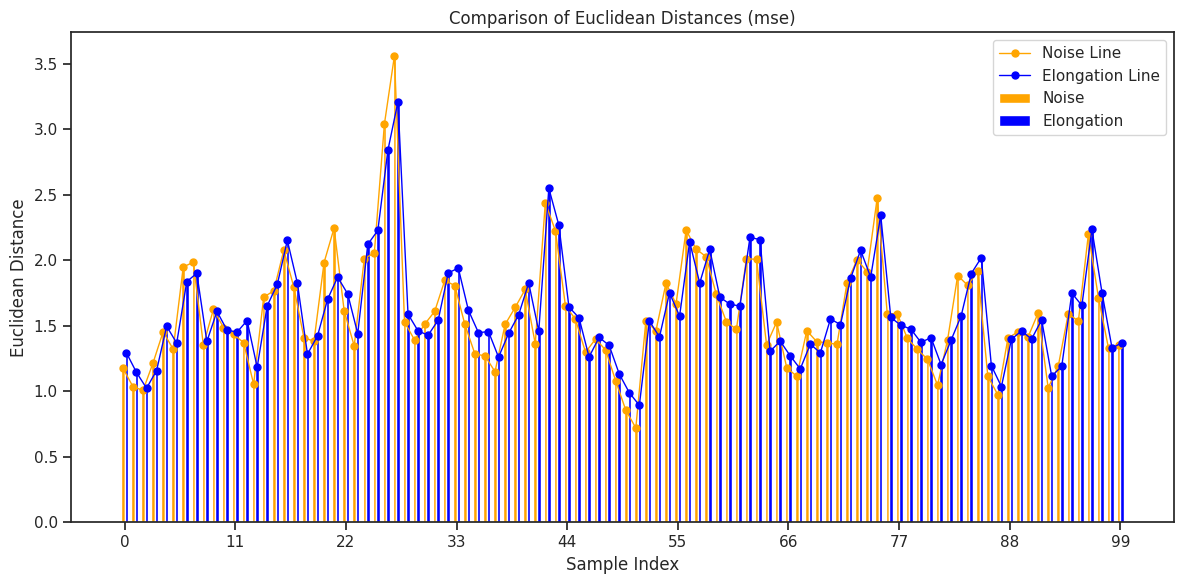

In [133]:
euclidean_distances_noise_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

x = np.arange(len(euclidean_distances_noise_mse))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, euclidean_distances_noise_mse, width, label='Noise', color='orange')
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_mse, width, label='Elongation', color='blue')

ax.plot(x - width/2, euclidean_distances_noise_mse, color='orange', linewidth=1, marker='o', markersize=5, label='Noise Line')
ax.plot(x + width/2, euclidean_distances_elongated_mse, color='blue', linewidth=1, marker='o', markersize=5, label='Elongation Line')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (mse)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

Files TSV

In [134]:
# train_latent_vectors_array = np.concatenate((best_train_latent_vectors, train_latent_vectors_noise), axis=0)
# val_latent_vectors_array = np.concatenate((best_val_latent_vectors, val_latent_vectors_noise), axis=0)

# print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array.shape}")
# print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array.shape}")

# if len(train_latent_vectors_array.shape) == 1:
#     train_latent_vectors_array = train_latent_vectors_array.reshape(-1, 1)
# if len(val_latent_vectors_array.shape) == 1:
#     val_latent_vectors_array = val_latent_vectors_array.reshape(-1, 1)

# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'train_latent_vectors.tsv'), train_latent_vectors_array, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'val_latent_vectors.tsv'), val_latent_vectors_array, delimiter='\t')

# print(f"Vectores latentes guardados en {output_dir}")

In [135]:
# import os
# import pandas as pd

# output_dir = '/mnt/nfs/home/liglesias'
# val_latent_vectors_df = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors.tsv'), sep='\t', header=None)
# print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df.shape}")

# val_latent_vectors_original_df = val_latent_vectors_df.iloc[:100]
# val_latent_vectors_noise_df = val_latent_vectors_df.iloc[-100:]

# num_original = len(val_latent_vectors_original_df)
# num_noise = len(val_latent_vectors_noise_df)

# metadata = {
#     'ID': list(range(1, num_original + num_noise + 1)),
#     'Type': ['Original'] * num_original + ['Noise'] * num_noise
# }
# metadata_df = pd.DataFrame(metadata)

# metadata_df.to_csv(os.path.join(output_dir, 'metadata.tsv'), sep='\t', index=False)

# print(f"Archivo de metadatos guardado en {output_dir}/metadata.tsv")